In [130]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
from read_data import get_network_df, get_corrs, get_full_df
from numba.core import types
import graph_tool
import numba

from numba import njit
from graph_tool.topology import shortest_distance
import pandas as pd
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types


from sinkhorn import Sinkhorn
from transport_problem import OptimParams, DualOracle, HyperParams

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types
from tqdm import tqdm

from transport_problem import OptimParams, DualOracle, HyperParams


# graph = None # TODO создавать граф
# oracle = None # TODO - создать оракла
# sources, targets = None, None    # определять sources и targets
# oracle_stacker = OracleStacker(oracle, graph, sources, targets)


class OracleSinkhornStacker:
    def __init__(self, oracle: DualOracle, graph, sources, targets, l, w, params):
        self.oracle = oracle
        self.graph = graph
        self.sources = sources
        self.targets = targets

        self.T_LEN = oracle.edges_num
        self.LA_LEN = oracle.zones_num
        self.MU_LEN = oracle.zones_num

        # размер вектора параметров [t, la, mu]
        self.parameters_vector_size = self.T_LEN + self.LA_LEN + self.MU_LEN

        self.t = oracle.t_bar.copy()
        self.la = np.zeros(oracle.zones_num)
        self.mu = np.zeros(oracle.zones_num)
        self.optim_params = OptimParams(self.t, self.la, self.mu)
        
        self.sinkhorn = Sinkhorn(l, w, max_iter=100)
        self.params = params

    def __call__(self, vars_block, *args, **kwargs):
        """
        :param vars_block: все оптимизируемые переменные stack[t, la, mu]
        :return:
        dual_value -  значение двойстенной функции для t, la, mu
        full_grad - градиент, stack[t_grad, la_grad, mu_grad]
        flows_averaged -  потоки при данных t (f)
        """
        print("vars block grad: ", np.linalg.norm(vars_block))
        assert len(vars_block) == self.T_LEN

        self.optim_params.t = vars_block
        print("t in optim params grad: ", np.linalg.norm(self.optim_params.t), np.linalg.norm(vars_block[:self.T_LEN]))
        print("la in optim params grad: ", np.linalg.norm(self.optim_params.la))
        print("mu in optim params grad: ", np.linalg.norm(self.optim_params.mu))

        T, pred_maps = self.oracle.get_T_and_predmaps(self.graph, self.optim_params, self.sources, self.targets)
        print("norm T: ", np.linalg.norm(T))

        # self.d = self.oracle.get_d(self.optim_params, T)
        self.d, self.optim_params.la, self.optim_params.mu = self.sinkhorn.run(T / self.params.gamma)
        flows_on_shortest = self.oracle.get_flows_on_shortest(self.sources, self.targets, self.d, pred_maps)

        grad_t = self.oracle.grad_dF_dt(self.optim_params, flows_on_shortest)
        grad_la = self.oracle.grad_dF_dla(self.d)
        grad_mu = self.oracle.grad_dF_dmu(self.d)

        full_grad = grad_t
        dual_value = self.oracle.calc_F(self.optim_params, T)

        self.flows = self.oracle.get_flows_on_shortest(self.sources, self.targets, self.d, pred_maps)

        return dual_value, full_grad, flows_on_shortest

    def get_prime_value(self):
        return self.oracle.prime(self.flows, self.d)

    def get_init_vars_block(self):
        return self.oracle.t_bar.copy()


# TODO: убрать unused переменные
def ustm_mincost_mcf(
        oracle_stacker: OracleStacker,
        eps_abs: float,
        eps_cons_abs: float,
        max_iter: int = 10000,
        stop_by_crit: bool = True,
) -> tuple:
    dgap_log = []
    cons_log = []
    A_log = []
    history_dual_values = []
    history_prime_values = []
    d_history = []
    flows_history = []

    A_prev = 0.0
    print(1)

    # t_start = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
    t_start = oracle_stacker.get_init_vars_block()  # dual costs w
    print(1)

    y_start = u_prev = t_prev = np.copy(t_start)
    assert y_start is u_prev  # acceptable at first initialization

    print(1)
    grad_sum_prev = np.zeros(len(t_start))

    _, grad_y, flows_averaged = oracle_stacker(y_start)
    d_avaraged = oracle_stacker.d.copy()

    L_value = np.linalg.norm(grad_y) / 10

    A = u = t = y = None
    inner_iters_num = 0

    print("start optimizing")
    # for k in tqdm(range(max_iter)):
    for k in tqdm(range(max_iter)):
        while True:
            inner_iters_num += 1

            alpha = 0.5 / L_value + (0.25 / L_value ** 2 + A_prev / L_value) ** 0.5
            A = A_prev + alpha

            y = (alpha * u_prev + A_prev * t_prev) / A
            func_y, grad_y, flows_y = oracle_stacker(y)
            #             history_dual_values.append(func_y)

            grad_sum = grad_sum_prev + alpha * grad_y

            u = y_start - grad_sum
            print("count values below t_bar in new t: ", (u[:oracle_stacker.T_LEN] < oracle_stacker.oracle.t_bar).sum())
            u[:oracle_stacker.T_LEN] = np.maximum(oracle_stacker.oracle.t_bar, u[:oracle_stacker.T_LEN])
            # u = np.maximum(0, y_start - grad_sum)

            t = (alpha * u + A_prev * t_prev) / A
            func_t, _, _ = oracle_stacker(t)

            lvalue = func_t

            print("norm (t - y): ", np.linalg.norm(t - y))
            print("norm t: ", np.linalg.norm(oracle_stacker.optim_params.t))
            print("norm la: ", np.linalg.norm(oracle_stacker.optim_params.la))
            print("norm mu: ", np.linalg.norm(oracle_stacker.optim_params.mu))
            print()

            rvalue = (func_y + np.dot(grad_y, t - y) + 0.5 * L_value * np.sum((t - y) ** 2) +
                      #                      0.5 * alpha / A * eps_abs )  # because, in theory, noise accumulates
                      0.5 * eps_abs)

            if lvalue <= rvalue:
                break
            else:
                L_value *= 2

            assert L_value < np.inf

        # history_dual_values.append(func_y)
        #         history_prime_values.append(oracle_stacker.get_prime_value())

        history_dual_values.append(func_t)
        history_prime_values.append(oracle_stacker.oracle.prime(flows_averaged, d_avaraged))

        A_prev = A
        L_value /= 2

        t_prev = t
        u_prev = u
        grad_sum_prev = grad_sum

        teta = alpha / A
        # TODO TODO
        print("#######################################teta: ", teta)
        flows_averaged = flows_averaged * (1 - teta) + flows_y * teta
        #         flows_averaged_e = flows_averaged.sum(axis=(0, 1))
        d_avaraged = d_avaraged * (1 - teta) + oracle_stacker.d * teta
        d_history.append(oracle_stacker.d)
        flows_history.append(flows_y)

        dgap_log.append(oracle_stacker.oracle.prime(flows_averaged, d_avaraged) + func_t)
        # cons_log.append(model.constraints_violation_l1(flows_averaged_e))
        A_log.append(A)

        if stop_by_crit and dgap_log[-1] <= eps_abs and cons_log[-1] <= eps_cons_abs:
            break

    return t, flows_history, flows_averaged, d_history, d_avaraged, history_prime_values, history_dual_values, dgap_log,\
           cons_log, A_log, history_dual_values, history_prime_values


In [132]:
T_LEN = 76
LA_LEN = 25
MU_LEN = 25

In [133]:
net_df = get_network_df(Path('SiouxFalls') / 'SiouxFalls_net.tntp')
corrs = get_corrs(Path('SiouxFalls') / 'SiouxFalls_trips.tntp')
corrs = corrs / corrs.sum()

graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])
graph.ep.capacity.a = graph.ep.capacity.a / corrs.sum()

# from graph_tool.draw import graph_draw
# graph_draw(graph)


In [134]:
from transport_problem import HyperParams, DualOracle, OptimParams
l = np.sum(corrs, axis=1)
w = np.sum(corrs, axis=0)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)
oracle = DualOracle(graph, net_df, l, w, params)
oracle_stacker = OracleSinkhornStacker(oracle, graph, sources, targets, l, w, params)

In [135]:
t, flows_history, flows_averaged, d_history, d_avaraged, history_prime_values, history_dual_values, dgap_log,\
           cons_log, A_log, history_dual_values, history_prime_values = ustm_mincost_mcf(oracle_stacker,  eps_abs=1e-2, eps_cons_abs=1e-6, max_iter=600, stop_by_crit=False)

1
1
1
vars block grad:  39.01281840626232
t in optim params grad:  39.01281840626232 39.01281840626232
la in optim params grad:  0.0
mu in optim params grad:  0.0
norm T:  290.82297020696285
Sinkhorn crit contraints norm: 4.144299002417045e-07, dual gap: 3.0201812576325e-07, eps: 1e-06
primal val: -5.16321995660168
sink iters: 10
grad dF dla:  4.1442990024170455e-07
grad dF dmu:  8.679253400069318e-17
start optimizing


  0%|                                                   | 0/600 [00:00<?, ?it/s]

vars block grad:  39.01281840626232
t in optim params grad:  39.01281840626232 39.01281840626232
la in optim params grad:  22.469872544126908
mu in optim params grad:  2.7599797069093213
norm T:  290.82297020696285
Sinkhorn crit contraints norm: 4.144299002417045e-07, dual gap: 3.0201812576325e-07, eps: 1e-06
primal val: -5.16321995660168
sink iters: 10
grad dF dla:  4.1442990024170455e-07
grad dF dmu:  8.679253400069318e-17
count values below t_bar in new t:  0
vars block grad:  46.43749560577758
t in optim params grad:  46.43749560577758 46.43749560577758
la in optim params grad:  22.469872544126908
mu in optim params grad:  2.7599797069093213
norm T:  376.3669032876803
Sinkhorn crit contraints norm: 3.8161534113783e-06, dual gap: 3.060295319883329e-06, eps: 1e-06
primal val: -4.9239425260505865
Sinkhorn crit contraints norm: 2.354853153380459e-10, dual gap: 1.556767205976865e-10, eps: 1e-06
primal val: -4.923945585990119
sink iters: 20
grad dF dla:  2.354853153380336e-10
grad dF dmu

norm T:  290.86812701867916
Sinkhorn crit contraints norm: 4.1499791101129957e-07, dual gap: 3.024437697908984e-07, eps: 1e-06
primal val: -5.163083267858354
sink iters: 10
grad dF dla:  4.149979110112996e-07
grad dF dmu:  9.088692921481273e-17
norm (t - y):  0.004882812499999961
norm t:  39.01616307840226
norm la:  22.469179493345244
norm mu:  2.7599664410707536

vars block grad:  39.01281840626232
t in optim params grad:  39.01281840626232 39.01281840626232
la in optim params grad:  22.469179493345244
mu in optim params grad:  2.7599664410707536
norm T:  290.82297020696285


  0%|                                           | 1/600 [00:00<05:20,  1.87it/s]

Sinkhorn crit contraints norm: 4.144299002417045e-07, dual gap: 3.0201812576325e-07, eps: 1e-06
primal val: -5.16321995660168
sink iters: 10
grad dF dla:  4.1442990024170455e-07
grad dF dmu:  8.679253400069318e-17
count values below t_bar in new t:  0
vars block grad:  39.01449070178637
t in optim params grad:  39.01449070178637 39.01449070178637
la in optim params grad:  22.469872544126908
mu in optim params grad:  2.7599797069093213
norm T:  290.84554842791584
Sinkhorn crit contraints norm: 4.147138166511049e-07, dual gap: 3.0223087918637815e-07, eps: 1e-06
primal val: -5.163151610996631
sink iters: 10
grad dF dla:  4.147138166511049e-07
grad dF dmu:  6.919894354330614e-17
norm (t - y):  0.002441406250000066
norm t:  39.01449070178637
norm la:  22.469526012334
norm mu:  2.7599730734655363

vars block grad:  39.01281840626232
t in optim params grad:  39.01281840626232 39.01281840626232
la in optim params grad:  22.469526012334
mu in optim params grad:  2.7599730734655363
norm T:  290.

  1%|▍                                          | 6/600 [00:00<01:02,  9.55it/s]

vars block grad:  39.01392271128891
t in optim params grad:  39.01392271128891 39.01392271128891
la in optim params grad:  22.469777841755043
mu in optim params grad:  2.759985045350485
norm T:  290.8316099742718
Sinkhorn crit contraints norm: 4.145684345143763e-07, dual gap: 3.021072171019438e-07, eps: 1e-06
primal val: -5.163192207656594
sink iters: 10
grad dF dla:  4.1456843451437634e-07
grad dF dmu:  5.1019748043878786e-17
count values below t_bar in new t:  55
vars block grad:  39.014091071882056
t in optim params grad:  39.014091071882056 39.014091071882056
la in optim params grad:  22.469743965827746
mu in optim params grad:  2.7599872327854396
norm T:  290.8397687865912
Sinkhorn crit contraints norm: 4.147785202480913e-07, dual gap: 3.022883724202649e-07, eps: 1e-06
primal val: -5.163164509011431
sink iters: 10
grad dF dla:  4.1477852024809134e-07
grad dF dmu:  9.616378215626109e-17
norm (t - y):  0.003126868284070077
norm t:  39.014091071882056
norm la:  22.469609186797033
nor

  1%|▌                                          | 8/600 [00:00<00:54, 10.77it/s]

norm (t - y):  0.0007671267014723558
norm t:  39.01330141291982
norm la:  22.469791572300092
norm mu:  2.759984568565771

#######################################teta:  0.2943770692718531
vars block grad:  39.01325577659735
t in optim params grad:  39.01325577659735 39.01325577659735
la in optim params grad:  22.469791572300092
mu in optim params grad:  2.759984568565771
norm T:  290.8278157231168
Sinkhorn crit contraints norm: 4.1450339499446506e-07, dual gap: 3.0208136879639647e-07, eps: 1e-06
primal val: -5.163203175458344
sink iters: 10
grad dF dla:  4.1450339499446506e-07
grad dF dmu:  7.802881839404627e-17
count values below t_bar in new t:  64
vars block grad:  39.013488075242535
t in optim params grad:  39.013488075242535 39.013488075242535
la in optim params grad:  22.46979567922932
mu in optim params grad:  2.7599818094764608
norm T:  290.83045682898296
Sinkhorn crit contraints norm: 4.1445505156229495e-07, dual gap: 3.0204794370133606e-07, eps: 1e-06
primal val: -5.1631995322

  2%|▉                                         | 13/600 [00:01<00:38, 15.38it/s]

Sinkhorn crit contraints norm: 4.1448273451969125e-07, dual gap: 3.0205530008942263e-07, eps: 1e-06
primal val: -5.163202707174997
sink iters: 10
grad dF dla:  4.144827345196912e-07
grad dF dmu:  7.709767671040427e-17
norm (t - y):  0.0008788245852178571
norm t:  39.013331604078395
norm la:  22.46977192448116
norm mu:  2.75997415744619

#######################################teta:  0.2002739523683262
vars block grad:  39.01340347144032
t in optim params grad:  39.01340347144032 39.01340347144032
la in optim params grad:  22.46977192448116
mu in optim params grad:  2.75997415744619
norm T:  290.8317111764492
Sinkhorn crit contraints norm: 4.145048202372965e-07, dual gap: 3.0206245361091023e-07, eps: 1e-06
primal val: -5.163200020388471
sink iters: 10
grad dF dla:  4.1450482023729657e-07
grad dF dmu:  7.39651590160867e-17
count values below t_bar in new t:  72
vars block grad:  39.013233292076
t in optim params grad:  39.013233292076 39.013233292076
la in optim params grad:  22.469747244

  2%|█                                         | 15/600 [00:01<00:45, 12.89it/s]

Sinkhorn crit contraints norm: 4.144651887636903e-07, dual gap: 3.0203928774659e-07, eps: 1e-06
primal val: -5.163212246853645
sink iters: 10
grad dF dla:  4.1446518876369025e-07
grad dF dmu:  1.1649801533439874e-16
count values below t_bar in new t:  72
vars block grad:  39.01333535963636
t in optim params grad:  39.01333535963636 39.01333535963636
la in optim params grad:  22.46982031797352
mu in optim params grad:  2.759975165089797
norm T:  290.83655519114774
Sinkhorn crit contraints norm: 4.1457695422647e-07, dual gap: 3.0215512760772285e-07, eps: 1e-06
primal val: -5.16317178740658
sink iters: 10
grad dF dla:  4.1457695422647e-07
grad dF dmu:  5.831354952374888e-17
norm (t - y):  0.004433710430056472
norm t:  39.01333535963636
norm la:  22.469649382251433
norm mu:  2.7599955666787284

vars block grad:  39.013054830620284
t in optim params grad:  39.013054830620284 39.013054830620284
la in optim params grad:  22.469649382251433
mu in optim params grad:  2.7599955666787284
norm T: 

  3%|█▎                                        | 19/600 [00:01<00:41, 14.12it/s]

Sinkhorn crit contraints norm: 4.1446269473026903e-07, dual gap: 3.0204442254375055e-07, eps: 1e-06
primal val: -5.163210249920614
sink iters: 10
grad dF dla:  4.1446269473026903e-07
grad dF dmu:  6.867511495873268e-17
count values below t_bar in new t:  73
vars block grad:  39.01305352617363
t in optim params grad:  39.01305352617363 39.01305352617363
la in optim params grad:  22.469820763862067
mu in optim params grad:  2.75997983067482
norm T:  290.8275420322246
Sinkhorn crit contraints norm: 4.144751473851219e-07, dual gap: 3.0205153759472597e-07, eps: 1e-06
primal val: -5.1632084791563715
sink iters: 10
grad dF dla:  4.144751473851219e-07
grad dF dmu:  4.623127565230183e-17
norm (t - y):  0.0008252471770093806
norm t:  39.01305352617363
norm la:  22.469808589048608
norm mu:  2.7599722612506152

#######################################teta:  0.1703042454545625
vars block grad:  39.0130829721489
t in optim params grad:  39.0130829721489 39.0130829721489
la in optim params grad:  22.4

  4%|█▍                                        | 21/600 [00:01<00:41, 13.87it/s]

Sinkhorn crit contraints norm: 4.1464994208114155e-07, dual gap: 3.0207355955496254e-07, eps: 1e-06
primal val: -5.163103955031507
sink iters: 10
grad dF dla:  4.1464994208114155e-07
grad dF dmu:  7.110779437165113e-17
norm (t - y):  0.00991084584426274
norm t:  39.015266387112575
norm la:  22.469411776816827
norm mu:  2.760048105488071

vars block grad:  39.01348976247663
t in optim params grad:  39.01348976247663 39.01348976247663
la in optim params grad:  22.469411776816827
mu in optim params grad:  2.760048105488071
norm T:  290.83158605213356
Sinkhorn crit contraints norm: 4.1449165557390285e-07, dual gap: 3.0203216967427173e-07, eps: 1e-06
primal val: -5.163199523153672
sink iters: 10
grad dF dla:  4.1449165557390285e-07
grad dF dmu:  7.411249505600425e-17
count values below t_bar in new t:  67
vars block grad:  39.014084699196886
t in optim params grad:  39.014084699196886 39.014084699196886
la in optim params grad:  22.469741994323932
mu in optim params grad:  2.759952706304644

  4%|█▌                                        | 23/600 [00:01<00:45, 12.75it/s]

norm T:  290.83568239066807
Sinkhorn crit contraints norm: 4.146096004000938e-07, dual gap: 3.0211283590455195e-07, eps: 1e-06
primal val: -5.1631807722630265
sink iters: 10
grad dF dla:  4.146096004000938e-07
grad dF dmu:  6.965406207688017e-17
norm (t - y):  0.001700186975274847
norm t:  39.01407591810584
norm la:  22.469680010336013
norm mu:  2.7599645764850615

#######################################teta:  0.08437512372738305
vars block grad:  39.014282664096385
t in optim params grad:  39.014282664096385 39.014282664096385
la in optim params grad:  22.469680010336013
mu in optim params grad:  2.7599645764850615
norm T:  290.8369448612194
Sinkhorn crit contraints norm: 4.146776544960302e-07, dual gap: 3.0218028866252006e-07, eps: 1e-06
primal val: -5.163177978029857
sink iters: 10
grad dF dla:  4.146776544960303e-07
grad dF dmu:  8.239936510889834e-17
count values below t_bar in new t:  68
vars block grad:  39.01457271479178
t in optim params grad:  39.01457271479178 39.01457271479

  4%|█▉                                        | 27/600 [00:02<00:43, 13.21it/s]

Sinkhorn crit contraints norm: 4.1464324187983214e-07, dual gap: 3.021502560401412e-07, eps: 1e-06
primal val: -5.163181771065008
sink iters: 10
grad dF dla:  4.1464324187983214e-07
grad dF dmu:  9.022646838349988e-17
count values below t_bar in new t:  71
vars block grad:  39.01414930068935
t in optim params grad:  39.01414930068935 39.01414930068935
la in optim params grad:  22.469676238656568
mu in optim params grad:  2.7599520665629615
norm T:  290.8369582320294
Sinkhorn crit contraints norm: 4.146556706871546e-07, dual gap: 3.021688881409118e-07, eps: 1e-06
primal val: -5.163179722412967
sink iters: 10
grad dF dla:  4.146556706871545e-07
grad dF dmu:  7.697560551583115e-17
norm (t - y):  0.0005902385353532949
norm t:  39.01414930068935
norm la:  22.46966863019392
norm mu:  2.7599536321656446

#######################################teta:  0.07353354472551936
vars block grad:  39.0141389487591
t in optim params grad:  39.0141389487591 39.0141389487591
la in optim params grad:  22.46

  5%|██                                        | 29/600 [00:02<00:42, 13.40it/s]

Sinkhorn crit contraints norm: 4.14633856673372e-07, dual gap: 3.021521165186173e-07, eps: 1e-06
primal val: -5.163186888497804
sink iters: 10
grad dF dla:  4.1463385667337204e-07
grad dF dmu:  5.851960511113821e-17
norm (t - y):  0.0008790690911473981
norm t:  39.01389792271089
norm la:  22.469693738416463
norm mu:  2.7599639793164177

#######################################teta:  0.09090302108079487
vars block grad:  39.01376777401011
t in optim params grad:  39.01376777401011 39.01376777401011
la in optim params grad:  22.469693738416463
mu in optim params grad:  2.7599639793164177
norm T:  290.8335490168468
Sinkhorn crit contraints norm: 4.1460926340388024e-07, dual gap: 3.0213596073288736e-07, eps: 1e-06
primal val: -5.163190875074326
sink iters: 10
grad dF dla:  4.1460926340388024e-07
grad dF dmu:  7.194921154484755e-17
count values below t_bar in new t:  71
vars block grad:  39.01417702379183
t in optim params grad:  39.01417702379183 39.01417702379183
la in optim params grad:  

  5%|██▏                                       | 32/600 [00:02<00:33, 16.81it/s]

Sinkhorn crit contraints norm: 4.145561101741292e-07, dual gap: 3.021035754360528e-07, eps: 1e-06
primal val: -5.163195371095533
sink iters: 10
grad dF dla:  4.145561101741293e-07
grad dF dmu:  7.267228508430414e-17
norm (t - y):  0.0
norm t:  39.01372765450064
norm la:  22.469744063084626
norm mu:  2.7599634463463563

#######################################teta:  0.1466411439029638
vars block grad:  39.01355763055259
t in optim params grad:  39.01355763055259 39.01355763055259
la in optim params grad:  22.469744063084626
mu in optim params grad:  2.7599634463463563
norm T:  290.83002996766055
Sinkhorn crit contraints norm: 4.14532507761798e-07, dual gap: 3.0208759621785787e-07, eps: 1e-06
primal val: -5.1631999683014955
sink iters: 10
grad dF dla:  4.14532507761798e-07
grad dF dmu:  8.724210487059681e-17
count values below t_bar in new t:  69
vars block grad:  39.014657679353164
t in optim params grad:  39.014657679353164 39.014657679353164
la in optim params grad:  22.469768087498828

  6%|██▍                                       | 34/600 [00:02<00:43, 12.99it/s]

Sinkhorn crit contraints norm: 4.1471268739611246e-07, dual gap: 3.0217619385562147e-07, eps: 1e-06
primal val: -5.163189988432449
sink iters: 10
grad dF dla:  4.1471268739611246e-07
grad dF dmu:  5.0426474987835235e-17
norm (t - y):  0.00234971430542891
norm t:  39.01396581841664
norm la:  22.46973527636469
norm mu:  2.759985493296938

vars block grad:  39.013643608907365
t in optim params grad:  39.013643608907365 39.013643608907365
la in optim params grad:  22.46973527636469
mu in optim params grad:  2.759985493296938
norm T:  290.83012781029913
Sinkhorn crit contraints norm: 4.1453359699495446e-07, dual gap: 3.020883970298789e-07, eps: 1e-06
primal val: -5.163199662040914
sink iters: 10
grad dF dla:  4.1453359699495446e-07
grad dF dmu:  5.586913888185023e-17
count values below t_bar in new t:  73
vars block grad:  39.0137665767169
t in optim params grad:  39.0137665767169 39.0137665767169
la in optim params grad:  22.469766579290564
mu in optim params grad:  2.759966454990671
norm 

  6%|██▌                                       | 37/600 [00:03<00:44, 12.66it/s]

Sinkhorn crit contraints norm: 4.1471568967926746e-07, dual gap: 3.022397097381308e-07, eps: 1e-06
primal val: -5.163179864373913
sink iters: 10
grad dF dla:  4.1471568967926746e-07
grad dF dmu:  8.346976720404659e-17
norm (t - y):  0.002786272347043847
norm t:  39.01417858041868
norm la:  22.46970045888412
norm mu:  2.759989784098564

vars block grad:  39.0137824868264
t in optim params grad:  39.0137824868264 39.0137824868264
la in optim params grad:  22.46970045888412
mu in optim params grad:  2.759989784098564
norm T:  290.83035566540525
Sinkhorn crit contraints norm: 4.146262533218212e-07, dual gap: 3.021535475922286e-07, eps: 1e-06
primal val: -5.163197270969952
sink iters: 10
grad dF dla:  4.1462625332182113e-07
grad dF dmu:  6.51157058104266e-17
count values below t_bar in new t:  72
vars block grad:  39.01396555481589
t in optim params grad:  39.01396555481589 39.01396555481589
la in optim params grad:  22.46975609885298
mu in optim params grad:  2.759970535358531
norm T:  290

  6%|██▋                                       | 39/600 [00:03<00:40, 13.86it/s]

vars block grad:  39.01383353667173
t in optim params grad:  39.01383353667173 39.01383353667173
la in optim params grad:  22.46974450970617
mu in optim params grad:  2.759980558993015
norm T:  290.83139189110636
Sinkhorn crit contraints norm: 4.1466038295134753e-07, dual gap: 3.021789900714317e-07, eps: 1e-06
primal val: -5.163190639209087
sink iters: 10
grad dF dla:  4.1466038295134753e-07
grad dF dmu:  6.155213491402444e-17
count values below t_bar in new t:  74
vars block grad:  39.01377228592339
t in optim params grad:  39.01377228592339 39.01377228592339
la in optim params grad:  22.469733851365994
mu in optim params grad:  2.759987908665385
norm T:  290.83054575977013


  7%|██▉                                       | 42/600 [00:03<00:33, 16.89it/s]

Sinkhorn crit contraints norm: 4.1463486070421875e-07, dual gap: 3.0216332570881506e-07, eps: 1e-06
primal val: -5.163194763008051
sink iters: 10
grad dF dla:  4.146348607042187e-07
grad dF dmu:  8.766791992696253e-17
norm (t - y):  0.000796290144149836
norm t:  39.01377228592339
norm la:  22.46975172753432
norm mu:  2.7599805109236364

#######################################teta:  0.056374791311261586
vars block grad:  39.013699206231166
t in optim params grad:  39.013699206231166 39.013699206231166
la in optim params grad:  22.46975172753432
mu in optim params grad:  2.7599805109236364
norm T:  290.8299653828305
Sinkhorn crit contraints norm: 4.14619154058475e-07, dual gap: 3.021521993691551e-07, eps: 1e-06
primal val: -5.163196693098638
sink iters: 10
grad dF dla:  4.1461915405847496e-07
grad dF dmu:  7.451742906319538e-17
count values below t_bar in new t:  74
vars block grad:  39.013699206231166
t in optim params grad:  39.013699206231166 39.013699206231166
la in optim params grad

  7%|███                                       | 44/600 [00:03<00:34, 16.08it/s]

Sinkhorn crit contraints norm: 4.1456342362570515e-07, dual gap: 3.0211271979174924e-07, eps: 1e-06
primal val: -5.163203542213079
sink iters: 10
grad dF dla:  4.1456342362570515e-07
grad dF dmu:  7.964629152901884e-17
norm (t - y):  0.0
norm t:  39.01343987932904
norm la:  22.469793828455387
norm mu:  2.7599802306201555

#######################################teta:  0.09100837426283488
vars block grad:  39.013364873214094
t in optim params grad:  39.013364873214094 39.013364873214094
la in optim params grad:  22.469793828455387
mu in optim params grad:  2.7599802306201555
norm T:  290.82731018989614
Sinkhorn crit contraints norm: 4.1454730602488385e-07, dual gap: 3.0210130251931457e-07, eps: 1e-06
primal val: -5.163205523235648
sink iters: 10
grad dF dla:  4.1454730602488385e-07
grad dF dmu:  7.624894110490301e-17
count values below t_bar in new t:  69
vars block grad:  39.01682023873721
t in optim params grad:  39.01682023873721 39.01682023873721
la in optim params grad:  22.46980332

  8%|███▎                                      | 48/600 [00:03<00:39, 14.01it/s]

Sinkhorn crit contraints norm: 4.1455613434781966e-07, dual gap: 3.021151377025928e-07, eps: 1e-06
primal val: -5.163200476443121
sink iters: 10
grad dF dla:  4.1455613434781966e-07
grad dF dmu:  7.254795259789033e-17
norm (t - y):  0.0006438939869055638
norm t:  39.01347541777977
norm la:  22.46978077853882
norm mu:  2.759984418183644

#######################################teta:  0.022494736861997062
vars block grad:  39.01352378798432
t in optim params grad:  39.01352378798432 39.01352378798432
la in optim params grad:  22.46978077853882
mu in optim params grad:  2.759984418183644
norm T:  290.82959220058905
Sinkhorn crit contraints norm: 4.145463082957546e-07, dual gap: 3.021185530613797e-07, eps: 1e-06
primal val: -5.163196341816647
sink iters: 10
grad dF dla:  4.1454630829575465e-07
grad dF dmu:  6.73197883269564e-17
count values below t_bar in new t:  73
vars block grad:  39.01346913306699
t in optim params grad:  39.01346913306699 39.01346913306699
la in optim params grad:  22.

  8%|███▌                                      | 50/600 [00:03<00:36, 15.00it/s]

norm T:  290.8344013278302
Sinkhorn crit contraints norm: 4.146374900522138e-07, dual gap: 3.022063314721242e-07, eps: 1e-06
primal val: -5.163176518097852
sink iters: 10
grad dF dla:  4.146374900522139e-07
grad dF dmu:  7.0020324749016e-17
norm (t - y):  0.0031462303927056088
norm t:  39.01397453814702
norm la:  22.46967297035332
norm mu:  2.75999785722451

vars block grad:  39.0135747066354
t in optim params grad:  39.0135747066354 39.0135747066354
la in optim params grad:  22.46967297035332
mu in optim params grad:  2.75999785722451
norm T:  290.8290472339
Sinkhorn crit contraints norm: 4.1454957243609534e-07, dual gap: 3.021026744425847e-07, eps: 1e-06
primal val: -5.1632003250874945
sink iters: 10
grad dF dla:  4.145495724360954e-07
grad dF dmu:  9.034312622289223e-17
count values below t_bar in new t:  74
vars block grad:  39.0135747066354
t in optim params grad:  39.0135747066354 39.0135747066354
la in optim params grad:  22.469771606745027
mu in optim params grad:  2.7599878207

  9%|███▊                                      | 55/600 [00:04<00:33, 16.22it/s]

Sinkhorn crit contraints norm: 4.1456384501713685e-07, dual gap: 3.021195262653773e-07, eps: 1e-06
primal val: -5.163196685365705
sink iters: 10
grad dF dla:  4.145638450171369e-07
grad dF dmu:  8.682286664786625e-17
norm (t - y):  0.0005314914062785867
norm t:  39.013628552091106
norm la:  22.469756650075517
norm mu:  2.7599896222177223

#######################################teta:  0.019777643965133748
vars block grad:  39.01370217007586
t in optim params grad:  39.01370217007586 39.01370217007586
la in optim params grad:  22.469756650075517
mu in optim params grad:  2.7599896222177223
norm T:  290.8309180035204
Sinkhorn crit contraints norm: 4.145827456100924e-07, dual gap: 3.0214219563848814e-07, eps: 1e-06
primal val: -5.16319185524727
sink iters: 10
grad dF dla:  4.145827456100924e-07
grad dF dmu:  5.78732454931545e-17
count values below t_bar in new t:  74
vars block grad:  39.013606206418515
t in optim params grad:  39.013606206418515 39.013606206418515
la in optim params grad:

 10%|███▉                                      | 57/600 [00:04<00:34, 15.54it/s]

Sinkhorn crit contraints norm: 4.1452028198280375e-07, dual gap: 3.020865477863478e-07, eps: 1e-06
primal val: -5.163204253022533
sink iters: 10
grad dF dla:  4.1452028198280375e-07
grad dF dmu:  6.170472609198927e-17
count values below t_bar in new t:  72
vars block grad:  39.01375980960078
t in optim params grad:  39.01375980960078 39.01375980960078
la in optim params grad:  22.46979433802764
mu in optim params grad:  2.7599863977194796
norm T:  290.82906821970226
Sinkhorn crit contraints norm: 4.1451913323427927e-07, dual gap: 3.0209362203992795e-07, eps: 1e-06
primal val: -5.163198981420538
sink iters: 10
grad dF dla:  4.145191332342793e-07
grad dF dmu:  7.384300342650183e-17
norm (t - y):  0.0024849798839619358
norm t:  39.01375980960078
norm la:  22.46977315844706
norm mu:  2.7599840098182695

vars block grad:  39.013380739656284
t in optim params grad:  39.013380739656284 39.013380739656284
la in optim params grad:  22.46977315844706
mu in optim params grad:  2.7599840098182695


 10%|████▏                                     | 59/600 [00:04<00:38, 14.08it/s]

norm T:  290.82875877181226
Sinkhorn crit contraints norm: 4.145147369367067e-07, dual gap: 3.020898518526479e-07, eps: 1e-06
primal val: -5.163200049058492
sink iters: 10
grad dF dla:  4.1451473693670674e-07
grad dF dmu:  8.668411647267523e-17
count values below t_bar in new t:  74
vars block grad:  39.01349043597741
t in optim params grad:  39.01349043597741 39.01349043597741
la in optim params grad:  22.469778192232656
mu in optim params grad:  2.7599838113865074
norm T:  290.82798716015327
Sinkhorn crit contraints norm: 4.1451515776898685e-07, dual gap: 3.020858009773074e-07, eps: 1e-06
primal val: -5.16320296162099
sink iters: 10
grad dF dla:  4.1451515776898685e-07
grad dF dmu:  8.450881278486774e-17
norm (t - y):  0.0013875888157529926
norm t:  39.01349043597741
norm la:  22.469789831983373
norm mu:  2.7599850973325535

#######################################teta:  0.044805086377380864
vars block grad:  39.01344918005378
t in optim params grad:  39.01344918005378 39.013449180053

 10%|████▎                                     | 61/600 [00:04<00:40, 13.22it/s]

norm T:  290.8275368384341
Sinkhorn crit contraints norm: 4.145075043586876e-07, dual gap: 3.020797263667507e-07, eps: 1e-06
primal val: -5.16320448706821
sink iters: 10
grad dF dla:  4.145075043586876e-07
grad dF dmu:  8.072058105825288e-17
count values below t_bar in new t:  72
vars block grad:  39.013456186820164
t in optim params grad:  39.013456186820164 39.013456186820164
la in optim params grad:  22.469797256104588
mu in optim params grad:  2.759984613475368
norm T:  290.82767149830454
Sinkhorn crit contraints norm: 4.1450973834327146e-07, dual gap: 3.020801675618488e-07, eps: 1e-06
primal val: -5.163204355554559
sink iters: 10
grad dF dla:  4.1450973834327146e-07
grad dF dmu:  6.808099033552841e-17
norm (t - y):  0.0001198794160705818
norm t:  39.013456186820164
norm la:  22.46979608293937
norm mu:  2.7599841791436215

#######################################teta:  0.030226678642318112
vars block grad:  39.01346559381536
t in optim params grad:  39.01346559381536 39.013465593815

 10%|████▍                                     | 63/600 [00:04<00:42, 12.66it/s]

Sinkhorn crit contraints norm: 4.145094898474661e-07, dual gap: 3.0207818247926044e-07, eps: 1e-06
primal val: -5.163204826291545
sink iters: 10
grad dF dla:  4.145094898474661e-07
grad dF dmu:  7.19701209354502e-17
count values below t_bar in new t:  73
vars block grad:  39.01380405950725
t in optim params grad:  39.01380405950725 39.01380405950725
la in optim params grad:  22.469797658272725
mu in optim params grad:  2.7599833907629687
norm T:  290.83285474078616
Sinkhorn crit contraints norm: 4.145179633456653e-07, dual gap: 3.0209921278025545e-07, eps: 1e-06
primal val: -5.163193729317587
sink iters: 10
grad dF dla:  4.1451796334566536e-07
grad dF dmu:  6.61473513634881e-17
norm (t - y):  0.00365533748215414
norm t:  39.01380405950725
norm la:  22.46974208869574
norm mu:  2.7599437269482126

vars block grad:  39.013462880259034
t in optim params grad:  39.013462880259034 39.013462880259034
la in optim params grad:  22.46974208869574
mu in optim params grad:  2.7599437269482126
norm

 11%|████▌                                     | 66/600 [00:04<00:35, 14.91it/s]

Sinkhorn crit contraints norm: 4.145027672174376e-07, dual gap: 3.0207609126380404e-07, eps: 1e-06
primal val: -5.16320469015165
sink iters: 10
grad dF dla:  4.1450276721743753e-07
grad dF dmu:  8.642335949022549e-17
count values below t_bar in new t:  74
vars block grad:  39.01343194352709
t in optim params grad:  39.01343194352709 39.01343194352709
la in optim params grad:  22.46979756955267
mu in optim params grad:  2.759979393675061
norm T:  290.8277922882694
Sinkhorn crit contraints norm: 4.145027672174376e-07, dual gap: 3.0207609126380404e-07, eps: 1e-06
primal val: -5.16320469015165
sink iters: 10
grad dF dla:  4.1450276721743753e-07
grad dF dmu:  8.642335949022549e-17
norm (t - y):  0.0
norm t:  39.01343194352709
norm la:  22.46979756955267
norm mu:  2.759979393675061

#######################################teta:  0.040512757626684895
vars block grad:  39.013397783490554
t in optim params grad:  39.013397783490554 39.013397783490554
la in optim params grad:  22.46979756955267
m

 12%|████▊                                     | 69/600 [00:05<00:34, 15.56it/s]

norm T:  290.8269889650304
Sinkhorn crit contraints norm: 4.144853846360633e-07, dual gap: 3.02062451181146e-07, eps: 1e-06
primal val: -5.163207699141472
sink iters: 10
grad dF dla:  4.144853846360633e-07
grad dF dmu:  8.006552262084033e-17
count values below t_bar in new t:  72
vars block grad:  39.013827003363325
t in optim params grad:  39.013827003363325 39.013827003363325
la in optim params grad:  22.46981122522333
mu in optim params grad:  2.7599757944780374
norm T:  290.8318399957801
Sinkhorn crit contraints norm: 4.1443716851261803e-07, dual gap: 3.0203836733966024e-07, eps: 1e-06
primal val: -5.163200050321407
sink iters: 10
grad dF dla:  4.14437168512618e-07
grad dF dmu:  8.765504683226593e-17
norm (t - y):  0.0035123711741973686
norm t:  39.013827003363325
norm la:  22.469755687683627
norm mu:  2.759965832861397

vars block grad:  39.01332853496966
t in optim params grad:  39.01332853496966 39.01332853496966
la in optim params grad:  22.469755687683627
mu in optim params gr

 12%|█████                                     | 72/600 [00:05<00:41, 12.87it/s]

norm T:  290.8265755440837
Sinkhorn crit contraints norm: 4.144709710212259e-07, dual gap: 3.020520353640511e-07, eps: 1e-06
primal val: -5.163209499511127
sink iters: 10
grad dF dla:  4.1447097102122586e-07
grad dF dmu:  7.719032170841116e-17
count values below t_bar in new t:  73
vars block grad:  39.01454999047744
t in optim params grad:  39.01454999047744 39.01454999047744
la in optim params grad:  22.46981893337853
mu in optim params grad:  2.7599757981158395
norm T:  290.84503910777323
Sinkhorn crit contraints norm: 4.1444530049567326e-07, dual gap: 3.020550065313979e-07, eps: 1e-06
primal val: -5.163170865678512
sink iters: 10
grad dF dla:  4.1444530049567326e-07
grad dF dmu:  6.397932047316072e-17
norm (t - y):  0.012570173525324968
norm t:  39.01454999047744
norm la:  22.469574394345702
norm mu:  2.760065383722578

vars block grad:  39.013267832297835
t in optim params grad:  39.013267832297835 39.013267832297835
la in optim params grad:  22.469574394345702
mu in optim params 

 12%|█████▎                                    | 75/600 [00:05<00:37, 13.96it/s]

Sinkhorn crit contraints norm: 4.144698660831001e-07, dual gap: 3.020519318580515e-07, eps: 1e-06
primal val: -5.163208277453981
sink iters: 10
grad dF dla:  4.144698660831001e-07
grad dF dmu:  8.288638744386102e-17
count values below t_bar in new t:  74
vars block grad:  39.01329937559683
t in optim params grad:  39.01329937559683 39.01329937559683
la in optim params grad:  22.46981112168306
mu in optim params grad:  2.759978799924193
norm T:  290.8271674783035
Sinkhorn crit contraints norm: 4.144698660831001e-07, dual gap: 3.020519318580515e-07, eps: 1e-06
primal val: -5.163208277453981
sink iters: 10
grad dF dla:  4.144698660831001e-07
grad dF dmu:  8.288638744386102e-17
norm (t - y):  0.0
norm t:  39.01329937559683
norm la:  22.46981112168306
norm mu:  2.759978799924193

#######################################teta:  0.03203152208287796
vars block grad:  39.013278075514386
t in optim params grad:  39.013278075514386 39.013278075514386
la in optim params grad:  22.46981112168306
mu i

 14%|█████▋                                    | 81/600 [00:05<00:29, 17.84it/s]

norm T:  290.82733952142553
Sinkhorn crit contraints norm: 4.144529466754277e-07, dual gap: 3.0203758918628437e-07, eps: 1e-06
primal val: -5.1632089767386935
sink iters: 10
grad dF dla:  4.144529466754277e-07
grad dF dmu:  7.311092881409116e-17
count values below t_bar in new t:  74
vars block grad:  39.01328317234497
t in optim params grad:  39.01328317234497 39.01328317234497
la in optim params grad:  22.469810973136543
mu in optim params grad:  2.759971614096708
norm T:  290.82733952142553
Sinkhorn crit contraints norm: 4.144529466754277e-07, dual gap: 3.0203758918628437e-07, eps: 1e-06
primal val: -5.1632089767386935
sink iters: 10
grad dF dla:  4.144529466754277e-07
grad dF dmu:  7.311092881409116e-17
norm (t - y):  0.0
norm t:  39.01328317234497
norm la:  22.469810973136543
norm mu:  2.759971614096708

#######################################teta:  0.059156015149413065
vars block grad:  39.01324588225201
t in optim params grad:  39.01324588225201 39.01324588225201
la in optim par

norm T:  290.8259719472888
Sinkhorn crit contraints norm: 4.144457331542137e-07, dual gap: 3.020314974473907e-07, eps: 1e-06
primal val: -5.16321241335984
sink iters: 10
grad dF dla:  4.144457331542137e-07
grad dF dmu:  8.306771863290152e-17
count values below t_bar in new t:  72
vars block grad:  39.01385267634287
t in optim params grad:  39.01385267634287 39.01385267634287
la in optim params grad:  22.469830244410815
mu in optim params grad:  2.7599741470764076
norm T:  290.83329818418986
Sinkhorn crit contraints norm: 4.14615377281775e-07, dual gap: 3.021443804333917e-07, eps: 1e-06
primal val: -5.163204788622477
sink iters: 10
grad dF dla:  4.14615377281775e-07
grad dF dmu:  6.406745034707793e-17
norm (t - y):  0.003943688044368241
norm t:  39.01385267634287
norm la:  22.469741824036443
norm mu:  2.759922198455375

vars block grad:  39.013141018516556
t in optim params grad:  39.013141018516556 39.013141018516556
la in optim params grad:  22.469741824036443
mu in optim params grad:

 14%|█████▉                                    | 85/600 [00:06<00:35, 14.33it/s]

norm T:  290.8260031294488
Sinkhorn crit contraints norm: 4.144458976202847e-07, dual gap: 3.020316364511878e-07, eps: 1e-06
primal val: -5.163212335000956
sink iters: 10
grad dF dla:  4.1444589762028466e-07
grad dF dmu:  5.695602031460108e-17
count values below t_bar in new t:  72
vars block grad:  39.0134949867254
t in optim params grad:  39.0134949867254 39.0134949867254
la in optim params grad:  22.469829805003567
mu in optim params grad:  2.7599740893214317
norm T:  290.8296305376344
Sinkhorn crit contraints norm: 4.145298703415057e-07, dual gap: 3.0208752368914944e-07, eps: 1e-06
primal val: -5.163208559505121
sink iters: 10
grad dF dla:  4.145298703415057e-07
grad dF dmu:  9.553586958348489e-17
norm (t - y):  0.0019527107860573098
norm t:  39.0134949867254
norm la:  22.46978604379444
norm mu:  2.7599483191041103

#######################################teta:  0.024642976600814503
vars block grad:  39.01396390571867
t in optim params grad:  39.01396390571867 39.01396390571867
la i

 14%|██████                                    | 87/600 [00:06<00:36, 14.22it/s]

Sinkhorn crit contraints norm: 4.1449637209144e-07, dual gap: 3.020585905632587e-07, eps: 1e-06
primal val: -5.163208745848314
sink iters: 10
grad dF dla:  4.1449637209144e-07
grad dF dmu:  8.0888167220088e-17
count values below t_bar in new t:  72
vars block grad:  39.01424974587797
t in optim params grad:  39.01424974587797 39.01424974587797
la in optim params grad:  22.469781617990346
mu in optim params grad:  2.759956961801583
norm T:  290.85162423890654
Sinkhorn crit contraints norm: 4.1460404372466064e-07, dual gap: 3.0226226103761525e-07, eps: 1e-06
primal val: -5.16312315372362
sink iters: 10
grad dF dla:  4.146040437246606e-07
grad dF dmu:  8.073455985843702e-17
norm (t - y):  0.010708859735589238
norm t:  39.01424974587797
norm la:  22.46939384314147
norm mu:  2.7600080746853606

vars block grad:  39.01348164621358
t in optim params grad:  39.01348164621358 39.01348164621358
la in optim params grad:  22.46939384314147
mu in optim params grad:  2.7600080746853606
norm T:  290.

 15%|██████▎                                   | 90/600 [00:06<00:33, 15.06it/s]

norm T:  290.82995193949495
Sinkhorn crit contraints norm: 4.144900576427807e-07, dual gap: 3.020618213612712e-07, eps: 1e-06
primal val: -5.163206186473137
sink iters: 10
grad dF dla:  4.1449005764278064e-07
grad dF dmu:  5.275955480050203e-17
count values below t_bar in new t:  74
vars block grad:  39.013423975706814
t in optim params grad:  39.013423975706814 39.013423975706814
la in optim params grad:  22.469774978169365
mu in optim params grad:  2.7599625722568635
norm T:  290.82995193949495
Sinkhorn crit contraints norm: 4.144900576427807e-07, dual gap: 3.020618213612712e-07, eps: 1e-06
primal val: -5.163206186473137
sink iters: 10
grad dF dla:  4.1449005764278064e-07
grad dF dmu:  5.275955480050203e-17
norm (t - y):  0.0
norm t:  39.013423975706814
norm la:  22.469774978169365
norm mu:  2.7599625722568635

#######################################teta:  0.04257156113833846
vars block grad:  39.01338859630458
t in optim params grad:  39.01338859630458 39.01338859630458
la in optim 

 15%|██████▍                                   | 92/600 [00:06<00:41, 12.32it/s]

Sinkhorn crit contraints norm: 4.1448942066706837e-07, dual gap: 3.020613590058539e-07, eps: 1e-06
primal val: -5.163206332247541
sink iters: 10
grad dF dla:  4.144894206670683e-07
grad dF dmu:  7.194921154484755e-17
count values below t_bar in new t:  73
vars block grad:  39.01344872217041
t in optim params grad:  39.01344872217041 39.01344872217041
la in optim params grad:  22.469776011023136
mu in optim params grad:  2.7599627536394586
norm T:  290.8301622354556
Sinkhorn crit contraints norm: 4.1448327215890905e-07, dual gap: 3.0206064330231595e-07, eps: 1e-06
primal val: -5.163205061657275
sink iters: 10
grad dF dla:  4.14483272158909e-07
grad dF dmu:  7.785024594529925e-17
norm (t - y):  0.0004051612891844414
norm t:  39.01344872217041
norm la:  22.46976704408288
norm mu:  2.7599665600641865

#######################################teta:  0.010586405418217284
vars block grad:  39.01348309720022
t in optim params grad:  39.01348309720022 39.01348309720022
la in optim params grad:  2

 16%|██████▋                                   | 95/600 [00:07<00:43, 11.68it/s]

norm T:  290.82957032227426
Sinkhorn crit contraints norm: 4.1447887916200654e-07, dual gap: 3.0205714448035875e-07, eps: 1e-06
primal val: -5.1632062875017795
sink iters: 10
grad dF dla:  4.1447887916200654e-07
grad dF dmu:  7.5500339373777e-17
count values below t_bar in new t:  73
vars block grad:  39.01356955532653
t in optim params grad:  39.01356955532653 39.01356955532653
la in optim params grad:  22.469775726625933
mu in optim params grad:  2.7599676419714188
norm T:  290.83586115139855
Sinkhorn crit contraints norm: 4.1453826765489635e-07, dual gap: 3.0211240546391686e-07, eps: 1e-06
primal val: -5.163195795925764
sink iters: 10
grad dF dla:  4.1453826765489635e-07
grad dF dmu:  5.427772067621161e-17
norm (t - y):  0.003366195994789045
norm t:  39.01356955532653
norm la:  22.46969486739171
norm mu:  2.75991917673295

vars block grad:  39.01340032650614
t in optim params grad:  39.01340032650614 39.01340032650614
la in optim params grad:  22.46969486739171
mu in optim params gr

 16%|██████▊                                   | 98/600 [00:07<00:36, 13.73it/s]

norm T:  290.83104606358313
Sinkhorn crit contraints norm: 4.144820735102567e-07, dual gap: 3.020591697367446e-07, eps: 1e-06
primal val: -5.1632021357236635
sink iters: 10
grad dF dla:  4.1448207351025677e-07
grad dF dmu:  8.883156284393505e-17
count values below t_bar in new t:  72
vars block grad:  39.01371046303883
t in optim params grad:  39.01371046303883 39.01371046303883
la in optim params grad:  22.469756210747263
mu in optim params grad:  2.7599645227037723
norm T:  290.8391754617274
Sinkhorn crit contraints norm: 4.1458282865038386e-07, dual gap: 3.0215963364110557e-07, eps: 1e-06
primal val: -5.163169796881351
sink iters: 10
grad dF dla:  4.1458282865038386e-07
grad dF dmu:  7.37257477290143e-17
norm (t - y):  0.003725442076296015
norm t:  39.01371046303883
norm la:  22.469615283336935
norm mu:  2.759980725904791

vars block grad:  39.01349837050189
t in optim params grad:  39.01349837050189 39.01349837050189
la in optim params grad:  22.469615283336935
mu in optim params g

 17%|██████▉                                  | 101/600 [00:07<00:30, 16.47it/s]

vars block grad:  39.013388318641695
t in optim params grad:  39.013388318641695 39.013388318641695
la in optim params grad:  22.469759343147995
mu in optim params grad:  2.759967042222175
norm T:  290.83025335944706
Sinkhorn crit contraints norm: 4.1448478385005916e-07, dual gap: 3.020634599672958e-07, eps: 1e-06
primal val: -5.163203219620971
sink iters: 10
grad dF dla:  4.144847838500592e-07
grad dF dmu:  6.57652407784043e-17
count values below t_bar in new t:  74
vars block grad:  39.013388318641695
t in optim params grad:  39.013388318641695 39.013388318641695
la in optim params grad:  22.46976531710513
mu in optim params grad:  2.7599677105486715
norm T:  290.83025335944706
Sinkhorn crit contraints norm: 4.1448478385005916e-07, dual gap: 3.020634599672958e-07, eps: 1e-06
primal val: -5.163203219620971
sink iters: 10
grad dF dla:  4.144847838500592e-07
grad dF dmu:  6.57652407784043e-17
norm (t - y):  0.0
norm t:  39.013388318641695
norm la:  22.46976531710513
norm mu:  2.75996771

 17%|███████                                  | 104/600 [00:07<00:34, 14.50it/s]

norm T:  290.8295600320749
Sinkhorn crit contraints norm: 4.1447955871827237e-07, dual gap: 3.020591452487408e-07, eps: 1e-06
primal val: -5.163204812885149
sink iters: 10
grad dF dla:  4.1447955871827237e-07
grad dF dmu:  1.0157024456507259e-16
norm (t - y):  0.0
norm t:  39.01333406357659
norm la:  22.469775524463206
norm mu:  2.759968852486868

#######################################teta:  0.0250995454176968
vars block grad:  39.013316081030396
t in optim params grad:  39.013316081030396 39.013316081030396
la in optim params grad:  22.469775524463206
mu in optim params grad:  2.759968852486868
norm T:  290.82933023150645
Sinkhorn crit contraints norm: 4.144778268794915e-07, dual gap: 3.0205771368230575e-07, eps: 1e-06
primal val: -5.163205340967561
sink iters: 10
grad dF dla:  4.1447782687949145e-07
grad dF dmu:  8.801050786742691e-17
count values below t_bar in new t:  73
vars block grad:  39.0139152151967
t in optim params grad:  39.0139152151967 39.0139152151967
la in optim param

 18%|███████▏                                 | 106/600 [00:07<00:36, 13.40it/s]

norm T:  290.83183182571616
Sinkhorn crit contraints norm: 4.145205231557171e-07, dual gap: 3.0207725456949324e-07, eps: 1e-06
primal val: -5.163201163760105
sink iters: 10
grad dF dla:  4.1452052315571713e-07
grad dF dmu:  5.3755439101223794e-17
count values below t_bar in new t:  74
vars block grad:  39.01334669160711
t in optim params grad:  39.01334669160711 39.01334669160711
la in optim params grad:  22.469739955157063
mu in optim params grad:  2.759958596905864
norm T:  290.8303816146462
Sinkhorn crit contraints norm: 4.144955675459184e-07, dual gap: 3.020658774900273e-07, eps: 1e-06
primal val: -5.163203571530035
sink iters: 10
grad dF dla:  4.1449556754591837e-07
grad dF dmu:  7.281707133729774e-17
norm (t - y):  0.0007781001900708517
norm t:  39.01334669160711
norm la:  22.469762558244657
norm mu:  2.759964819659656

#######################################teta:  0.017482194282774737
vars block grad:  39.013333790434146
t in optim params grad:  39.013333790434146 39.01333379043

 18%|███████▌                                 | 111/600 [00:08<00:32, 15.08it/s]

vars block grad:  39.01335842054753
t in optim params grad:  39.01335842054753 39.01335842054753
la in optim params grad:  22.46976300879856
mu in optim params grad:  2.7599631792990738
norm T:  290.83083779946224
Sinkhorn crit contraints norm: 4.144913855848965e-07, dual gap: 3.0206137451567583e-07, eps: 1e-06
primal val: -5.163202833593728
sink iters: 10
grad dF dla:  4.1449138558489647e-07
grad dF dmu:  6.133173666733497e-17
count values below t_bar in new t:  74
vars block grad:  39.01333772763249
t in optim params grad:  39.01333772763249 39.01333772763249
la in optim params grad:  22.469760035873733
mu in optim params grad:  2.759960584169393
norm T:  290.83039193174096
Sinkhorn crit contraints norm: 4.144925814425967e-07, dual gap: 3.020631231029015e-07, eps: 1e-06
primal val: -5.163203680882514
sink iters: 10
grad dF dla:  4.144925814425967e-07
grad dF dmu:  8.387885805189303e-17
norm (t - y):  0.0002690709104054001
norm t:  39.01333772763249
norm la:  22.469764332366122
norm m

 19%|███████▋                                 | 113/600 [00:08<00:32, 14.77it/s]

norm (t - y):  0.0034094168220221307
norm t:  39.013710616062134
norm la:  22.46974760970837
norm mu:  2.7599672737021304

vars block grad:  39.01329723497152
t in optim params grad:  39.01329723497152 39.01329723497152
la in optim params grad:  22.46974760970837
mu in optim params grad:  2.7599672737021304
norm T:  290.82985862404195
Sinkhorn crit contraints norm: 4.144860996459058e-07, dual gap: 3.020580693606054e-07, eps: 1e-06
primal val: -5.1632048892328655
sink iters: 10
grad dF dla:  4.1448609964590586e-07
grad dF dmu:  5.4533537094455206e-17
count values below t_bar in new t:  73
vars block grad:  39.013433688776466
t in optim params grad:  39.013433688776466 39.013433688776466
la in optim params grad:  22.46977230361406
mu in optim params grad:  2.7599654649581633
norm T:  290.8299913232591
Sinkhorn crit contraints norm: 4.1448179616893044e-07, dual gap: 3.020590749487789e-07, eps: 1e-06
primal val: -5.163203373605023
sink iters: 10
grad dF dla:  4.1448179616893044e-07
grad dF

 19%|███████▊                                 | 115/600 [00:08<00:35, 13.66it/s]

vars block grad:  39.01358239874835
t in optim params grad:  39.01358239874835 39.01358239874835
la in optim params grad:  22.469743378867218
mu in optim params grad:  2.759958900067369
norm T:  290.83220674297746
Sinkhorn crit contraints norm: 4.144962377544094e-07, dual gap: 3.020644548325355e-07, eps: 1e-06
primal val: -5.1631989619652785
sink iters: 10
grad dF dla:  4.144962377544095e-07
grad dF dmu:  9.020979066276896e-17
count values below t_bar in new t:  71
vars block grad:  39.01442661399502
t in optim params grad:  39.01442661399502 39.01442661399502
la in optim params grad:  22.469746270649903
mu in optim params grad:  2.759959365853982
norm T:  290.8501224647101
Sinkhorn crit contraints norm: 4.1465780109739926e-07, dual gap: 3.0217263212444103e-07, eps: 1e-06
primal val: -5.163160286082232
sink iters: 10
grad dF dla:  4.146578010973992e-07
grad dF dmu:  7.6056299414463e-17
norm (t - y):  0.00847316471515891
norm t:  39.01442661399502
norm la:  22.469480955540586
norm mu:  

 20%|████████▏                                | 120/600 [00:08<00:31, 15.38it/s]

vars block grad:  39.013600537519075
t in optim params grad:  39.013600537519075 39.013600537519075
la in optim params grad:  22.469735150989642
mu in optim params grad:  2.7599595043607614
norm T:  290.83285442445776
Sinkhorn crit contraints norm: 4.1449661629620193e-07, dual gap: 3.020670431525185e-07, eps: 1e-06
primal val: -5.163197613424425
sink iters: 10
grad dF dla:  4.1449661629620193e-07
grad dF dmu:  8.91992044961712e-17
count values below t_bar in new t:  72
vars block grad:  39.01388553340361
t in optim params grad:  39.01388553340361 39.01388553340361
la in optim params grad:  22.46973668726014
mu in optim params grad:  2.759959730236442
norm T:  290.83550797724047
Sinkhorn crit contraints norm: 4.1459623323390816e-07, dual gap: 3.021020340016131e-07, eps: 1e-06
primal val: -5.163191279713677
sink iters: 10
grad dF dla:  4.1459623323390816e-07
grad dF dmu:  8.68055350044861e-17
norm (t - y):  0.0016992964778592319
norm t:  39.01388553340361
norm la:  22.46969739387434
norm

 20%|████████▎                                | 122/600 [00:08<00:31, 15.00it/s]

Sinkhorn crit contraints norm: 4.1457637356558526e-07, dual gap: 3.020937932737272e-07, eps: 1e-06
primal val: -5.163192874043516
sink iters: 10
grad dF dla:  4.145763735655852e-07
grad dF dmu:  5.93873657494515e-17
count values below t_bar in new t:  74
vars block grad:  39.01387296348469
t in optim params grad:  39.01387296348469 39.01387296348469
la in optim params grad:  22.46970784620733
mu in optim params grad:  2.7599723297619096
norm T:  290.8347023913867
Sinkhorn crit contraints norm: 4.1457637356558526e-07, dual gap: 3.020937932737272e-07, eps: 1e-06
primal val: -5.163192874043516
sink iters: 10
grad dF dla:  4.145763735655852e-07
grad dF dmu:  5.93873657494515e-17
norm (t - y):  0.0
norm t:  39.01387296348469
norm la:  22.46970784620733
norm mu:  2.7599723297619096

#######################################teta:  0.021372884276587664
vars block grad:  39.01384156413981
t in optim params grad:  39.01384156413981 39.01384156413981
la in optim params grad:  22.46970784620733
mu i

 21%|████████▍                                | 124/600 [00:09<00:34, 13.80it/s]

vars block grad:  39.01395944670216
t in optim params grad:  39.01395944670216 39.01395944670216
la in optim params grad:  22.469689739881733
mu in optim params grad:  2.7599779034222776
norm T:  290.8356428883923
Sinkhorn crit contraints norm: 4.145827919896929e-07, dual gap: 3.020903497409339e-07, eps: 1e-06
primal val: -5.1631899329592255
sink iters: 10
grad dF dla:  4.1458279198969295e-07
grad dF dmu:  6.411440341336341e-17
count values below t_bar in new t:  74
vars block grad:  39.01395944670216
t in optim params grad:  39.01395944670216 39.01395944670216
la in optim params grad:  22.469693556435768
mu in optim params grad:  2.75997794103809
norm T:  290.8356428883923
Sinkhorn crit contraints norm: 4.145827919896929e-07, dual gap: 3.020903497409339e-07, eps: 1e-06
primal val: -5.1631899329592255
sink iters: 10
grad dF dla:  4.1458279198969295e-07
grad dF dmu:  6.411440341336341e-17
norm (t - y):  0.0
norm t:  39.01395944670216
norm la:  22.469693556435768
norm mu:  2.759977941038

 21%|████████▌                                | 126/600 [00:09<00:38, 12.24it/s]

norm T:  290.83554968644955
Sinkhorn crit contraints norm: 4.145816670531673e-07, dual gap: 3.020898190885454e-07, eps: 1e-06
primal val: -5.163190153760835
sink iters: 10
grad dF dla:  4.145816670531673e-07
grad dF dmu:  6.702860171889943e-17
count values below t_bar in new t:  73
vars block grad:  39.01395372764523
t in optim params grad:  39.01395372764523 39.01395372764523
la in optim params grad:  22.469694872752804
mu in optim params grad:  2.759977954012026
norm T:  290.83564274792434
Sinkhorn crit contraints norm: 4.145822646920685e-07, dual gap: 3.020903743063418e-07, eps: 1e-06
primal val: -5.163189963777388
sink iters: 10
grad dF dla:  4.145822646920685e-07
grad dF dmu:  7.599692680633953e-17
norm (t - y):  5.214863460167862e-05
norm t:  39.01395372764523
norm la:  22.46969379430879
norm mu:  2.759977539984088

#######################################teta:  0.007354426944342361
vars block grad:  39.013945740938496
t in optim params grad:  39.013945740938496 39.013945740938496

 22%|████████▊                                | 129/600 [00:09<00:30, 15.50it/s]

Sinkhorn crit contraints norm: 4.145815282928872e-07, dual gap: 3.0209040960381504e-07, eps: 1e-06
primal val: -5.163190006816828
sink iters: 10
grad dF dla:  4.145815282928872e-07
grad dF dmu:  8.56187529156079e-17
count values below t_bar in new t:  74
vars block grad:  39.0139419797177
t in optim params grad:  39.0139419797177 39.0139419797177
la in optim params grad:  22.469694126517386
mu in optim params grad:  2.7599769799088962
norm T:  290.83551162565703
Sinkhorn crit contraints norm: 4.1458068753027354e-07, dual gap: 3.0208962611437056e-07, eps: 1e-06
primal val: -5.163190274099627
sink iters: 10
grad dF dla:  4.1458068753027354e-07
grad dF dmu:  5.424999259231972e-17
norm (t - y):  7.33667802137461e-05
norm t:  39.0139419797177
norm la:  22.46969564374638
norm mu:  2.759977562387169

#######################################teta:  0.010346783369164777
vars block grad:  39.01392565743186
t in optim params grad:  39.01392565743186 39.01392565743186
la in optim params grad:  22.46

 22%|█████████                                | 132/600 [00:09<00:25, 18.40it/s]

vars block grad:  39.01372657869371
t in optim params grad:  39.01372657869371 39.01372657869371
la in optim params grad:  22.46971729226053
mu in optim params grad:  2.7599820110563575
norm T:  290.833073951074
Sinkhorn crit contraints norm: 4.1454237457479146e-07, dual gap: 3.02071571502927e-07, eps: 1e-06
primal val: -5.163195182163817
sink iters: 10
grad dF dla:  4.1454237457479146e-07
grad dF dmu:  8.105540688978042e-17
count values below t_bar in new t:  74
vars block grad:  39.01372657869371
t in optim params grad:  39.01372657869371 39.01372657869371
la in optim params grad:  22.469728712675735
mu in optim params grad:  2.759981841475044
norm T:  290.833073951074
Sinkhorn crit contraints norm: 4.1454237457479146e-07, dual gap: 3.02071571502927e-07, eps: 1e-06
primal val: -5.163195182163817
sink iters: 10
grad dF dla:  4.1454237457479146e-07
grad dF dmu:  8.105540688978042e-17
norm (t - y):  0.0
norm t:  39.01372657869371
norm la:  22.469728712675735
norm mu:  2.759981841475044


 22%|█████████▏                               | 135/600 [00:09<00:36, 12.66it/s]

norm T:  290.8323637012493
Sinkhorn crit contraints norm: 4.145344654820458e-07, dual gap: 3.020678139250973e-07, eps: 1e-06
primal val: -5.163196923651822
sink iters: 10
grad dF dla:  4.145344654820458e-07
grad dF dmu:  9.317580736131609e-17
count values below t_bar in new t:  71
vars block grad:  39.02005085676212
t in optim params grad:  39.02005085676212 39.02005085676212
la in optim params grad:  22.469738823099927
mu in optim params grad:  2.7599816913572606
norm T:  290.8835937176891
Sinkhorn crit contraints norm: 4.154873625815814e-07, dual gap: 3.0165151188475665e-07, eps: 1e-06
primal val: -5.162874282851223
sink iters: 10
grad dF dla:  4.154873625815814e-07
grad dF dmu:  7.517579850298429e-17
norm (t - y):  0.05050169850178699
norm t:  39.02005085676212
norm la:  22.468774845568202
norm mu:  2.7598078282055774

vars block grad:  39.013671711927536
t in optim params grad:  39.013671711927536 39.013671711927536
la in optim params grad:  22.468774845568202
mu in optim params gr

 23%|█████████▍                               | 138/600 [00:10<00:30, 15.35it/s]

norm T:  290.8335061088787
Sinkhorn crit contraints norm: 4.1455673467992127e-07, dual gap: 3.020569761053414e-07, eps: 1e-06
primal val: -5.163189360884565
sink iters: 10
grad dF dla:  4.1455673467992127e-07
grad dF dmu:  6.649333343923174e-17
count values below t_bar in new t:  74
vars block grad:  39.01378589880914
t in optim params grad:  39.01378589880914 39.01378589880914
la in optim params grad:  22.469717039655045
mu in optim params grad:  2.75997814926081
norm T:  290.83346510180013
Sinkhorn crit contraints norm: 4.1455633873526883e-07, dual gap: 3.0205680238364895e-07, eps: 1e-06
primal val: -5.163189413769674
sink iters: 10
grad dF dla:  4.1455633873526883e-07
grad dF dmu:  1.1029144854160346e-16
norm (t - y):  3.487370416463441e-05
norm t:  39.01378589880914
norm la:  22.469717440856556
norm mu:  2.7599782568079227

#######################################teta:  0.017701451083723237
vars block grad:  39.01376197861197
t in optim params grad:  39.01376197861197 39.01376197861

 24%|█████████▋                               | 141/600 [00:10<00:32, 14.16it/s]

Sinkhorn crit contraints norm: 4.1454694547046047e-07, dual gap: 3.0205392970777427e-07, eps: 1e-06
primal val: -5.163191682119541
sink iters: 10
grad dF dla:  4.1454694547046047e-07
grad dF dmu:  6.267251266393924e-17
count values below t_bar in new t:  73
vars block grad:  39.01438907416492
t in optim params grad:  39.01438907416492 39.01438907416492
la in optim params grad:  22.469728960021364
mu in optim params grad:  2.759978364437392
norm T:  290.8350420918544
Sinkhorn crit contraints norm: 4.1463102062593463e-07, dual gap: 3.02171759745973e-07, eps: 1e-06
primal val: -5.163182325960495
sink iters: 10
grad dF dla:  4.1463102062593463e-07
grad dF dmu:  5.47263330289821e-17
norm (t - y):  0.0043877009642994125
norm t:  39.01438907416492
norm la:  22.46971072047361
norm mu:  2.759989217250128

vars block grad:  39.013718557099
t in optim params grad:  39.013718557099 39.013718557099
la in optim params grad:  22.46971072047361
mu in optim params grad:  2.759989217250128
norm T:  290.

 24%|█████████▊                               | 144/600 [00:10<00:27, 16.71it/s]

#######################################teta:  0.04545853127272222
vars block grad:  39.01382845433878
t in optim params grad:  39.01382845433878 39.01382845433878
la in optim params grad:  22.469736866116747
mu in optim params grad:  2.7599830547652826
norm T:  290.83204677819293
Sinkhorn crit contraints norm: 4.1456217776782005e-07, dual gap: 3.020949612535485e-07, eps: 1e-06
primal val: -5.163192632567938
sink iters: 10
grad dF dla:  4.145621777678201e-07
grad dF dmu:  6.160100521542222e-17
count values below t_bar in new t:  72
vars block grad:  39.03063387640312
t in optim params grad:  39.03063387640312 39.03063387640312
la in optim params grad:  22.46974531251426
mu in optim params grad:  2.759982846269374
norm T:  291.00669710743927
Sinkhorn crit contraints norm: 4.206102721012999e-07, dual gap: 3.081839390590809e-07, eps: 1e-06
primal val: -5.162748901273304
sink iters: 10
grad dF dla:  4.2061027210129994e-07
grad dF dmu:  6.21905019504548e-17
norm (t - y):  0.09224171860764212

 24%|██████████                               | 147/600 [00:10<00:33, 13.52it/s]

Sinkhorn crit contraints norm: 4.154594783948738e-07, dual gap: 3.0299968594404037e-07, eps: 1e-06
primal val: -5.163125849224581
sink iters: 10
grad dF dla:  4.1545947839487384e-07
grad dF dmu:  5.936836077832658e-17
norm (t - y):  0.013810997972559799
norm t:  39.0163387722886
norm la:  22.469372744528677
norm mu:  2.759901495165522

vars block grad:  39.013854707379004
t in optim params grad:  39.013854707379004 39.013854707379004
la in optim params grad:  22.469372744528677
mu in optim params grad:  2.759901495165522
norm T:  290.8322826815727
Sinkhorn crit contraints norm: 4.1456561637800806e-07, dual gap: 3.0209695800270967e-07, eps: 1e-06
primal val: -5.163191922429422
sink iters: 10
grad dF dla:  4.145656163780081e-07
grad dF dmu:  7.078437059792874e-17
count values below t_bar in new t:  72
vars block grad:  39.01479523584983
t in optim params grad:  39.01479523584983 39.01479523584983
la in optim params grad:  22.469742005849675
mu in optim params grad:  2.759982927891772
nor

 25%|██████████▏                              | 149/600 [00:10<00:33, 13.62it/s]

Sinkhorn crit contraints norm: 4.146719318544518e-07, dual gap: 3.021973452392181e-07, eps: 1e-06
primal val: -5.163182160303789
sink iters: 10
grad dF dla:  4.146719318544518e-07
grad dF dmu:  6.678685382510707e-17
norm (t - y):  0.0020037303002437743
norm t:  39.01428211495569
norm la:  22.469681742464118
norm mu:  2.759961185064776

vars block grad:  39.014245544838
t in optim params grad:  39.014245544838 39.014245544838
la in optim params grad:  22.469681742464118
mu in optim params grad:  2.759961185064776
norm T:  290.8345781552044
Sinkhorn crit contraints norm: 4.1463870756443595e-07, dual gap: 3.021840223789637e-07, eps: 1e-06
primal val: -5.163184570963634
sink iters: 10
grad dF dla:  4.1463870756443595e-07
grad dF dmu:  8.828788172833587e-17
count values below t_bar in new t:  74
vars block grad:  39.01416339988436
t in optim params grad:  39.01416339988436 39.01416339988436
la in optim params grad:  22.46970959097102
mu in optim params grad:  2.7599663931409033
norm T:  290

 26%|██████████▌                              | 154/600 [00:11<00:27, 15.94it/s]

Sinkhorn crit contraints norm: 4.1468092916096923e-07, dual gap: 3.0219610472293235e-07, eps: 1e-06
primal val: -5.163179840769695
sink iters: 10
grad dF dla:  4.146809291609692e-07
grad dF dmu:  6.182652788065934e-17
norm (t - y):  0.002237811416331554
norm t:  39.01439798429994
norm la:  22.469659382327666
norm mu:  2.759935294527744

#######################################teta:  0.010778156059357094
vars block grad:  39.01465344058589
t in optim params grad:  39.01465344058589 39.01465344058589
la in optim params grad:  22.469659382327666
mu in optim params grad:  2.759935294527744
norm T:  290.8431038716654
Sinkhorn crit contraints norm: 4.1471822278642097e-07, dual gap: 3.0220635917038177e-07, eps: 1e-06
primal val: -5.163174146965433
sink iters: 10
grad dF dla:  4.1471822278642097e-07
grad dF dmu:  8.422345985352385e-17
count values below t_bar in new t:  74
vars block grad:  39.01437408802807
t in optim params grad:  39.01437408802807 39.01437408802807
la in optim params grad:  

norm T:  290.83751810345103
Sinkhorn crit contraints norm: 4.1466112077425876e-07, dual gap: 3.021820602730743e-07, eps: 1e-06
primal val: -5.163183005439162
sink iters: 10
grad dF dla:  4.146611207742587e-07
grad dF dmu:  6.507525588500087e-17
count values below t_bar in new t:  73
vars block grad:  39.01432362467566
t in optim params grad:  39.01432362467566 39.01432362467566
la in optim params grad:  22.4696761981114
mu in optim params grad:  2.7599387978011456
norm T:  290.83835191298766


 26%|██████████▊                              | 159/600 [00:11<00:30, 14.56it/s]

Sinkhorn crit contraints norm: 4.146772474913631e-07, dual gap: 3.0219239233351046e-07, eps: 1e-06
primal val: -5.1631795456985525
sink iters: 10
grad dF dla:  4.146772474913631e-07
grad dF dmu:  6.191772198285271e-17
norm (t - y):  0.000653608400130512
norm t:  39.01432362467566
norm la:  22.469660628406608
norm mu:  2.759940271113556

#######################################teta:  0.005172138023536769
vars block grad:  39.01438349783897
t in optim params grad:  39.01438349783897 39.01438349783897
la in optim params grad:  22.469660628406608
mu in optim params grad:  2.759940271113556
norm T:  290.83941476702677
Sinkhorn crit contraints norm: 4.1469817319351444e-07, dual gap: 3.02205678848742e-07, eps: 1e-06
primal val: -5.163174965474503
sink iters: 10
grad dF dla:  4.146981731935145e-07
grad dF dmu:  6.369057972232327e-17
count values below t_bar in new t:  74
vars block grad:  39.01431265401592
t in optim params grad:  39.01431265401592 39.01431265401592
la in optim params grad:  22

 27%|███████████                              | 162/600 [00:11<00:25, 17.27it/s]

norm T:  290.8366028105096
Sinkhorn crit contraints norm: 4.146491151899621e-07, dual gap: 3.0217257224045854e-07, eps: 1e-06
primal val: -5.163184140744073
sink iters: 10
grad dF dla:  4.146491151899621e-07
grad dF dmu:  5.224369668257871e-17
norm (t - y):  0.0
norm t:  39.01415245218021
norm la:  22.4696847247024
norm mu:  2.7599447548498377

#######################################teta:  0.03895361863078102
vars block grad:  39.014080952595215
t in optim params grad:  39.014080952595215 39.014080952595215
la in optim params grad:  22.4696847247024
mu in optim params grad:  2.7599447548498377
norm T:  290.8358721946309
Sinkhorn crit contraints norm: 4.1463736450340066e-07, dual gap: 3.021642933592984e-07, eps: 1e-06
primal val: -5.1631860601516895
sink iters: 10
grad dF dla:  4.146373645034006e-07
grad dF dmu:  7.983498236804784e-17
count values below t_bar in new t:  73
vars block grad:  39.01681673279852
t in optim params grad:  39.01681673279852 39.01681673279852
la in optim params

 28%|███████████▎                             | 165/600 [00:12<00:33, 12.98it/s]

norm T:  290.846739966858
Sinkhorn crit contraints norm: 4.1491876793971687e-07, dual gap: 3.0246289194181374e-07, eps: 1e-06
primal val: -5.163148561345363
sink iters: 10
grad dF dla:  4.149187679397169e-07
grad dF dmu:  1.0134779522977834e-16
norm (t - y):  0.011718631435368998
norm t:  39.014694006011325
norm la:  22.46951255644972
norm mu:  2.7598226055502786

vars block grad:  39.0140986956541
t in optim params grad:  39.0140986956541 39.0140986956541
la in optim params grad:  22.46951255644972
mu in optim params grad:  2.7598226055502786
norm T:  290.83605350182415
Sinkhorn crit contraints norm: 4.1464028047507094e-07, dual gap: 3.0216634720122014e-07, eps: 1e-06
primal val: -5.163185583837055
sink iters: 10
grad dF dla:  4.1464028047507094e-07
grad dF dmu:  7.114481453410855e-17
count values below t_bar in new t:  73
vars block grad:  39.01435798476808
t in optim params grad:  39.01435798476808 39.01435798476808
la in optim params grad:  22.46969229225558
mu in optim params grad

 28%|███████████▍                             | 168/600 [00:12<00:27, 15.58it/s]

norm T:  290.8361692471799
Sinkhorn crit contraints norm: 4.1464855032523636e-07, dual gap: 3.021767272783386e-07, eps: 1e-06
primal val: -5.163184914857768
sink iters: 10
grad dF dla:  4.1464855032523636e-07
grad dF dmu:  8.279557292393911e-17
norm (t - y):  0.0
norm t:  39.014082856823244
norm la:  22.469689670636967
norm mu:  2.759941520591217

#######################################teta:  0.01874770127701665
vars block grad:  39.01404977134017
t in optim params grad:  39.01404977134017 39.01404977134017
la in optim params grad:  22.469689670636967
mu in optim params grad:  2.759941520591217
norm T:  290.83582390000504
Sinkhorn crit contraints norm: 4.1464282832372615e-07, dual gap: 3.021725768881145e-07, eps: 1e-06
primal val: -5.163185831673964
sink iters: 10
grad dF dla:  4.1464282832372615e-07
grad dF dmu:  7.501550877156306e-17
count values below t_bar in new t:  74
vars block grad:  39.01404977134017
t in optim params grad:  39.01404977134017 39.01404977134017
la in optim para

norm T:  290.83652238627803
Sinkhorn crit contraints norm: 4.146683345656728e-07, dual gap: 3.0217652820142007e-07, eps: 1e-06
primal val: -5.163182835773653
sink iters: 10
grad dF dla:  4.146683345656728e-07
grad dF dmu:  6.774866981716126e-17
count values below t_bar in new t:  73
vars block grad:  39.01425897180528
t in optim params grad:  39.01425897180528 39.01425897180528
la in optim params grad:  22.46968006791707
mu in optim params grad:  2.7599484258946396
norm T:  290.8371396087096


 29%|███████████▉                             | 174/600 [00:12<00:31, 13.71it/s]

Sinkhorn crit contraints norm: 4.1470615041986983e-07, dual gap: 3.022032433448621e-07, eps: 1e-06
primal val: -5.163181335880438
sink iters: 10
grad dF dla:  4.1470615041986983e-07
grad dF dmu:  6.845567002969219e-17
norm (t - y):  0.0011612152400675229
norm t:  39.01425897180528
norm la:  22.469666994111858
norm mu:  2.759954753285707

#######################################teta:  0.004551272382810357
vars block grad:  39.014310436043665
t in optim params grad:  39.014310436043665 39.014310436043665
la in optim params grad:  22.469666994111858
mu in optim params grad:  2.759954753285707
norm T:  290.83833706857934
Sinkhorn crit contraints norm: 4.1476948382179293e-07, dual gap: 3.0224166047258813e-07, eps: 1e-06
primal val: -5.163177620294607
sink iters: 10
grad dF dla:  4.1476948382179293e-07
grad dF dmu:  6.800912535878896e-17
count values below t_bar in new t:  74
vars block grad:  39.01424972872093
t in optim params grad:  39.01424972872093 39.01424972872093
la in optim params gr

 30%|████████████                             | 177/600 [00:12<00:26, 16.21it/s]

Sinkhorn crit contraints norm: 4.1468738181979607e-07, dual gap: 3.021886667887892e-07, eps: 1e-06
primal val: -5.163181573207261
sink iters: 10
grad dF dla:  4.146873818197961e-07
grad dF dmu:  7.975955959980026e-17
norm (t - y):  0.0004968567030285698
norm t:  39.01427876456129
norm la:  22.469671278396564
norm mu:  2.759957378473804

#######################################teta:  0.0177101493120811
vars block grad:  39.01424264126185
t in optim params grad:  39.01424264126185 39.01424264126185
la in optim params grad:  22.469671278396564
mu in optim params grad:  2.759957378473804
norm T:  290.83642619717045
Sinkhorn crit contraints norm: 4.146810115398301e-07, dual gap: 3.0218444779626953e-07, eps: 1e-06
primal val: -5.163182522569411
sink iters: 10
grad dF dla:  4.146810115398301e-07
grad dF dmu:  6.687128374440042e-17
count values below t_bar in new t:  74
vars block grad:  39.01424264126185
t in optim params grad:  39.01424264126185 39.01424264126185
la in optim params grad:  22.

 30%|████████████▎                            | 180/600 [00:12<00:24, 17.46it/s]

vars block grad:  39.01407002300018
t in optim params grad:  39.01407002300018 39.01407002300018
la in optim params grad:  22.46969078154161
mu in optim params grad:  2.7599625379778487
norm T:  290.8345578328992
Sinkhorn crit contraints norm: 4.1465014809480006e-07, dual gap: 3.0216145613319227e-07, eps: 1e-06
primal val: -5.163187287599455
sink iters: 10
grad dF dla:  4.146501480948e-07
grad dF dmu:  7.861953583727003e-17
count values below t_bar in new t:  73
vars block grad:  39.01536727428523
t in optim params grad:  39.01536727428523 39.01536727428523
la in optim params grad:  22.46970244003167
mu in optim params grad:  2.7599636391093245
norm T:  290.86009224847146
Sinkhorn crit contraints norm: 4.1509143730005085e-07, dual gap: 3.0251417207514767e-07, eps: 1e-06
primal val: -5.163130655320005
sink iters: 10
grad dF dla:  4.150914373000508e-07
grad dF dmu:  5.984167436114247e-17
norm (t - y):  0.016823442580360393
norm t:  39.01536727428523
norm la:  22.469385640648945
norm mu: 

 30%|████████████▌                            | 183/600 [00:13<00:28, 14.61it/s]

Sinkhorn crit contraints norm: 4.14675555724587e-07, dual gap: 3.021816001674873e-07, eps: 1e-06
primal val: -5.163184036275045
sink iters: 10
grad dF dla:  4.1467555572458706e-07
grad dF dmu:  1.0657260650464081e-16
norm (t - y):  0.0009301482801786776
norm t:  39.01414559555242
norm la:  22.46968432100987
norm mu:  2.759953508419728

#######################################teta:  0.01606156094567163
vars block grad:  39.01421584772334
t in optim params grad:  39.01421584772334 39.01421584772334
la in optim params grad:  22.46968432100987
mu in optim params grad:  2.759953508419728
norm T:  290.8376938640386
Sinkhorn crit contraints norm: 4.1470409680944793e-07, dual gap: 3.022051565165331e-07, eps: 1e-06
primal val: -5.163180464203299
sink iters: 10
grad dF dla:  4.1470409680944793e-07
grad dF dmu:  7.292547238253696e-17
count values below t_bar in new t:  74
vars block grad:  39.014115787842314
t in optim params grad:  39.014115787842314 39.014115787842314
la in optim params grad:  2

 31%|████████████▋                            | 185/600 [00:13<00:33, 12.37it/s]

norm T:  290.84326186835915
Sinkhorn crit contraints norm: 4.1489565045519216e-07, dual gap: 3.0231752401761293e-07, eps: 1e-06
primal val: -5.163173847067739
sink iters: 10
grad dF dla:  4.1489565045519216e-07
grad dF dmu:  1.0100575473981998e-16
norm (t - y):  0.002902864161180574
norm t:  39.014254445582225
norm la:  22.469562085996927
norm mu:  2.7599840557355653

vars block grad:  39.0141085237029
t in optim params grad:  39.0141085237029 39.0141085237029
la in optim params grad:  22.469562085996927
mu in optim params grad:  2.7599840557355653
norm T:  290.83565008925905
Sinkhorn crit contraints norm: 4.146686925677135e-07, dual gap: 3.021770342773199e-07, eps: 1e-06
primal val: -5.163185039544128
sink iters: 10
grad dF dla:  4.146686925677135e-07
grad dF dmu:  6.675868679006192e-17
count values below t_bar in new t:  73
vars block grad:  39.014165044723164
t in optim params grad:  39.014165044723164 39.014165044723164
la in optim params grad:  22.469689578121066
mu in optim param

 31%|████████████▊                            | 188/600 [00:13<00:27, 15.17it/s]

vars block grad:  39.01405215480691
t in optim params grad:  39.01405215480691 39.01405215480691
la in optim params grad:  22.469653363939386
mu in optim params grad:  2.759966546063578
norm T:  290.8373152100855
Sinkhorn crit contraints norm: 4.1472746361996937e-07, dual gap: 3.022120106140706e-07, eps: 1e-06
primal val: -5.163183920528317
sink iters: 10
grad dF dla:  4.1472746361996937e-07
grad dF dmu:  7.951867209620171e-17
count values below t_bar in new t:  74
vars block grad:  39.01405215480691
t in optim params grad:  39.01405215480691 39.01405215480691
la in optim params grad:  22.469660008179932
mu in optim params grad:  2.7599669449466475
norm T:  290.8373152100855


 32%|█████████████                            | 191/600 [00:13<00:23, 17.70it/s]

Sinkhorn crit contraints norm: 4.1472746361996937e-07, dual gap: 3.022120106140706e-07, eps: 1e-06
primal val: -5.163183920528317
sink iters: 10
grad dF dla:  4.1472746361996937e-07
grad dF dmu:  7.951867209620171e-17
norm (t - y):  0.0
norm t:  39.01405215480691
norm la:  22.469660008179932
norm mu:  2.7599669449466475

#######################################teta:  0.030314842069580385
vars block grad:  39.014000380626975
t in optim params grad:  39.014000380626975 39.014000380626975
la in optim params grad:  22.469660008179932
mu in optim params grad:  2.7599669449466475
norm T:  290.83671324851764
Sinkhorn crit contraints norm: 4.147149733889049e-07, dual gap: 3.0220387267983284e-07, eps: 1e-06
primal val: -5.16318543266415
sink iters: 10
grad dF dla:  4.147149733889049e-07
grad dF dmu:  7.055549246097209e-17
count values below t_bar in new t:  74
vars block grad:  39.014000380626975
t in optim params grad:  39.014000380626975 39.014000380626975
la in optim params grad:  22.46966892

norm T:  290.8355647447811
Sinkhorn crit contraints norm: 4.146884317101462e-07, dual gap: 3.02187333881518e-07, eps: 1e-06
primal val: -5.1631882236293105
sink iters: 10
grad dF dla:  4.1468843171014617e-07
grad dF dmu:  8.101827235254807e-17
count values below t_bar in new t:  73
vars block grad:  39.014847693440885
t in optim params grad:  39.014847693440885 39.014847693440885
la in optim params grad:  22.46968723587341
mu in optim params grad:  2.7599689792556616
norm T:  290.8505413224379


 32%|█████████████▎                           | 194/600 [00:14<00:33, 12.11it/s]

Sinkhorn crit contraints norm: 4.1490288604108023e-07, dual gap: 3.0224457446924297e-07, eps: 1e-06
primal val: -5.163167771696016
sink iters: 10
grad dF dla:  4.1490288604108023e-07
grad dF dmu:  8.494832994459588e-17
norm (t - y):  0.008892249763608362
norm t:  39.014847693440885
norm la:  22.469479356717713
norm mu:  2.759911113803213

vars block grad:  39.01393961006731
t in optim params grad:  39.01393961006731 39.01393961006731
la in optim params grad:  22.469479356717713
mu in optim params grad:  2.759911113803213
norm T:  290.8356168499445
Sinkhorn crit contraints norm: 4.1468950154586213e-07, dual gap: 3.021880344626725e-07, eps: 1e-06
primal val: -5.163188092349986
sink iters: 10
grad dF dla:  4.1468950154586213e-07
grad dF dmu:  7.889178315379734e-17
count values below t_bar in new t:  73
vars block grad:  39.01433499152643
t in optim params grad:  39.01433499152643 39.01433499152643
la in optim params grad:  22.46968646925688
mu in optim params grad:  2.7599689348822802
nor

 33%|█████████████▍                           | 196/600 [00:14<00:30, 13.19it/s]

vars block grad:  39.01423068128308
t in optim params grad:  39.01423068128308 39.01423068128308
la in optim params grad:  22.469640599305233
mu in optim params grad:  2.7599504122749385
norm T:  290.8410976843597
Sinkhorn crit contraints norm: 4.1475065384814125e-07, dual gap: 3.022115469315639e-07, eps: 1e-06
primal val: -5.163180762097078
sink iters: 10
grad dF dla:  4.1475065384814125e-07
grad dF dmu:  5.944434420632346e-17
count values below t_bar in new t:  74
vars block grad:  39.014127665019444
t in optim params grad:  39.014127665019444 39.014127665019444
la in optim params grad:  22.469623995767105
mu in optim params grad:  2.7599384756087626
norm T:  290.8391374812816


 33%|█████████████▌                           | 199/600 [00:14<00:26, 15.06it/s]

Sinkhorn crit contraints norm: 4.147305320560546e-07, dual gap: 3.0220005402990395e-07, eps: 1e-06
primal val: -5.16318364213457
sink iters: 10
grad dF dla:  4.1473053205605456e-07
grad dF dmu:  6.34776067249126e-17
norm (t - y):  0.0013389795534384241
norm t:  39.014127665019444
norm la:  22.46964380270861
norm mu:  2.7599508168376956

#######################################teta:  0.0138115192174347
vars block grad:  39.01410233893395
t in optim params grad:  39.01410233893395 39.01410233893395
la in optim params grad:  22.46964380270861
mu in optim params grad:  2.7599508168376956
norm T:  290.838824758054
Sinkhorn crit contraints norm: 4.147247152232066e-07, dual gap: 3.0219653394154696e-07, eps: 1e-06
primal val: -5.163184344535549
sink iters: 10
grad dF dla:  4.147247152232066e-07
grad dF dmu:  6.197237403074516e-17
count values below t_bar in new t:  74
vars block grad:  39.01410233893395
t in optim params grad:  39.01410233893395 39.01410233893395
la in optim params grad:  22.46

 34%|█████████████▋                           | 201/600 [00:14<00:31, 12.49it/s]

norm T:  290.87578783727014
Sinkhorn crit contraints norm: 4.156607156812262e-07, dual gap: 3.0292369112944253e-07, eps: 1e-06
primal val: -5.163130208370178
sink iters: 10
grad dF dla:  4.1566071568122615e-07
grad dF dmu:  6.530606085103733e-17
norm (t - y):  0.014460964309062518
norm t:  39.014804791551796
norm la:  22.469285138961848
norm mu:  2.759380758121487

vars block grad:  39.01406573651195
t in optim params grad:  39.01406573651195 39.01406573651195
la in optim params grad:  22.469285138961848
mu in optim params grad:  2.759380758121487
norm T:  290.83837279511556
Sinkhorn crit contraints norm: 4.147163085536333e-07, dual gap: 3.021914467373617e-07, eps: 1e-06
primal val: -5.163185359681893
sink iters: 10
grad dF dla:  4.1471630855363333e-07
grad dF dmu:  5.016471176275563e-17
count values below t_bar in new t:  73
vars block grad:  39.01439893657876
t in optim params grad:  39.01439893657876 39.01439893657876
la in optim params grad:  22.46965462126772
mu in optim params gr

 34%|█████████████▉                           | 204/600 [00:14<00:25, 15.36it/s]

norm T:  290.84050669861557
Sinkhorn crit contraints norm: 4.1477217499785283e-07, dual gap: 3.022359442159227e-07, eps: 1e-06
primal val: -5.163182515503808
sink iters: 10
grad dF dla:  4.147721749978529e-07
grad dF dmu:  7.477442991958678e-17
norm (t - y):  0.0
norm t:  39.01408450835305
norm la:  22.469635214536464
norm mu:  2.759914670882059

#######################################teta:  0.013314179026834936
vars block grad:  39.014060890656395
t in optim params grad:  39.014060890656395 39.014060890656395
la in optim params grad:  22.469635214536464
mu in optim params grad:  2.759914670882059
norm T:  290.8401795892043
Sinkhorn crit contraints norm: 4.1476578845214917e-07, dual gap: 3.022318801814206e-07, eps: 1e-06
primal val: -5.163183213861921
sink iters: 10
grad dF dla:  4.147657884521491e-07
grad dF dmu:  6.312701393884887e-17
count values below t_bar in new t:  74
vars block grad:  39.014060890656395
t in optim params grad:  39.014060890656395 39.014060890656395
la in optim 

 34%|██████████████▏                          | 207/600 [00:14<00:24, 15.85it/s]

Sinkhorn crit contraints norm: 4.14737253881134e-07, dual gap: 3.02213721529762e-07, eps: 1e-06
primal val: -5.163186334198837
sink iters: 10
grad dF dla:  4.147372538811341e-07
grad dF dmu:  6.800912535878896e-17
norm (t - y):  0.0
norm t:  39.01395536531364
norm la:  22.469659419947202
norm mu:  2.7599213036795924

#######################################teta:  0.02523387192149812
vars block grad:  39.01391550692294
t in optim params grad:  39.01391550692294 39.01391550692294
la in optim params grad:  22.469659419947202
mu in optim params grad:  2.7599213036795924
norm T:  290.8381659862901
Sinkhorn crit contraints norm: 4.1472647629369945e-07, dual gap: 3.0220686315799156e-07, eps: 1e-06
primal val: -5.163187512805969
sink iters: 10
grad dF dla:  4.1472647629369945e-07
grad dF dmu:  6.357826620834841e-17
count values below t_bar in new t:  73
vars block grad:  39.02051811336064
t in optim params grad:  39.02051811336064 39.02051811336064
la in optim params grad:  22.46966689075241
mu

 35%|██████████████▍                          | 211/600 [00:15<00:26, 14.66it/s]

norm T:  290.83861983655163
Sinkhorn crit contraints norm: 4.1472829541783766e-07, dual gap: 3.0221006266535266e-07, eps: 1e-06
primal val: -5.163186680535276
sink iters: 10
grad dF dla:  4.147282954178376e-07
grad dF dmu:  6.96270549562973e-17
norm (t - y):  0.0003458712318700208
norm t:  39.01396857768911
norm la:  22.469661869998482
norm mu:  2.7599192483128707

#######################################teta:  0.012482141474295114
vars block grad:  39.0139484516963
t in optim params grad:  39.0139484516963 39.0139484516963
la in optim params grad:  22.469661869998482
mu in optim params grad:  2.7599192483128707
norm T:  290.83834600516167
Sinkhorn crit contraints norm: 4.147230727170891e-07, dual gap: 3.0220670269577526e-07, eps: 1e-06
primal val: -5.163187262763631
sink iters: 10
grad dF dla:  4.1472307271708917e-07
grad dF dmu:  8.835602482133882e-17
count values below t_bar in new t:  74
vars block grad:  39.0139484516963
t in optim params grad:  39.0139484516963 39.0139484516963
la

 36%|██████████████▌                          | 213/600 [00:15<00:33, 11.45it/s]

Sinkhorn crit contraints norm: 4.1477447174083526e-07, dual gap: 3.024125092425157e-07, eps: 1e-06
primal val: -5.163084978853307
sink iters: 10
grad dF dla:  4.1477447174083526e-07
grad dF dmu:  6.36492241168259e-17
norm (t - y):  0.01988478059778398
norm t:  39.01544940487893
norm la:  22.469307472602804
norm mu:  2.7599365101867446

vars block grad:  39.01391926102365
t in optim params grad:  39.01391926102365 39.01391926102365
la in optim params grad:  22.469307472602804
mu in optim params grad:  2.7599365101867446
norm T:  290.8379488404083
Sinkhorn crit contraints norm: 4.1471549787620404e-07, dual gap: 3.0220183074139234e-07, eps: 1e-06
primal val: -5.163188107228518
sink iters: 10
grad dF dla:  4.1471549787620404e-07
grad dF dmu:  6.664589960562512e-17
count values below t_bar in new t:  73
vars block grad:  39.01461930796777
t in optim params grad:  39.01461930796777 39.01461930796777
la in optim params grad:  22.46967090241862
mu in optim params grad:  2.759921840319796
norm 

 36%|██████████████▊                          | 216/600 [00:15<00:26, 14.57it/s]

norm T:  290.83839839824856
Sinkhorn crit contraints norm: 4.147155753479932e-07, dual gap: 3.022062095605039e-07, eps: 1e-06
primal val: -5.163185730147365
sink iters: 10
grad dF dla:  4.1471557534799315e-07
grad dF dmu:  1.0499377116030906e-16
norm (t - y):  0.0
norm t:  39.013950371669054
norm la:  22.469663019790897
norm mu:  2.759922516140091

#######################################teta:  0.006091073915630907
vars block grad:  39.013940662226
t in optim params grad:  39.013940662226 39.013940662226
la in optim params grad:  22.469663019790897
mu in optim params grad:  2.759922516140091
norm T:  290.8382660674163
Sinkhorn crit contraints norm: 4.1471312437425446e-07, dual gap: 3.0220459474159797e-07, eps: 1e-06
primal val: -5.163186023703485
sink iters: 10
grad dF dla:  4.1471312437425446e-07
grad dF dmu:  7.120823289274225e-17
count values below t_bar in new t:  74
vars block grad:  39.013940662226
t in optim params grad:  39.013940662226 39.013940662226
la in optim params grad:  

 36%|██████████████▉                          | 219/600 [00:15<00:21, 17.46it/s]

vars block grad:  39.0138009381023
t in optim params grad:  39.0138009381023 39.0138009381023
la in optim params grad:  22.46968202865082
mu in optim params grad:  2.7599277045487156
norm T:  290.83636174651394
Sinkhorn crit contraints norm: 4.146778546985124e-07, dual gap: 3.021813738748338e-07, eps: 1e-06
primal val: -5.163190248175754
sink iters: 10
grad dF dla:  4.1467785469851245e-07
grad dF dmu:  9.030981078846987e-17
count values below t_bar in new t:  70
vars block grad:  39.063539537393545
t in optim params grad:  39.063539537393545 39.063539537393545
la in optim params grad:  22.469690677521708
mu in optim params grad:  2.7599300652414107
norm T:  291.06993193947244
Sinkhorn crit contraints norm: 4.2161344595454576e-07, dual gap: 3.10572275932968e-07, eps: 1e-06
primal val: -5.162038543335563
sink iters: 10
grad dF dla:  4.2161344595454576e-07
grad dF dmu:  8.060399677912266e-17
norm (t - y):  0.2900415581408222
norm t:  39.063539537393545
norm la:  22.4672792724934
norm mu: 

 37%|███████████████▏                         | 222/600 [00:15<00:26, 14.41it/s]

norm T:  290.8388931840417
Sinkhorn crit contraints norm: 4.147256857673084e-07, dual gap: 3.0222360809384937e-07, eps: 1e-06
primal val: -5.163182905345575
sink iters: 10
grad dF dla:  4.147256857673084e-07
grad dF dmu:  6.923698435230519e-17
norm (t - y):  0.002247775024889738
norm t:  39.01429197705219
norm la:  22.46966306318769
norm mu:  2.759935734704496

#######################################teta:  0.011502051814358032
vars block grad:  39.01458917647839
t in optim params grad:  39.01458917647839 39.01458917647839
la in optim params grad:  22.46966306318769
mu in optim params grad:  2.759935734704496
norm T:  290.84037251414566
Sinkhorn crit contraints norm: 4.147459151855986e-07, dual gap: 3.0222929946056466e-07, eps: 1e-06
primal val: -5.163181273921641
sink iters: 10
grad dF dla:  4.147459151855986e-07
grad dF dmu:  6.676432114773664e-17
count values below t_bar in new t:  74
vars block grad:  39.01426820031801
t in optim params grad:  39.01426820031801 39.01426820031801
la 

 38%|███████████████▍                         | 225/600 [00:16<00:24, 15.15it/s]

Sinkhorn crit contraints norm: 4.1469935998487293e-07, dual gap: 3.0220531901573196e-07, eps: 1e-06
primal val: -5.163186201973646
sink iters: 10
grad dF dla:  4.1469935998487293e-07
grad dF dmu:  7.936241409668611e-17
norm (t - y):  0.0
norm t:  39.014160857246075
norm la:  22.469681701516066
norm mu:  2.7599396469595976

#######################################teta:  0.021956851960715243
vars block grad:  39.014119812112526
t in optim params grad:  39.014119812112526 39.014119812112526
la in optim params grad:  22.469681701516066
mu in optim params grad:  2.7599396469595976
norm T:  290.8370328811752
Sinkhorn crit contraints norm: 4.146911193563623e-07, dual gap: 3.021995944118066e-07, eps: 1e-06
primal val: -5.163187233943972
sink iters: 10
grad dF dla:  4.146911193563623e-07
grad dF dmu:  5.769096710182792e-17
count values below t_bar in new t:  73
vars block grad:  39.01748705512597
t in optim params grad:  39.01748705512597 39.01748705512597
la in optim params grad:  22.4696875360

 38%|███████████████▌                         | 227/600 [00:16<00:26, 14.09it/s]

vars block grad:  39.01438106545713
t in optim params grad:  39.01438106545713 39.01438106545713
la in optim params grad:  22.469672183992028
mu in optim params grad:  2.759935133688395
norm T:  290.8383276920154
Sinkhorn crit contraints norm: 4.146947975801044e-07, dual gap: 3.0220170354772944e-07, eps: 1e-06
primal val: -5.163185803178081
sink iters: 10
grad dF dla:  4.146947975801044e-07
grad dF dmu:  8.321701941048033e-17
count values below t_bar in new t:  74
vars block grad:  39.01438106545713
t in optim params grad:  39.01438106545713 39.01438106545713
la in optim params grad:  22.469676478608402
mu in optim params grad:  2.7599360890652527
norm T:  290.8383276920154


 38%|███████████████▋                         | 230/600 [00:16<00:24, 14.93it/s]

Sinkhorn crit contraints norm: 4.146947975801044e-07, dual gap: 3.0220170354772944e-07, eps: 1e-06
primal val: -5.163185803178081
sink iters: 10
grad dF dla:  4.146947975801044e-07
grad dF dmu:  8.321701941048033e-17
norm (t - y):  0.0
norm t:  39.01438106545713
norm la:  22.469676478608402
norm mu:  2.7599360890652527

#######################################teta:  0.02143522447676127
vars block grad:  39.01433440488197
t in optim params grad:  39.01433440488197 39.01433440488197
la in optim params grad:  22.469676478608402
mu in optim params grad:  2.7599360890652527
norm T:  290.8378691404949
Sinkhorn crit contraints norm: 4.1468688600704853e-07, dual gap: 3.0219622091547527e-07, eps: 1e-06
primal val: -5.163186822908389
sink iters: 10
grad dF dla:  4.1468688600704853e-07
grad dF dmu:  7.813961720417601e-17
count values below t_bar in new t:  74
vars block grad:  39.01433440488197
t in optim params grad:  39.01433440488197 39.01433440488197
la in optim params grad:  22.46968233253646

norm T:  290.83751983533244
Sinkhorn crit contraints norm: 4.146808593826899e-07, dual gap: 3.0219204462763827e-07, eps: 1e-06
primal val: -5.163187599697471
sink iters: 10
grad dF dla:  4.146808593826899e-07
grad dF dmu:  9.25113570885801e-17
count values below t_bar in new t:  73
vars block grad:  39.0143530510949
t in optim params grad:  39.0143530510949 39.0143530510949
la in optim params grad:  22.46968679182356
mu in optim params grad:  2.7599383833395534


 39%|████████████████                         | 235/600 [00:16<00:25, 14.11it/s]

norm T:  290.83805288435514
Sinkhorn crit contraints norm: 4.1468665466422307e-07, dual gap: 3.021948001431072e-07, eps: 1e-06
primal val: -5.163185300653017
sink iters: 10
grad dF dla:  4.1468665466422307e-07
grad dF dmu:  7.110779437165113e-17
norm (t - y):  0.0007046483484414168
norm t:  39.0143530510949
norm la:  22.46967371343069
norm mu:  2.7599250609756822

#######################################teta:  0.0026079793471275358
vars block grad:  39.01442391784359
t in optim params grad:  39.01442391784359 39.01442391784359
la in optim params grad:  22.46967371343069
mu in optim params grad:  2.7599250609756822
norm T:  290.83870560398174
Sinkhorn crit contraints norm: 4.146927855036035e-07, dual gap: 3.0219845922917653e-07, eps: 1e-06
primal val: -5.163182302223147
sink iters: 10
grad dF dla:  4.146927855036035e-07
grad dF dmu:  6.864772270565512e-17
count values below t_bar in new t:  74
vars block grad:  39.01434740106263
t in optim params grad:  39.01434740106263 39.0143474010626

 40%|████████████████▏                        | 237/600 [00:17<00:25, 14.08it/s]

norm T:  290.84756613497245
Sinkhorn crit contraints norm: 4.144362096004191e-07, dual gap: 3.019845403889976e-07, eps: 1e-06
primal val: -5.163147849875725
sink iters: 10
grad dF dla:  4.14436209600419e-07
grad dF dmu:  7.259460223464606e-17
norm (t - y):  0.017426711892897385
norm t:  39.01552682989702
norm la:  22.46941128898362
norm mu:  2.7598978622929096

vars block grad:  39.014270054452886
t in optim params grad:  39.014270054452886 39.014270054452886
la in optim params grad:  22.46941128898362
mu in optim params grad:  2.7598978622929096
norm T:  290.83723721505356
Sinkhorn crit contraints norm: 4.1467276576343484e-07, dual gap: 3.0218524340998526e-07, eps: 1e-06
primal val: -5.163187174778074
sink iters: 10
grad dF dla:  4.1467276576343484e-07
grad dF dmu:  9.664760850780579e-17
count values below t_bar in new t:  72
vars block grad:  39.014506088695434
t in optim params grad:  39.014506088695434 39.014506088695434
la in optim params grad:  22.46968446569246
mu in optim param

 40%|████████████████▎                        | 239/600 [00:17<00:28, 12.49it/s]

norm T:  290.8381823219695
Sinkhorn crit contraints norm: 4.1465193644794094e-07, dual gap: 3.02166994492248e-07, eps: 1e-06
primal val: -5.163183566840872
sink iters: 10
grad dF dla:  4.1465193644794094e-07
grad dF dmu:  6.646504201411613e-17
norm (t - y):  0.001617781262660381
norm t:  39.014384875357074
norm la:  22.469659102238253
norm mu:  2.7599261882846315

vars block grad:  39.014270981317196
t in optim params grad:  39.014270981317196 39.014270981317196
la in optim params grad:  22.469659102238253
mu in optim params grad:  2.7599261882846315
norm T:  290.83724632405387
Sinkhorn crit contraints norm: 4.146729208433252e-07, dual gap: 3.0218535039057123e-07, eps: 1e-06
primal val: -5.163187153848711
sink iters: 10
grad dF dla:  4.1467292084332527e-07
grad dF dmu:  8.523566932552434e-17
count values below t_bar in new t:  72
vars block grad:  39.01431232640598
t in optim params grad:  39.01431232640598 39.01431232640598
la in optim params grad:  22.4696843456161
mu in optim params

 40%|████████████████▌                        | 242/600 [00:17<00:22, 15.60it/s]

#######################################teta:  0.014093416210891812
vars block grad:  39.01423033411591
t in optim params grad:  39.01423033411591 39.01423033411591
la in optim params grad:  22.469682171783973
mu in optim params grad:  2.759929693251668
norm T:  290.8367851738514
Sinkhorn crit contraints norm: 4.146531974884897e-07, dual gap: 3.021702341204451e-07, eps: 1e-06
primal val: -5.163187729794309
sink iters: 10
grad dF dla:  4.146531974884897e-07
grad dF dmu:  6.202091319936194e-17
count values below t_bar in new t:  74
vars block grad:  39.01423033411591
t in optim params grad:  39.01423033411591 39.01423033411591
la in optim params grad:  22.46968592838991
mu in optim params grad:  2.7599306801554393


 41%|████████████████▋                        | 245/600 [00:17<00:19, 18.31it/s]

norm T:  290.8367851738514
Sinkhorn crit contraints norm: 4.146531974884897e-07, dual gap: 3.021702341204451e-07, eps: 1e-06
primal val: -5.163187729794309
sink iters: 10
grad dF dla:  4.146531974884897e-07
grad dF dmu:  6.202091319936194e-17
norm (t - y):  0.0
norm t:  39.01423033411591
norm la:  22.46968592838991
norm mu:  2.7599306801554393

#######################################teta:  0.01973346564116217
vars block grad:  39.014191475000665
t in optim params grad:  39.014191475000665 39.014191475000665
la in optim params grad:  22.46968592838991
mu in optim params grad:  2.7599306801554393
norm T:  290.8364049720109
Sinkhorn crit contraints norm: 4.1464705070714335e-07, dual gap: 3.0216604679590224e-07, eps: 1e-06
primal val: -5.163188616681629
sink iters: 10
grad dF dla:  4.1464705070714335e-07
grad dF dmu:  6.472169365090996e-17
count values below t_bar in new t:  74
vars block grad:  39.014191475000665
t in optim params grad:  39.014191475000665 39.014191475000665
la in optim p

norm T:  290.84045392431693
Sinkhorn crit contraints norm: 4.147832644814449e-07, dual gap: 3.022483901652923e-07, eps: 1e-06
primal val: -5.163166709835126
sink iters: 10
grad dF dla:  4.147832644814449e-07
grad dF dmu:  8.891621272291409e-17
norm (t - y):  0.004642183194717209
norm t:  39.014452600748605
norm la:  22.46959909762399
norm mu:  2.759978670125922

vars block grad:  39.01409785635924
t in optim params grad:  39.01409785635924 39.01409785635924
la in optim params grad:  22.46959909762399
mu in optim params grad:  2.759978670125922
norm T:  290.8354889937045
Sinkhorn crit contraints norm: 4.14632242301509e-07, dual gap: 3.0215595970231563e-07, eps: 1e-06
primal val: -5.16319075336757
sink iters: 10
grad dF dla:  4.1463224230150904e-07
grad dF dmu:  6.054781368304296e-17
count values below t_bar in new t:  73
vars block grad:  39.01415514973
t in optim params grad:  39.01415514973 39.01415514973
la in optim params grad:  22.46970343684704
mu in optim params grad:  2.75993527

 42%|█████████████████▏                       | 251/600 [00:17<00:22, 15.38it/s]

norm T:  290.83633679852323
Sinkhorn crit contraints norm: 4.146586506582629e-07, dual gap: 3.0217197027982285e-07, eps: 1e-06
primal val: -5.163186833349569
sink iters: 10
grad dF dla:  4.146586506582629e-07
grad dF dmu:  6.447129612864634e-17
norm (t - y):  0.000744990629977238
norm t:  39.01415514973
norm la:  22.469686246427788
norm mu:  2.759942380404576

#######################################teta:  0.004696235305810896
vars block grad:  39.01422708112463
t in optim params grad:  39.01422708112463 39.01422708112463
la in optim params grad:  22.469686246427788
mu in optim params grad:  2.759942380404576
norm T:  290.837364127828
Sinkhorn crit contraints norm: 4.1469079281818134e-07, dual gap: 3.021916116944558e-07, eps: 1e-06
primal val: -5.163181614599352
sink iters: 10
grad dF dla:  4.1469079281818124e-07
grad dF dmu:  1.0469239421353941e-16
count values below t_bar in new t:  74
vars block grad:  39.01414630077915
t in optim params grad:  39.01414630077915 39.01414630077915
la 

Sinkhorn crit contraints norm: 4.1620490795369604e-07, dual gap: 3.0285521670125816e-07, eps: 1e-06
primal val: -5.163093905039619
sink iters: 10
grad dF dla:  4.1620490795369604e-07
grad dF dmu:  7.500046404591691e-17
norm (t - y):  0.02872263259029939
norm t:  39.01624810875939
norm la:  22.46896337507093
norm mu:  2.760059514754177

vars block grad:  39.01403347724735
t in optim params grad:  39.01403347724735 39.01403347724735
la in optim params grad:  22.46896337507093
mu in optim params grad:  2.760059514754177
norm T:  290.835120190877
Sinkhorn crit contraints norm: 4.1463782478072155e-07, dual gap: 3.0215796480898113e-07, eps: 1e-06
primal val: -5.163189848097172
sink iters: 10
grad dF dla:  4.146378247807215e-07
grad dF dmu:  6.820795057697026e-17
count values below t_bar in new t:  73
vars block grad:  39.015125841842966
t in optim params grad:  39.015125841842966 39.015125841842966
la in optim params grad:  22.46970320242728
mu in optim params grad:  2.7599457776652154


 42%|█████████████████▎                       | 254/600 [00:18<00:30, 11.28it/s]

norm T:  290.8566221013037
Sinkhorn crit contraints norm: 4.1541043797291923e-07, dual gap: 3.025019653814222e-07, eps: 1e-06
primal val: -5.163142431576355
sink iters: 10
grad dF dla:  4.1541043797291923e-07
grad dF dmu:  6.266651041207814e-17
norm (t - y):  0.014172559810930352
norm t:  39.015125841842966
norm la:  22.46933766221537
norm mu:  2.760001808978486

vars block grad:  39.01403668285334
t in optim params grad:  39.01403668285334 39.01403668285334
la in optim params grad:  22.46933766221537
mu in optim params grad:  2.760001808978486
norm T:  290.8351522439535
Sinkhorn crit contraints norm: 4.146383734662614e-07, dual gap: 3.021583331240814e-07, eps: 1e-06
primal val: -5.1631897686696
sink iters: 10
grad dF dla:  4.1463837346626134e-07
grad dF dmu:  7.548040792164148e-17
count values below t_bar in new t:  73
vars block grad:  39.01457231670138
t in optim params grad:  39.01457231670138 39.01457231670138
la in optim params grad:  22.4697027556985
mu in optim params grad:  2.

 43%|█████████████████▊                       | 260/600 [00:18<00:20, 16.38it/s]

Sinkhorn crit contraints norm: 4.146793635747657e-07, dual gap: 3.021764232682241e-07, eps: 1e-06
primal val: -5.163187310567416
sink iters: 10
grad dF dla:  4.1467936357476566e-07
grad dF dmu:  8.672316239684218e-17
norm (t - y):  0.0
norm t:  39.01409130443492
norm la:  22.46968358174481
norm mu:  2.759948837276012

#######################################teta:  0.004475367982306512
vars block grad:  39.01408327318348
t in optim params grad:  39.01408327318348 39.01408327318348
la in optim params grad:  22.46968358174481
mu in optim params grad:  2.759948837276012
norm T:  290.83618733776586
Sinkhorn crit contraints norm: 4.1467778920635965e-07, dual gap: 3.0217542451809204e-07, eps: 1e-06
primal val: -5.163187516531609
sink iters: 10
grad dF dla:  4.1467778920635965e-07
grad dF dmu:  6.240183976701282e-17
count values below t_bar in new t:  74
vars block grad:  39.01408327318348
t in optim params grad:  39.01408327318348 39.01408327318348
la in optim params grad:  22.469684773905
mu 

 44%|█████████████████▉                       | 263/600 [00:18<00:18, 18.70it/s]

Sinkhorn crit contraints norm: 4.1464400038088193e-07, dual gap: 3.0215398522038674e-07, eps: 1e-06
primal val: -5.163191937077306
sink iters: 10
grad dF dla:  4.1464400038088193e-07
grad dF dmu:  9.256420098164096e-17
count values below t_bar in new t:  74
vars block grad:  39.01391090252167
t in optim params grad:  39.01391090252167 39.01391090252167
la in optim params grad:  22.469710360886953
mu in optim params grad:  2.7599532119672836
norm T:  290.83438621514955
Sinkhorn crit contraints norm: 4.1464400038088193e-07, dual gap: 3.0215398522038674e-07, eps: 1e-06
primal val: -5.163191937077306
sink iters: 10
grad dF dla:  4.1464400038088193e-07
grad dF dmu:  9.256420098164096e-17
norm (t - y):  0.0
norm t:  39.01391090252167
norm la:  22.469710360886953
norm mu:  2.7599532119672836

#######################################teta:  0.04690815169459238
vars block grad:  39.0138407897607
t in optim params grad:  39.0138407897607 39.0138407897607
la in optim params grad:  22.46971036088695

Sinkhorn crit contraints norm: 4.1501022983217736e-07, dual gap: 3.023142974875621e-07, eps: 1e-06
primal val: -5.163171958805243
sink iters: 10
grad dF dla:  4.1501022983217736e-07
grad dF dmu:  6.928586327427905e-17
norm (t - y):  0.005212899520891767
norm t:  39.01455512769986
norm la:  22.4696535342988
norm mu:  2.7599999739320626

vars block grad:  39.013888523450184
t in optim params grad:  39.013888523450184 39.013888523450184
la in optim params grad:  22.4696535342988
mu in optim params grad:  2.7599999739320626
norm T:  290.83415237223863
Sinkhorn crit contraints norm: 4.146396137277449e-07, dual gap: 3.021512012319527e-07, eps: 1e-06
primal val: -5.163192511007338
sink iters: 10
grad dF dla:  4.1463961372774496e-07
grad dF dmu:  7.019202235484103e-17
count values below t_bar in new t:  73
vars block grad:  39.01407598898989
t in optim params grad:  39.01407598898989 39.01407598898989
la in optim params grad:  22.469713682908477
mu in optim params grad:  2.7599537546602453
nor

 44%|██████████████████▏                      | 266/600 [00:19<00:30, 11.08it/s]

norm T:  290.8341658476825
Sinkhorn crit contraints norm: 4.1463986652449614e-07, dual gap: 3.021513609017326e-07, eps: 1e-06
primal val: -5.163192477933998
sink iters: 10
grad dF dla:  4.146398665244961e-07
grad dF dmu:  8.101362933856949e-17
count values below t_bar in new t:  74
vars block grad:  39.013889813067024
t in optim params grad:  39.013889813067024 39.013889813067024
la in optim params grad:  22.469713491473374
mu in optim params grad:  2.759953723386964
norm T:  290.8341658476825
Sinkhorn crit contraints norm: 4.1463986652449614e-07, dual gap: 3.021513609017326e-07, eps: 1e-06
primal val: -5.163192477933998
sink iters: 10
grad dF dla:  4.146398665244961e-07
grad dF dmu:  8.101362933856949e-17
norm (t - y):  0.0
norm t:  39.013889813067024
norm la:  22.469713491473374
norm mu:  2.759953723386964

#######################################teta:  0.002903325491045586
vars block grad:  39.01388542280395
t in optim params grad:  39.01388542280395 39.01388542280395
la in optim par

 45%|██████████████████▌                      | 272/600 [00:19<00:20, 16.03it/s]

norm T:  290.83499330925713
Sinkhorn crit contraints norm: 4.1472891011742007e-07, dual gap: 3.021898357863804e-07, eps: 1e-06
primal val: -5.163187583918011
sink iters: 10
grad dF dla:  4.1472891011742007e-07
grad dF dmu:  7.261532578694793e-17
count values below t_bar in new t:  74
vars block grad:  39.01403658095062
t in optim params grad:  39.01403658095062 39.01403658095062
la in optim params grad:  22.469700302664293
mu in optim params grad:  2.7599660300956956
norm T:  290.83499330925713
Sinkhorn crit contraints norm: 4.1472891011742007e-07, dual gap: 3.021898357863804e-07, eps: 1e-06
primal val: -5.163187583918011
sink iters: 10
grad dF dla:  4.1472891011742007e-07
grad dF dmu:  7.261532578694793e-17
norm (t - y):  0.0
norm t:  39.01403658095062
norm la:  22.469700302664293
norm mu:  2.7599660300956956

#######################################teta:  0.00576375534484177
vars block grad:  39.01402669131692
t in optim params grad:  39.01402669131692 39.01402669131692
la in optim pa

norm T:  290.84726579481065
Sinkhorn crit contraints norm: 4.1463928963023786e-07, dual gap: 3.0212165546681566e-07, eps: 1e-06
primal val: -5.163122283916623
sink iters: 10
grad dF dla:  4.146392896302378e-07
grad dF dmu:  7.242860035442932e-17
norm (t - y):  0.02715749905712528
norm t:  39.01811544922356
norm la:  22.46952623331383
norm mu:  2.76006432029465

vars block grad:  39.01393324517337
t in optim params grad:  39.01393324517337 39.01393324517337
la in optim params grad:  22.46952623331383
mu in optim params grad:  2.76006432029465
norm T:  290.8339734414696
Sinkhorn crit contraints norm: 4.14703536748272e-07, dual gap: 3.0217526677127745e-07, eps: 1e-06
primal val: -5.163190329875969
sink iters: 10
grad dF dla:  4.1470353674827197e-07
grad dF dmu:  8.12593435057595e-17
count values below t_bar in new t:  73
vars block grad:  39.01600254456232
t in optim params grad:  39.01600254456232 39.01600254456232
la in optim params grad:  22.46971491273776
mu in optim params grad:  2.7

 46%|██████████████████▊                      | 275/600 [00:19<00:27, 11.65it/s]

norm T:  290.8339986996786
Sinkhorn crit contraints norm: 4.1470416512869125e-07, dual gap: 3.021756276741441e-07, eps: 1e-06
primal val: -5.163190261868962
sink iters: 10
grad dF dla:  4.1470416512869125e-07
grad dF dmu:  8.883156284393505e-17
count values below t_bar in new t:  73
vars block grad:  39.014955213509474
t in optim params grad:  39.014955213509474 39.014955213509474
la in optim params grad:  22.469714550901386
mu in optim params grad:  2.759967161427767
norm T:  290.8372886780549
Sinkhorn crit contraints norm: 4.146901558627648e-07, dual gap: 3.021635615355467e-07, eps: 1e-06
primal val: -5.1631734668289075
sink iters: 10
grad dF dla:  4.1469015586276473e-07
grad dF dmu:  8.482868747065296e-17
norm (t - y):  0.006624954925726456
norm t:  39.014955213509474
norm la:  22.469667829921764
norm mu:  2.7599912894372487

vars block grad:  39.01393761759072
t in optim params grad:  39.01393761759072 39.01393761759072
la in optim params grad:  22.469667829921764
mu in optim param

 47%|███████████████████▏                     | 281/600 [00:20<00:19, 16.59it/s]

norm t:  39.01404772520545
norm la:  22.46970913579166
norm mu:  2.7599704444647304

#######################################teta:  0.0038973483925683994
vars block grad:  39.014040967955566
t in optim params grad:  39.014040967955566 39.014040967955566
la in optim params grad:  22.46970913579166
mu in optim params grad:  2.7599704444647304
norm T:  290.83432240905444
Sinkhorn crit contraints norm: 4.147020189147545e-07, dual gap: 3.021740064716364e-07, eps: 1e-06
primal val: -5.163188439223621
sink iters: 10
grad dF dla:  4.1470201891475454e-07
grad dF dmu:  6.240183976701282e-17
count values below t_bar in new t:  74
vars block grad:  39.014040967955566
t in optim params grad:  39.014040967955566 39.014040967955566
la in optim params grad:  22.469710033950665
mu in optim params grad:  2.759970495371973
norm T:  290.83432240905444
Sinkhorn crit contraints norm: 4.147020189147545e-07, dual gap: 3.021740064716364e-07, eps: 1e-06
primal val: -5.163188439223621
sink iters: 10
grad dF dla: 

 47%|███████████████████▍                     | 284/600 [00:20<00:16, 18.85it/s]

Sinkhorn crit contraints norm: 4.1466929013869996e-07, dual gap: 3.0215525994499676e-07, eps: 1e-06
primal val: -5.1631922284966585
sink iters: 10
grad dF dla:  4.1466929013869996e-07
grad dF dmu:  4.235887837390338e-17
count values below t_bar in new t:  74
vars block grad:  39.01389397401634
t in optim params grad:  39.01389397401634 39.01389397401634
la in optim params grad:  22.46972957221574
mu in optim params grad:  2.7599716027999506
norm T:  290.8329575200224
Sinkhorn crit contraints norm: 4.1466929013869996e-07, dual gap: 3.0215525994499676e-07, eps: 1e-06
primal val: -5.1631922284966585
sink iters: 10
grad dF dla:  4.1466929013869996e-07
grad dF dmu:  4.235887837390338e-17
norm (t - y):  0.0
norm t:  39.01389397401634
norm la:  22.46972957221574
norm mu:  2.7599716027999506

#######################################teta:  0.04124411108804533
vars block grad:  39.01383303917121
t in optim params grad:  39.01383303917121 39.01383303917121
la in optim params grad:  22.469729572215

 48%|███████████████████▌                     | 287/600 [00:20<00:17, 18.28it/s]

vars block grad:  39.01364133507746
t in optim params grad:  39.01364133507746 39.01364133507746
la in optim params grad:  22.469754646790346
mu in optim params grad:  2.759973024048231
norm T:  290.830611658106
Sinkhorn crit contraints norm: 4.146130459339755e-07, dual gap: 3.0212304375665393e-07, eps: 1e-06
primal val: -5.163198741259147
sink iters: 10
grad dF dla:  4.1461304593397555e-07
grad dF dmu:  8.085095587034644e-17
count values below t_bar in new t:  73
vars block grad:  39.138044832527086
t in optim params grad:  39.138044832527086 39.138044832527086
la in optim params grad:  22.469763153359214
mu in optim params grad:  2.7599735062135657
norm T:  291.274484477677
Sinkhorn crit contraints norm: 4.133392959220584e-07, dual gap: 3.0113788259698363e-07, eps: 1e-06
primal val: -5.1623649131521905
sink iters: 10
grad dF dla:  4.1333929592205837e-07
grad dF dmu:  5.859668914689522e-17
norm (t - y):  0.7618296471211901
norm t:  39.138044832527086
norm la:  22.462569581968207
norm 

Sinkhorn crit contraints norm: 4.146145867207086e-07, dual gap: 3.021226124827856e-07, eps: 1e-06
primal val: -5.163193363402698
sink iters: 10
grad dF dla:  4.1461458672070867e-07
grad dF dmu:  6.660073125099192e-17
norm (t - y):  0.0037604461693785396
norm t:  39.01426335303483
norm la:  22.469720505553756
norm mu:  2.759989845474773

vars block grad:  39.01368602649391
t in optim params grad:  39.01368602649391 39.01368602649391
la in optim params grad:  22.469720505553756
mu in optim params grad:  2.759989845474773
norm T:  290.8310266393635
Sinkhorn crit contraints norm: 4.146229948226026e-07, dual gap: 3.0212874268083006e-07, eps: 1e-06
primal val: -5.163197589150373
sink iters: 10
grad dF dla:  4.1462299482260256e-07
grad dF dmu:  6.823551937102148e-17
count values below t_bar in new t:  73
vars block grad:  39.01397100113235
t in optim params grad:  39.01397100113235 39.01397100113235
la in optim params grad:  22.4697572128483
mu in optim params grad:  2.759973169496014
norm T:

 49%|████████████████████                     | 293/600 [00:20<00:21, 14.35it/s]

Sinkhorn crit contraints norm: 4.146123910634444e-07, dual gap: 3.0212109094392266e-07, eps: 1e-06
primal val: -5.163192650278802
sink iters: 10
grad dF dla:  4.1461239106344443e-07
grad dF dmu:  8.361385149245651e-17
count values below t_bar in new t:  74
vars block grad:  39.013965676201195
t in optim params grad:  39.013965676201195 39.013965676201195
la in optim params grad:  22.469714091426958
mu in optim params grad:  2.759992941801561
norm T:  290.8320531130046
Sinkhorn crit contraints norm: 4.146182567145872e-07, dual gap: 3.0212543826911104e-07, eps: 1e-06
primal val: -5.16319559569195
sink iters: 10
grad dF dla:  4.146182567145872e-07
grad dF dmu:  6.792057177258633e-17
norm (t - y):  0.0026140618392860304
norm t:  39.013965676201195
norm la:  22.46973953559726
norm mu:  2.759981420105424

#######################################teta:  0.004619702007849152
vars block grad:  39.013958204850894
t in optim params grad:  39.013958204850894 39.013958204850894
la in optim params gra

norm T:  290.8895891233934
Sinkhorn crit contraints norm: 4.1520358335101086e-07, dual gap: 3.0278063194266104e-07, eps: 1e-06
primal val: -5.162969437995665
sink iters: 10
grad dF dla:  4.1520358335101086e-07
grad dF dmu:  9.388364480094342e-17
norm (t - y):  0.04026767408525567
norm t:  39.015978548113104
norm la:  22.468746295820917
norm mu:  2.7600888880432564

vars block grad:  39.01389637892931
t in optim params grad:  39.01389637892931 39.01389637892931
la in optim params grad:  22.468746295820917
mu in optim params grad:  2.7600888880432564
norm T:  290.83150450943367
Sinkhorn crit contraints norm: 4.146068776274622e-07, dual gap: 3.021189561672108e-07, eps: 1e-06
primal val: -5.163197067037942
sink iters: 10
grad dF dla:  4.146068776274622e-07
grad dF dmu:  8.661900081899138e-17
count values below t_bar in new t:  73
vars block grad:  39.01485750171518
t in optim params grad:  39.01485750171518 39.01485750171518
la in optim params grad:  22.469747568996773
mu in optim params g

 49%|████████████████████▏                    | 296/600 [00:21<00:26, 11.43it/s]

Sinkhorn crit contraints norm: 4.1460720728770206e-07, dual gap: 3.0211914338005566e-07, eps: 1e-06
primal val: -5.163197024407256
sink iters: 10
grad dF dla:  4.1460720728770206e-07
grad dF dmu:  6.386162478763657e-17
count values below t_bar in new t:  73
vars block grad:  39.01432460520205
t in optim params grad:  39.01432460520205 39.01432460520205
la in optim params grad:  22.469747336237514
mu in optim params grad:  2.7599813196326193
norm T:  290.8434781887352
Sinkhorn crit contraints norm: 4.147297588288455e-07, dual gap: 3.022556052489994e-07, eps: 1e-06
primal val: -5.163150067741529
sink iters: 10
grad dF dla:  4.147297588288455e-07
grad dF dmu:  5.725244525241636e-17
norm (t - y):  0.008297042745346594
norm t:  39.01432460520205
norm la:  22.46954070239083
norm mu:  2.7600034304649355

vars block grad:  39.01389980872862
t in optim params grad:  39.01389980872862 39.01389980872862
la in optim params grad:  22.46954070239083
mu in optim params grad:  2.7600034304649355
norm 

 50%|████████████████████▍                    | 299/600 [00:21<00:21, 13.91it/s]

norm T:  290.83318408612695
Sinkhorn crit contraints norm: 4.1462376323382433e-07, dual gap: 3.021381180716012e-07, eps: 1e-06
primal val: -5.163190430739291
sink iters: 10
grad dF dla:  4.1462376323382443e-07
grad dF dmu:  7.518080205042922e-17
norm (t - y):  0.0
norm t:  39.01395341499448
norm la:  22.46971844935683
norm mu:  2.7599844715953457

#######################################teta:  0.004470084100633033
vars block grad:  39.013946262064486
t in optim params grad:  39.013946262064486 39.013946262064486
la in optim params grad:  22.46971844935683
mu in optim params grad:  2.7599844715953457
norm T:  290.8331197201385
Sinkhorn crit contraints norm: 4.146225412291343e-07, dual gap: 3.0213736157941203e-07, eps: 1e-06
primal val: -5.1631906167985555
sink iters: 10
grad dF dla:  4.146225412291343e-07
grad dF dmu:  5.78472408881601e-17
count values below t_bar in new t:  74
vars block grad:  39.013946262064486
t in optim params grad:  39.013946262064486 39.013946262064486
la in optim

 50%|████████████████████▋                    | 302/600 [00:21<00:18, 16.38it/s]

Sinkhorn crit contraints norm: 4.146208315290555e-07, dual gap: 3.0213630372371545e-07, eps: 1e-06
primal val: -5.163190877105519
sink iters: 10
grad dF dla:  4.1462083152905544e-07
grad dF dmu:  9.022646838349988e-17
count values below t_bar in new t:  74
vars block grad:  39.013936254741644
t in optim params grad:  39.013936254741644 39.013936254741644
la in optim params grad:  22.469720778920056
mu in optim params grad:  2.759984399555718
norm T:  290.8330296686972
Sinkhorn crit contraints norm: 4.146208315290555e-07, dual gap: 3.0213630372371545e-07, eps: 1e-06
primal val: -5.163190877105519
sink iters: 10
grad dF dla:  4.1462083152905544e-07
grad dF dmu:  9.022646838349988e-17
norm (t - y):  0.0
norm t:  39.013936254741644
norm la:  22.469720778920056
norm mu:  2.759984399555718

#######################################teta:  0.008872331547332761
vars block grad:  39.01392231555833
t in optim params grad:  39.01392231555833 39.01392231555833
la in optim params grad:  22.46972077892

 51%|████████████████████▊                    | 305/600 [00:21<00:15, 18.71it/s]

vars block grad:  39.013730260757235
t in optim params grad:  39.013730260757235 39.013730260757235
la in optim params grad:  22.46974026397069
mu in optim params grad:  2.7599837970083065
norm T:  290.83117600500725
Sinkhorn crit contraints norm: 4.1458564064966466e-07, dual gap: 3.0211452399205493e-07, eps: 1e-06
primal val: -5.1631962354338174
sink iters: 10
grad dF dla:  4.145856406496646e-07
grad dF dmu:  6.158268339717665e-17
count values below t_bar in new t:  72
vars block grad:  39.05271165084128
t in optim params grad:  39.05271165084128 39.05271165084128
la in optim params grad:  22.46974874379734
mu in optim params grad:  2.759983534787382
norm T:  291.3130489875107
Sinkhorn crit contraints norm: 4.255308569607578e-07, dual gap: 3.13581075405813e-07, eps: 1e-06
primal val: -5.161198427287394
sink iters: 10
grad dF dla:  4.255308569607578e-07
grad dF dmu:  9.077097026765575e-17
norm (t - y):  0.345302430778197
norm t:  39.05271165084128
norm la:  22.460861838806792
norm mu: 

norm T:  290.88992048013273
Sinkhorn crit contraints norm: 4.1591747190035867e-07, dual gap: 3.035088723778695e-07, eps: 1e-06
primal val: -5.1629495139216495
sink iters: 10
grad dF dla:  4.159174719003586e-07
grad dF dmu:  8.386091796869097e-17
norm (t - y):  0.042431986547050805
norm t:  39.01835745201629
norm la:  22.468646107166606
norm mu:  2.7600942757126146

vars block grad:  39.013732332345676
t in optim params grad:  39.013732332345676 39.013732332345676
la in optim params grad:  22.468646107166606
mu in optim params grad:  2.7600942757126146
norm T:  290.83119464661337
Sinkhorn crit contraints norm: 4.145859945457701e-07, dual gap: 3.021147435059458e-07, eps: 1e-06
primal val: -5.163196181546722
sink iters: 10
grad dF dla:  4.145859945457701e-07
grad dF dmu:  5.607746862439302e-17
count values below t_bar in new t:  72
vars block grad:  39.01578250353575
t in optim params grad:  39.01578250353575 39.01578250353575
la in optim params grad:  22.469748462562727
mu in optim param

 51%|█████████████████████                    | 308/600 [00:22<00:26, 11.12it/s]

norm T:  290.8312083619692
Sinkhorn crit contraints norm: 4.145862549266896e-07, dual gap: 3.021149039044339e-07, eps: 1e-06
primal val: -5.16319614189989
sink iters: 10
grad dF dla:  4.145862549266896e-07
grad dF dmu:  8.647557378931384e-17
count values below t_bar in new t:  72
vars block grad:  39.01457651292555
t in optim params grad:  39.01457651292555 39.01457651292555
la in optim params grad:  22.469748255647495
mu in optim params grad:  2.7599835498823038
norm T:  290.84193956630367
Sinkhorn crit contraints norm: 4.1482721680655777e-07, dual gap: 3.023735672730145e-07, eps: 1e-06
primal val: -5.163150987178062
sink iters: 10
grad dF dla:  4.148272168065578e-07
grad dF dmu:  5.1991083558653274e-17
norm (t - y):  0.007856698116501392
norm t:  39.01457651292555
norm la:  22.469549450180853
norm mu:  2.759994698790373

vars block grad:  39.01373493576553
t in optim params grad:  39.01373493576553 39.01373493576553
la in optim params grad:  22.469549450180853
mu in optim params grad

 52%|█████████████████████▏                   | 310/600 [00:22<00:25, 11.16it/s]

Sinkhorn crit contraints norm: 4.146118300219367e-07, dual gap: 3.02147953159916e-07, eps: 1e-06
primal val: -5.163190963194291
sink iters: 10
grad dF dla:  4.146118300219367e-07
grad dF dmu:  7.483477244178344e-17
count values below t_bar in new t:  73
vars block grad:  39.013840173489925
t in optim params grad:  39.013840173489925 39.013840173489925
la in optim params grad:  22.469728151411726
mu in optim params grad:  2.7599769511834147
norm T:  290.83255970436284
Sinkhorn crit contraints norm: 4.1461646608281593e-07, dual gap: 3.0214755410513215e-07, eps: 1e-06
primal val: -5.163190464156117
sink iters: 10
grad dF dla:  4.14616466082816e-07
grad dF dmu:  1.0674189263663198e-16
norm (t - y):  0.000681339507562198
norm t:  39.013840173489925
norm la:  22.469723375298074
norm mu:  2.759984540045036

#######################################teta:  0.0010041409411347898
vars block grad:  39.01389742915965
t in optim params grad:  39.01389742915965 39.01389742915965
la in optim params grad

 52%|█████████████████████▍                   | 313/600 [00:22<00:20, 13.86it/s]

norm T:  290.83246175870414
Sinkhorn crit contraints norm: 4.1461456009367724e-07, dual gap: 3.021462320800189e-07, eps: 1e-06
primal val: -5.163190765377574
sink iters: 10
grad dF dla:  4.146145600936772e-07
grad dF dmu:  6.381448573357516e-17
norm (t - y):  0.0
norm t:  39.013829736911816
norm la:  22.469724898826716
norm mu:  2.7599844906719952

#######################################teta:  0.003995999153456447
vars block grad:  39.013824037502864
t in optim params grad:  39.013824037502864 39.013824037502864
la in optim params grad:  22.469724898826716
mu in optim params grad:  2.7599844906719952
norm T:  290.83240827060655
Sinkhorn crit contraints norm: 4.146135192287038e-07, dual gap: 3.021455104473837e-07, eps: 1e-06
primal val: -5.163190929874615
sink iters: 10
grad dF dla:  4.146135192287038e-07
grad dF dmu:  7.613539086899642e-17
count values below t_bar in new t:  74
vars block grad:  39.013824037502864
t in optim params grad:  39.013824037502864 39.013824037502864
la in opt

 53%|█████████████████████▌                   | 316/600 [00:22<00:17, 16.44it/s]

norm T:  290.832333352423
Sinkhorn crit contraints norm: 4.1461206133103015e-07, dual gap: 3.021444989319892e-07, eps: 1e-06
primal val: -5.163191160277745
sink iters: 10
grad dF dla:  4.146120613310302e-07
grad dF dmu:  6.123966996043844e-17
count values below t_bar in new t:  74
vars block grad:  39.01381605462143
t in optim params grad:  39.01381605462143 39.01381605462143
la in optim params grad:  22.469726896167188
mu in optim params grad:  2.7599844259444337
norm T:  290.832333352423
Sinkhorn crit contraints norm: 4.1461206133103015e-07, dual gap: 3.021444989319892e-07, eps: 1e-06
primal val: -5.163191160277745
sink iters: 10
grad dF dla:  4.146120613310302e-07
grad dF dmu:  6.123966996043844e-17
norm (t - y):  0.0
norm t:  39.01381605462143
norm la:  22.469726896167188
norm mu:  2.7599844259444337

#######################################teta:  0.007937755254003023
vars block grad:  39.01380491743365
t in optim params grad:  39.01380491743365 39.01380491743365
la in optim params 

 53%|█████████████████████▊                   | 319/600 [00:22<00:19, 14.08it/s]

Sinkhorn crit contraints norm: 4.146017572420196e-07, dual gap: 3.021373511744533e-07, eps: 1e-06
primal val: -5.163192788759252
sink iters: 10
grad dF dla:  4.1460175724201954e-07
grad dF dmu:  6.111054354846121e-17
count values below t_bar in new t:  73
vars block grad:  39.02765918099241
t in optim params grad:  39.02765918099241 39.02765918099241
la in optim params grad:  22.469735132763653
mu in optim params grad:  2.75998415902585
norm T:  290.95086168723515
Sinkhorn crit contraints norm: 4.104912615531037e-07, dual gap: 3.0032310375991546e-07, eps: 1e-06
primal val: -5.162357811492184
sink iters: 10
grad dF dla:  4.104912615531037e-07
grad dF dmu:  6.732537572691846e-17
norm (t - y):  0.1333688530356678
norm t:  39.02765918099241
norm la:  22.467143030074993
norm mu:  2.762379007265122

vars block grad:  39.01376392617519
t in optim params grad:  39.01376392617519 39.01376392617519
la in optim params grad:  22.467143030074993
mu in optim params grad:  2.762379007265122
norm T:  

 54%|██████████████████████                   | 322/600 [00:22<00:16, 16.61it/s]

norm T:  290.8319135719986
Sinkhorn crit contraints norm: 4.145865371312821e-07, dual gap: 3.021295246886618e-07, eps: 1e-06
primal val: -5.163191231309716
sink iters: 10
grad dF dla:  4.1458653713128205e-07
grad dF dmu:  5.285215923447232e-17
count values below t_bar in new t:  74
vars block grad:  39.01377230497687
t in optim params grad:  39.01377230497687 39.01377230497687
la in optim params grad:  22.469731551144857
mu in optim params grad:  2.759990406234147
norm T:  290.8319135719986
Sinkhorn crit contraints norm: 4.145865371312821e-07, dual gap: 3.021295246886618e-07, eps: 1e-06
primal val: -5.163191231309716
sink iters: 10
grad dF dla:  4.1458653713128205e-07
grad dF dmu:  5.285215923447232e-17
norm (t - y):  0.0
norm t:  39.01377230497687
norm la:  22.469731551144857
norm mu:  2.759990406234147

#######################################teta:  0.015236349693823297
vars block grad:  39.01375197018166
t in optim params grad:  39.01375197018166 39.01375197018166
la in optim params 

 54%|██████████████████████▏                  | 325/600 [00:23<00:15, 17.80it/s]

norm T:  290.8312145283357
Sinkhorn crit contraints norm: 4.1457429160726184e-07, dual gap: 3.021208163701795e-07, eps: 1e-06
primal val: -5.163193476513947
sink iters: 10
grad dF dla:  4.1457429160726184e-07
grad dF dmu:  8.290453841034246e-17
norm (t - y):  0.0
norm t:  39.01369774269557
norm la:  22.469742571272334
norm mu:  2.7599895698993864

#######################################teta:  0.02925756291290247
vars block grad:  39.01366210229384
t in optim params grad:  39.01366210229384 39.01366210229384
la in optim params grad:  22.469742571272334
mu in optim params grad:  2.7599895698993864
norm T:  290.8308803876127
Sinkhorn crit contraints norm: 4.1456843841832055e-07, dual gap: 3.021166532840689e-07, eps: 1e-06
primal val: -5.16319454971837
sink iters: 10
grad dF dla:  4.1456843841832055e-07
grad dF dmu:  1.0574701291099616e-16
count values below t_bar in new t:  73
vars block grad:  39.12731417748575
t in optim params grad:  39.12731417748575 39.12731417748575
la in optim para

Sinkhorn crit contraints norm: 4.1455325375534704e-07, dual gap: 3.021403360652328e-07, eps: 1e-06
primal val: -5.163178290511684
sink iters: 10
grad dF dla:  4.145532537553471e-07
grad dF dmu:  5.611099775661108e-17
norm (t - y):  0.002916417562345508
norm t:  39.01391148098984
norm la:  22.46967714438959
norm mu:  2.7600083329219

vars block grad:  39.01368757444995
t in optim params grad:  39.01368757444995 39.01368757444995
la in optim params grad:  22.46967714438959
mu in optim params grad:  2.7600083329219
norm T:  290.831119197708
Sinkhorn crit contraints norm: 4.145726216845017e-07, dual gap: 3.02119628328828e-07, eps: 1e-06
primal val: -5.163193782699823
sink iters: 10
grad dF dla:  4.145726216845017e-07
grad dF dmu:  8.402224081988329e-17
count values below t_bar in new t:  73
vars block grad:  39.013795593146995
t in optim params grad:  39.013795593146995 39.013795593146995
la in optim params grad:  22.469744074124076
mu in optim params grad:  2.7599894558464872
norm T:  290

 55%|██████████████████████▍                  | 328/600 [00:23<00:25, 10.82it/s]

norm T:  290.8311222685504
Sinkhorn crit contraints norm: 4.145726754730793e-07, dual gap: 3.0211966666376097e-07, eps: 1e-06
primal val: -5.1631937728367925
sink iters: 10
grad dF dla:  4.145726754730793e-07
grad dF dmu:  8.19186312750297e-17
count values below t_bar in new t:  73
vars block grad:  39.01373898334808
t in optim params grad:  39.01373898334808 39.01373898334808
la in optim params grad:  22.469744025713375
mu in optim params grad:  2.7599894595204186
norm T:  290.83199428301185
Sinkhorn crit contraints norm: 4.145681501868915e-07, dual gap: 3.0212421410125606e-07, eps: 1e-06
primal val: -5.163190189120825
sink iters: 10
grad dF dla:  4.145681501868915e-07
grad dF dmu:  6.639709341020816e-17
norm (t - y):  0.0006642173271922402
norm t:  39.01373898334808
norm la:  22.4697286393271
norm mu:  2.759993900241136

#######################################teta:  0.0009091686897303667
vars block grad:  39.01381001308232
t in optim params grad:  39.01381001308232 39.01381001308232


 55%|██████████████████████▌                  | 331/600 [00:23<00:20, 13.30it/s]

norm T:  290.8319107754116
Sinkhorn crit contraints norm: 4.145668705800833e-07, dual gap: 3.0212323225825884e-07, eps: 1e-06
primal val: -5.163190464577868
sink iters: 10
grad dF dla:  4.145668705800833e-07
grad dF dmu:  5.787974481885224e-17
norm (t - y):  0.0
norm t:  39.01373046416456
norm la:  22.46972997096304
norm mu:  2.759993768896259

#######################################teta:  0.003619809207824286
vars block grad:  39.013725806895465
t in optim params grad:  39.013725806895465 39.013725806895465
la in optim params grad:  22.46972997096304
mu in optim params grad:  2.759993768896259
norm T:  290.8318651234364
Sinkhorn crit contraints norm: 4.1456617107646756e-07, dual gap: 3.021226958170808e-07, eps: 1e-06
primal val: -5.163190615164913
sink iters: 10
grad dF dla:  4.1456617107646756e-07
grad dF dmu:  8.098112078698e-17
count values below t_bar in new t:  74
vars block grad:  39.013725806895465
t in optim params grad:  39.013725806895465 39.013725806895465
la in optim param

 56%|██████████████████████▊                  | 334/600 [00:23<00:16, 15.79it/s]

Sinkhorn crit contraints norm: 4.145651904049693e-07, dual gap: 3.0212194299959307e-07, eps: 1e-06
primal val: -5.163190826276181
sink iters: 10
grad dF dla:  4.145651904049693e-07
grad dF dmu:  7.451742906319538e-17
count values below t_bar in new t:  74
vars block grad:  39.013719277773006
t in optim params grad:  39.013719277773006 39.013719277773006
la in optim params grad:  22.4697317195134
mu in optim params grad:  2.759993596429511
norm T:  290.83180112295616
Sinkhorn crit contraints norm: 4.145651904049693e-07, dual gap: 3.0212194299959307e-07, eps: 1e-06
primal val: -5.163190826276181
sink iters: 10
grad dF dla:  4.145651904049693e-07
grad dF dmu:  7.451742906319538e-17
norm (t - y):  0.0
norm t:  39.013719277773006
norm la:  22.4697317195134
norm mu:  2.759993596429511

#######################################teta:  0.007195086504698005
vars block grad:  39.013710157163985
t in optim params grad:  39.013710157163985 39.013710157163985
la in optim params grad:  22.4697317195134

 56%|███████████████████████                  | 337/600 [00:24<00:20, 12.59it/s]

Sinkhorn crit contraints norm: 4.146325111084997e-07, dual gap: 3.022117867264521e-07, eps: 1e-06
primal val: -5.163168701532278
sink iters: 10
grad dF dla:  4.146325111084997e-07
grad dF dmu:  8.528861074014775e-17
norm (t - y):  0.0033669054606160283
norm t:  39.01393289567952
norm la:  22.469645398053594
norm mu:  2.759970511535236

vars block grad:  39.01382989043371
t in optim params grad:  39.01382989043371 39.01382989043371
la in optim params grad:  22.469645398053594
mu in optim params grad:  2.759970511535236
norm T:  290.8321553527748
Sinkhorn crit contraints norm: 4.145943797606934e-07, dual gap: 3.021532262216485e-07, eps: 1e-06
primal val: -5.1631899611396745
sink iters: 10
grad dF dla:  4.145943797606934e-07
grad dF dmu:  9.820741341480644e-17
count values below t_bar in new t:  74
vars block grad:  39.01376327280193
t in optim params grad:  39.01376327280193 39.01376327280193
la in optim params grad:  22.46972147663698
mu in optim params grad:  2.759990554221706
norm T: 

 56%|███████████████████████▏                 | 339/600 [00:24<00:22, 11.75it/s]

Sinkhorn crit contraints norm: 4.14589099116811e-07, dual gap: 3.02151617216845e-07, eps: 1e-06
primal val: -5.163186272967585
sink iters: 10
grad dF dla:  4.14589099116811e-07
grad dF dmu:  8.698302063725218e-17
norm (t - y):  0.000679154876498167
norm t:  39.013797256164295
norm la:  22.469711514078295
norm mu:  2.7599875247338472

#######################################teta:  0.0008876716995504292
vars block grad:  39.013845263188955
t in optim params grad:  39.013845263188955 39.013845263188955
la in optim params grad:  22.469711514078295
mu in optim params grad:  2.7599875247338472
norm T:  290.8346089251328
Sinkhorn crit contraints norm: 4.1460465561485176e-07, dual gap: 3.0217328312589515e-07, eps: 1e-06
primal val: -5.16317993929525
sink iters: 10
grad dF dla:  4.1460465561485176e-07
grad dF dmu:  6.761528428370398e-17
count values below t_bar in new t:  74
vars block grad:  39.013796028073585
t in optim params grad:  39.013796028073585 39.013796028073585
la in optim params gra

 57%|███████████████████████▎                 | 342/600 [00:24<00:17, 14.47it/s]

Sinkhorn crit contraints norm: 4.145886174220705e-07, dual gap: 3.021512135048363e-07, eps: 1e-06
primal val: -5.163186374858969
sink iters: 10
grad dF dla:  4.145886174220705e-07
grad dF dmu:  6.92587125763933e-17
count values below t_bar in new t:  74
vars block grad:  39.01379429500831
t in optim params grad:  39.01379429500831 39.01379429500831
la in optim params grad:  22.46971200118439
mu in optim params grad:  2.7599875010824073
norm T:  290.8329737104152
Sinkhorn crit contraints norm: 4.145886174220705e-07, dual gap: 3.021512135048363e-07, eps: 1e-06
primal val: -5.163186374858969
sink iters: 10
grad dF dla:  4.145886174220705e-07
grad dF dmu:  6.92587125763933e-17
norm (t - y):  0.0
norm t:  39.01379429500831
norm la:  22.46971200118439
norm mu:  2.7599875010824073

#######################################teta:  0.001772656156774434
vars block grad:  39.01379185149378
t in optim params grad:  39.01379185149378 39.01379185149378
la in optim params grad:  22.46971200118439
mu in 

 58%|███████████████████████▊                 | 348/600 [00:24<00:12, 19.47it/s]

vars block grad:  39.01375413693891
t in optim params grad:  39.01375413693891 39.01375413693891
la in optim params grad:  22.46971643945971
mu in optim params grad:  2.7599872855827647
norm T:  290.83256207469003
Sinkhorn crit contraints norm: 4.145820851449949e-07, dual gap: 3.0214573615305783e-07, eps: 1e-06
primal val: -5.1631877566748505
sink iters: 10
grad dF dla:  4.1458208514499493e-07
grad dF dmu:  6.694437020857657e-17
count values below t_bar in new t:  74
vars block grad:  39.01375413693891
t in optim params grad:  39.01375413693891 39.01375413693891
la in optim params grad:  22.46971860715097
mu in optim params grad:  2.7599871803314633
norm T:  290.83256207469003
Sinkhorn crit contraints norm: 4.145820851449949e-07, dual gap: 3.0214573615305783e-07, eps: 1e-06
primal val: -5.1631877566748505
sink iters: 10
grad dF dla:  4.1458208514499493e-07
grad dF dmu:  6.694437020857657e-17
norm (t - y):  0.0
norm t:  39.01375413693891
norm la:  22.46971860715097
norm mu:  2.759987180

Sinkhorn crit contraints norm: 4.1421998231711214e-07, dual gap: 3.01802557399264e-07, eps: 1e-06
primal val: -5.163105138407011
sink iters: 10
grad dF dla:  4.142199823171122e-07
grad dF dmu:  6.649333343923174e-17
norm (t - y):  0.06517161981507069
norm t:  39.02037977204343
norm la:  22.469200504590084
norm mu:  2.760074246470957

vars block grad:  39.0136471665672
t in optim params grad:  39.0136471665672 39.0136471665672
la in optim params grad:  22.469200504590084
mu in optim params grad:  2.760074246470957
norm T:  290.83146558245755
Sinkhorn crit contraints norm: 4.1456468527770767e-07, dual gap: 3.0213114649493707e-07, eps: 1e-06
primal val: -5.163191437497379
sink iters: 10
grad dF dla:  4.1456468527770767e-07
grad dF dmu:  8.872987638933886e-17
count values below t_bar in new t:  73
vars block grad:  39.01646303019044
t in optim params grad:  39.01646303019044 39.01646303019044
la in optim params grad:  22.46973620385595
mu in optim params grad:  2.7599863259444617
norm T:  

 58%|███████████████████████▉                 | 351/600 [00:25<00:19, 12.69it/s]

norm T:  290.8314887146421
Sinkhorn crit contraints norm: 4.1456505236645026e-07, dual gap: 3.0213145471631866e-07, eps: 1e-06
primal val: -5.163191359844505
sink iters: 10
grad dF dla:  4.1456505236645026e-07
grad dF dmu:  7.165058972546719e-17
count values below t_bar in new t:  73
vars block grad:  39.01467692195081
t in optim params grad:  39.01467692195081 39.01467692195081
la in optim params grad:  22.469735832624973
mu in optim params grad:  2.759986343968892
norm T:  290.83462915806837
Sinkhorn crit contraints norm: 4.145121112890304e-07, dual gap: 3.020810701298061e-07, eps: 1e-06
primal val: -5.163177910084615
sink iters: 10
grad dF dla:  4.145121112890304e-07
grad dF dmu:  7.426966898638076e-17
norm (t - y):  0.010009223015331692
norm t:  39.01467692195081
norm la:  22.46965289626439
norm mu:  2.7600000181494626

vars block grad:  39.01365102270466
t in optim params grad:  39.01365102270466 39.01365102270466
la in optim params grad:  22.46965289626439
mu in optim params grad

 59%|████████████████████████                 | 353/600 [00:25<00:20, 12.30it/s]

Sinkhorn crit contraints norm: 4.145652747263119e-07, dual gap: 3.021316404315629e-07, eps: 1e-06
primal val: -5.163191312797403
sink iters: 10
grad dF dla:  4.145652747263119e-07
grad dF dmu:  8.595637970757283e-17
count values below t_bar in new t:  73
vars block grad:  39.01376257542303
t in optim params grad:  39.01376257542303 39.01376257542303
la in optim params grad:  22.46973560770938
mu in optim params grad:  2.759986354889257
norm T:  290.8318816214452
Sinkhorn crit contraints norm: 4.145597126930068e-07, dual gap: 3.0212643569683024e-07, eps: 1e-06
primal val: -5.163189688381753
sink iters: 10
grad dF dla:  4.1455971269300677e-07
grad dF dmu:  8.103219979826064e-17
norm (t - y):  0.0010901368682576518
norm t:  39.01376257542303
norm la:  22.46972615913232
norm mu:  2.759988025259374

#######################################teta:  0.0016371471374872029
vars block grad:  39.01391834793299
t in optim params grad:  39.01391834793299 39.01391834793299
la in optim params grad:  22.

 59%|████████████████████████▎                | 356/600 [00:25<00:16, 15.07it/s]

Sinkhorn crit contraints norm: 4.1455756010513846e-07, dual gap: 3.021246389803073e-07, eps: 1e-06
primal val: -5.1631901902123065
sink iters: 10
grad dF dla:  4.1455756010513846e-07
grad dF dmu:  8.372175198018256e-17
norm (t - y):  0.0
norm t:  39.01374692066813
norm la:  22.46972858610601
norm mu:  2.759987887331384

#######################################teta:  0.006494074885420994
vars block grad:  39.01373843186069
t in optim params grad:  39.01373843186069 39.01373843186069
la in optim params grad:  22.46972858610601
mu in optim params grad:  2.759987887331384
norm T:  290.8316537527765
Sinkhorn crit contraints norm: 4.1455639283817575e-07, dual gap: 3.0212366648747023e-07, eps: 1e-06
primal val: -5.16319046233088
sink iters: 10
grad dF dla:  4.145563928381758e-07
grad dF dmu:  8.753480665655234e-17
count values below t_bar in new t:  73
vars block grad:  39.01493127481948
t in optim params grad:  39.01493127481948 39.01493127481948
la in optim params grad:  22.469729902137267
m

 60%|████████████████████████▌                | 359/600 [00:25<00:14, 16.54it/s]

Sinkhorn crit contraints norm: 4.145567336120964e-07, dual gap: 3.0212395000809037e-07, eps: 1e-06
primal val: -5.163190382888155
sink iters: 10
grad dF dla:  4.145567336120964e-07
grad dF dmu:  8.315823595150043e-17
count values below t_bar in new t:  73
vars block grad:  39.01384867218941
t in optim params grad:  39.01384867218941 39.01384867218941
la in optim params grad:  22.46972951793302
mu in optim params grad:  2.759987834374609
norm T:  290.8321218320756
Sinkhorn crit contraints norm: 4.145554015487613e-07, dual gap: 3.0212681565553855e-07, eps: 1e-06
primal val: -5.163188664237131
sink iters: 10
grad dF dla:  4.145554015487613e-07
grad dF dmu:  8.006082435351118e-17
norm (t - y):  0.0010509134725822378
norm t:  39.01384867218941
norm la:  22.469722746397732
norm mu:  2.759989444043661

#######################################teta:  0.0064730226153565445
vars block grad:  39.01399103328063
t in optim params grad:  39.01399103328063 39.01399103328063
la in optim params grad:  22

 60%|████████████████████████▋                | 362/600 [00:25<00:16, 14.70it/s]

Sinkhorn crit contraints norm: 4.1454453132943184e-07, dual gap: 3.021174014397936e-07, eps: 1e-06
primal val: -5.163191374146475
sink iters: 10
grad dF dla:  4.1454453132943184e-07
grad dF dmu:  7.227783183072371e-17
count values below t_bar in new t:  73
vars block grad:  39.03247707225117
t in optim params grad:  39.03247707225117 39.03247707225117
la in optim params grad:  22.469735718783866
mu in optim params grad:  2.7599886007440952
norm T:  290.89660929452464
Sinkhorn crit contraints norm: 4.146535292003395e-07, dual gap: 3.0228547907982703e-07, eps: 1e-06
primal val: -5.162987758469038
sink iters: 10
grad dF dla:  4.146535292003395e-07
grad dF dmu:  7.943821393640659e-17
norm (t - y):  0.14401009820319643
norm t:  39.03247707225117
norm la:  22.468888989962906
norm mu:  2.7595012520445628

vars block grad:  39.01376637779684
t in optim params grad:  39.01376637779684 39.01376637779684
la in optim params grad:  22.468888989962906
mu in optim params grad:  2.7595012520445628
nor

 61%|████████████████████████▊                | 364/600 [00:26<00:18, 12.92it/s]

norm (t - y):  0.30542319617465274
norm t:  39.030746375739106
norm la:  22.459893801688956
norm mu:  2.7638862158344617

vars block grad:  39.0139028788914
t in optim params grad:  39.0139028788914 39.0139028788914
la in optim params grad:  22.459893801688956
mu in optim params grad:  2.7638862158344617
norm T:  290.8318527126826
Sinkhorn crit contraints norm: 4.1454407833153873e-07, dual gap: 3.021176853918851e-07, eps: 1e-06
primal val: -5.163189910643121
sink iters: 10
grad dF dla:  4.145440783315387e-07
grad dF dmu:  5.727215236512865e-17
count values below t_bar in new t:  73
vars block grad:  39.0202766125138
t in optim params grad:  39.0202766125138 39.0202766125138
la in optim params grad:  22.469729676593072
mu in optim params grad:  2.7599842434872763
norm T:  291.03614600312443
Sinkhorn crit contraints norm: 4.1723613582155717e-07, dual gap: 3.039975917938017e-07, eps: 1e-06
primal val: -5.162391084595672
sink iters: 10
grad dF dla:  4.172361358215571e-07
grad dF dmu:  7.93

 61%|█████████████████████████                | 366/600 [00:26<00:19, 11.73it/s]

Sinkhorn crit contraints norm: 4.145446416929561e-07, dual gap: 3.021181762844747e-07, eps: 1e-06
primal val: -5.16318976242465
sink iters: 10
grad dF dla:  4.145446416929561e-07
grad dF dmu:  4.543518635529152e-17
count values below t_bar in new t:  73
vars block grad:  39.01428803936389
t in optim params grad:  39.01428803936389 39.01428803936389
la in optim params grad:  22.469728971821983
mu in optim params grad:  2.7599842658700204
norm T:  290.84436010209595
Sinkhorn crit contraints norm: 4.1470850802156617e-07, dual gap: 3.0223410145638704e-07, eps: 1e-06
primal val: -5.163140678718116
sink iters: 10
grad dF dla:  4.1470850802156617e-07
grad dF dmu:  6.641975066847219e-17
norm (t - y):  0.007395293725367846
norm t:  39.01428803936389
norm la:  22.469488017401936
norm mu:  2.7600779297546767

vars block grad:  39.01390921655145
t in optim params grad:  39.01390921655145 39.01390921655145
la in optim params grad:  22.469488017401936
mu in optim params grad:  2.7600779297546767
nor

 62%|█████████████████████████▍               | 372/600 [00:26<00:13, 17.24it/s]

vars block grad:  39.013899543519265
t in optim params grad:  39.013899543519265 39.013899543519265
la in optim params grad:  22.469725831043203
mu in optim params grad:  2.7599858985094685
norm T:  290.8319911403096
Sinkhorn crit contraints norm: 4.145459219761516e-07, dual gap: 3.0211881679363604e-07, eps: 1e-06
primal val: -5.1631893193432
sink iters: 10
grad dF dla:  4.1454592197615157e-07
grad dF dmu:  7.571427111245364e-17
count values below t_bar in new t:  74
vars block grad:  39.013899543519265
t in optim params grad:  39.013899543519265 39.013899543519265
la in optim params grad:  22.469726730527718
mu in optim params grad:  2.759985860544962
norm T:  290.8319911403096
Sinkhorn crit contraints norm: 4.145459219761516e-07, dual gap: 3.0211881679363604e-07, eps: 1e-06
primal val: -5.1631893193432
sink iters: 10
grad dF dla:  4.1454592197615157e-07
grad dF dmu:  7.571427111245364e-17
norm (t - y):  0.0
norm t:  39.013899543519265
norm la:  22.469726730527718
norm mu:  2.75998586

 62%|█████████████████████████▋               | 375/600 [00:26<00:11, 19.52it/s]

Sinkhorn crit contraints norm: 4.1453532961032107e-07, dual gap: 3.0210962480823054e-07, eps: 1e-06
primal val: -5.163192115981249
sink iters: 10
grad dF dla:  4.1453532961032107e-07
grad dF dmu:  7.36389604738233e-17
norm (t - y):  0.0
norm t:  39.01380084886422
norm la:  22.469740040680552
norm mu:  2.759985298770184

#######################################teta:  0.03306142575711616
vars block grad:  39.01375597310912
t in optim params grad:  39.01375597310912 39.01375597310912
la in optim params grad:  22.469740040680552
mu in optim params grad:  2.759985298770184
norm T:  290.8307932394993
Sinkhorn crit contraints norm: 4.1453051340200576e-07, dual gap: 3.021054444869024e-07, eps: 1e-06
primal val: -5.163193387603917
sink iters: 10
grad dF dla:  4.1453051340200576e-07
grad dF dmu:  9.517294400036293e-17
count values below t_bar in new t:  74
vars block grad:  39.01375597310912
t in optim params grad:  39.01375597310912 39.01375597310912
la in optim params grad:  22.46974609276862
m

Sinkhorn crit contraints norm: 4.1544618514871454e-07, dual gap: 3.02295630831176e-07, eps: 1e-06
primal val: -5.163136042018024
sink iters: 10
grad dF dla:  4.1544618514871454e-07
grad dF dmu:  5.4993743878695703e-17
norm (t - y):  0.05676892859869807
norm t:  39.02549909116403
norm la:  22.469238994858895
norm mu:  2.7598381846214135

vars block grad:  39.01369037698065
t in optim params grad:  39.01369037698065 39.01369037698065
la in optim params grad:  22.469238994858895
mu in optim params grad:  2.7598381846214135
norm T:  290.8302459244251
Sinkhorn crit contraints norm: 4.1452347351105255e-07, dual gap: 3.0209933470139495e-07, eps: 1e-06
primal val: -5.1631952463825534
sink iters: 10
grad dF dla:  4.1452347351105255e-07
grad dF dmu:  5.5212190593205246e-17
count values below t_bar in new t:  72
vars block grad:  39.01834308711388
t in optim params grad:  39.01834308711388 39.01834308711388
la in optim params grad:  22.469754939336237
mu in optim params grad:  2.759984669964291
n

 63%|█████████████████████████▊               | 378/600 [00:27<00:19, 11.44it/s]

norm T:  290.83881022471166
Sinkhorn crit contraints norm: 4.1462676017401016e-07, dual gap: 3.0212616745535246e-07, eps: 1e-06
primal val: -5.16318681889492
sink iters: 10
grad dF dla:  4.146267601740102e-07
grad dF dmu:  8.85601395024099e-17
norm (t - y):  0.010749286240202771
norm t:  39.01534781146067
norm la:  22.469685679616063
norm mu:  2.759978979262055

vars block grad:  39.01369521836102
t in optim params grad:  39.01369521836102 39.01369521836102
la in optim params grad:  22.469685679616063
mu in optim params grad:  2.759978979262055
norm T:  290.8302863195878
Sinkhorn crit contraints norm: 4.145239930897815e-07, dual gap: 3.020997863792277e-07, eps: 1e-06
primal val: -5.163195109193231
sink iters: 10
grad dF dla:  4.1452399308978143e-07
grad dF dmu:  7.595236689233188e-17
count values below t_bar in new t:  73
vars block grad:  39.01440552880126
t in optim params grad:  39.01440552880126 39.01440552880126
la in optim params grad:  22.469754286404893
mu in optim params grad:

 63%|█████████████████████████▉               | 380/600 [00:27<00:18, 11.94it/s]

Sinkhorn crit contraints norm: 4.1455948394159185e-07, dual gap: 3.0210570289720347e-07, eps: 1e-06
primal val: -5.163193403940277
sink iters: 10
grad dF dla:  4.1455948394159185e-07
grad dF dmu:  6.361966793964977e-17
norm (t - y):  0.001856148758278664
norm t:  39.01405402060878
norm la:  22.469737855979282
norm mu:  2.759975891747503

vars block grad:  39.013769603430795
t in optim params grad:  39.013769603430795 39.013769603430795
la in optim params grad:  22.469737855979282
mu in optim params grad:  2.759975891747503
norm T:  290.8306596320803
Sinkhorn crit contraints norm: 4.145284724122748e-07, dual gap: 3.021007175783605e-07, eps: 1e-06
primal val: -5.163194812966043
sink iters: 10
grad dF dla:  4.145284724122748e-07
grad dF dmu:  8.416537932368215e-17
count values below t_bar in new t:  73
vars block grad:  39.01385718518067
t in optim params grad:  39.01385718518067 39.01385718518067
la in optim params grad:  22.46975150404843
mu in optim params grad:  2.7599844088442222
nor

 64%|██████████████████████████▏              | 383/600 [00:27<00:14, 14.72it/s]

Sinkhorn crit contraints norm: 4.1453618161290565e-07, dual gap: 3.0210084483095227e-07, eps: 1e-06
primal val: -5.163194806964873
sink iters: 10
grad dF dla:  4.145361816129056e-07
grad dF dmu:  7.744816675575931e-17
norm (t - y):  0.0
norm t:  39.01383951814186
norm la:  22.46974940468782
norm mu:  2.7599817617841342

#######################################teta:  0.007726639951503752
vars block grad:  39.01382842070127
t in optim params grad:  39.01382842070127 39.01382842070127
la in optim params grad:  22.46974940468782
mu in optim params grad:  2.7599817617841342
norm T:  290.83088650334565
Sinkhorn crit contraints norm: 4.1453502643759635e-07, dual gap: 3.020999457870634e-07, eps: 1e-06
primal val: -5.1631950802775375
sink iters: 10
grad dF dla:  4.1453502643759635e-07
grad dF dmu:  6.565074688799029e-17
count values below t_bar in new t:  74
vars block grad:  39.01382842070127
t in optim params grad:  39.01382842070127 39.01382842070127
la in optim params grad:  22.4697507428971

 64%|██████████████████████████▍              | 386/600 [00:27<00:12, 17.37it/s]

norm T:  290.8307657673685
Sinkhorn crit contraints norm: 4.1453342289797363e-07, dual gap: 3.0209869740275683e-07, eps: 1e-06
primal val: -5.16319545967288
sink iters: 10
grad dF dla:  4.145334228979736e-07
grad dF dmu:  6.002368836964518e-17
norm (t - y):  0.0
norm t:  39.013813015956536
norm la:  22.469752600514894
norm mu:  2.759981708443446

#######################################teta:  0.015251430093195918
vars block grad:  39.013791792762234
t in optim params grad:  39.013791792762234 39.013791792762234
la in optim params grad:  22.469752600514894
mu in optim params grad:  2.759981708443446
norm T:  290.8305994286324
Sinkhorn crit contraints norm: 4.14531213682408e-07, dual gap: 3.0209697803446337e-07, eps: 1e-06
primal val: -5.16319598236869
sink iters: 10
grad dF dla:  4.14531213682408e-07
grad dF dmu:  7.171880590895296e-17
count values below t_bar in new t:  74
vars block grad:  39.013791792762234
t in optim params grad:  39.013791792762234 39.013791792762234
la in optim par

 65%|██████████████████████████▌              | 389/600 [00:27<00:10, 19.73it/s]

Sinkhorn crit contraints norm: 4.1451882517321406e-07, dual gap: 3.020873366234712e-07, eps: 1e-06
primal val: -5.163198913547004
sink iters: 10
grad dF dla:  4.145188251732141e-07
grad dF dmu:  7.072057214368817e-17
norm (t - y):  0.0
norm t:  39.01367277795673
norm la:  22.469769511582474
norm mu:  2.7599814261948765

#######################################teta:  0.0565416912337326
vars block grad:  39.01360713551863
t in optim params grad:  39.01360713551863 39.01360713551863
la in optim params grad:  22.469769511582474
mu in optim params grad:  2.7599814261948765
norm T:  290.82915215205117
Sinkhorn crit contraints norm: 4.1451199244185055e-07, dual gap: 3.0208201784129544e-07, eps: 1e-06
primal val: -5.163200530248629
sink iters: 10
grad dF dla:  4.145119924418505e-07
grad dF dmu:  7.411249505600425e-17
count values below t_bar in new t:  72
vars block grad:  39.3876747300981
t in optim params grad:  39.3876747300981 39.3876747300981
la in optim params grad:  22.469777427379075
mu

norm T:  290.8805059345669
Sinkhorn crit contraints norm: 4.1424379067711276e-07, dual gap: 3.0190622602740083e-07, eps: 1e-06
primal val: -5.163131082645925
sink iters: 10
grad dF dla:  4.1424379067711276e-07
grad dF dmu:  7.917734797438822e-17
norm (t - y):  0.03968877726156439
norm t:  39.017726661826856
norm la:  22.469213402148462
norm mu:  2.759251483135914

vars block grad:  39.01364081728627
t in optim params grad:  39.01364081728627 39.01364081728627
la in optim params grad:  22.469213402148462
mu in optim params grad:  2.759251483135914
norm T:  290.8294161386763
Sinkhorn crit contraints norm: 4.1451549833085404e-07, dual gap: 3.020847473076328e-07, eps: 1e-06
primal val: -5.163199700702147
sink iters: 10
grad dF dla:  4.1451549833085404e-07
grad dF dmu:  6.935098158120334e-17
count values below t_bar in new t:  74
vars block grad:  39.01364081728627
t in optim params grad:  39.01364081728627 39.01364081728627
la in optim params grad:  22.46977336570086
mu in optim params gra

 65%|██████████████████████████▊              | 392/600 [00:28<00:20, 10.33it/s]

norm T:  290.83992534247375
Sinkhorn crit contraints norm: 4.144589622049479e-07, dual gap: 3.020476073488669e-07, eps: 1e-06
primal val: -5.163185587143399
sink iters: 10
grad dF dla:  4.144589622049479e-07
grad dF dmu:  7.816368311906618e-17
norm (t - y):  0.008180893848738435
norm t:  39.014477592256775
norm la:  22.469657994503688
norm mu:  2.7598306076620545

vars block grad:  39.01363880344535
t in optim params grad:  39.01363880344535 39.01363880344535
la in optim params grad:  22.469657994503688
mu in optim params grad:  2.7598306076620545
norm T:  290.82940035486723
Sinkhorn crit contraints norm: 4.1451528873861854e-07, dual gap: 3.0208458321674765e-07, eps: 1e-06
primal val: -5.163199750300852
sink iters: 10
grad dF dla:  4.145152887386185e-07
grad dF dmu:  1.013626403734393e-16
count values below t_bar in new t:  73
vars block grad:  39.01402619239341
t in optim params grad:  39.01402619239341 39.01402619239341
la in optim params grad:  22.46977360854917
mu in optim params g

 66%|███████████████████████████▏             | 398/600 [00:28<00:13, 15.37it/s]

Sinkhorn crit contraints norm: 4.1451012699779073e-07, dual gap: 3.020812309337115e-07, eps: 1e-06
primal val: -5.163198707052758
sink iters: 10
grad dF dla:  4.1451012699779073e-07
grad dF dmu:  7.88106850030428e-17
norm (t - y):  0.0
norm t:  39.0137024260209
norm la:  22.46976468909687
norm mu:  2.7599688305885763

#######################################teta:  0.0034517973987926768
vars block grad:  39.01369812098633
t in optim params grad:  39.01369812098633 39.01369812098633
la in optim params grad:  22.46976468909687
mu in optim params grad:  2.7599688305885763
norm T:  290.83019562770914
Sinkhorn crit contraints norm: 4.1450973624208256e-07, dual gap: 3.0208092389854793e-07, eps: 1e-06
primal val: -5.16319881053021
sink iters: 10
grad dF dla:  4.145097362420825e-07
grad dF dmu:  6.0894724396535e-17
count values below t_bar in new t:  74
vars block grad:  39.01369812098633
t in optim params grad:  39.01369812098633 39.01369812098633
la in optim params grad:  22.46976521430967
mu 

norm T:  290.8383577798402
Sinkhorn crit contraints norm: 4.144982644945812e-07, dual gap: 3.020616430279168e-07, eps: 1e-06
primal val: -5.163170778718138
sink iters: 10
grad dF dla:  4.144982644945811e-07
grad dF dmu:  6.607907608154367e-17
norm (t - y):  0.009595361824464632
norm t:  39.01465738276643
norm la:  22.46964983823196
norm mu:  2.7599785658767244

vars block grad:  39.0136732701055
t in optim params grad:  39.0136732701055 39.0136732701055
la in optim params grad:  22.46964983823196
mu in optim params grad:  2.7599785658767244
norm T:  290.8299915232652
Sinkhorn crit contraints norm: 4.145074807755186e-07, dual gap: 3.020791498125889e-07, eps: 1e-06
primal val: -5.16319940785631
sink iters: 10
grad dF dla:  4.145074807755186e-07
grad dF dmu:  1.0752487245935066e-16
count values below t_bar in new t:  73
vars block grad:  39.01406783712991
t in optim params grad:  39.01406783712991 39.01406783712991
la in optim params grad:  22.46976824611353
mu in optim params grad:  2.75

 67%|███████████████████████████▍             | 401/600 [00:28<00:16, 12.33it/s]

Sinkhorn crit contraints norm: 4.145065881731078e-07, dual gap: 3.0207710611433743e-07, eps: 1e-06
primal val: -5.163195641439841
sink iters: 10
grad dF dla:  4.145065881731078e-07
grad dF dmu:  9.37713917052689e-17
norm (t - y):  0.0012514059964550128
norm t:  39.013802196350085
norm la:  22.469752636705685
norm mu:  2.759970317561171

#######################################teta:  0.0016977974115931784
vars block grad:  39.013981164752536
t in optim params grad:  39.013981164752536 39.013981164752536
la in optim params grad:  22.469752636705685
mu in optim params grad:  2.759970317561171
norm T:  290.8326264721222
Sinkhorn crit contraints norm: 4.145046662941022e-07, dual gap: 3.020737089852751e-07, eps: 1e-06
primal val: -5.163190424171072
sink iters: 10
grad dF dla:  4.145046662941022e-07
grad dF dmu:  7.791303425449701e-17
count values below t_bar in new t:  74
vars block grad:  39.0137998369498
t in optim params grad:  39.0137998369498 39.0137998369498
la in optim params grad:  22

 67%|███████████████████████████▌             | 404/600 [00:28<00:13, 14.85it/s]

norm T:  290.83096813928466
Sinkhorn crit contraints norm: 4.145052699759341e-07, dual gap: 3.0207609276019113e-07, eps: 1e-06
primal val: -5.1631960593316295
sink iters: 10
grad dF dla:  4.1450526997593407e-07
grad dF dmu:  5.242338936652649e-17
norm (t - y):  0.0
norm t:  39.013785287481355
norm la:  22.469754697482884
norm mu:  2.759970478921591

#######################################teta:  0.006732577620832625
vars block grad:  39.0137761248292
t in optim params grad:  39.0137761248292 39.0137761248292
la in optim params grad:  22.469754697482884
mu in optim params grad:  2.759970478921591
norm T:  290.8308923492927
Sinkhorn crit contraints norm: 4.1450455572528045e-07, dual gap: 3.0207554286587905e-07, eps: 1e-06
primal val: -5.1631962857810265
sink iters: 10
grad dF dla:  4.1450455572528045e-07
grad dF dmu:  9.363088608405111e-17
count values below t_bar in new t:  74
vars block grad:  39.0137761248292
t in optim params grad:  39.0137761248292 39.0137761248292
la in optim params

 68%|███████████████████████████▊             | 407/600 [00:28<00:11, 17.29it/s]

Sinkhorn crit contraints norm: 4.1450356180948706e-07, dual gap: 3.020747796308135e-07, eps: 1e-06
primal val: -5.163196600875842
sink iters: 10
grad dF dla:  4.1450356180948706e-07
grad dF dmu:  7.33779828290099e-17
norm (t - y):  0.0
norm t:  39.0137633754009
norm la:  22.469757368035815
norm mu:  2.7599706880283663

#######################################teta:  0.013311709612057071
vars block grad:  39.013745751696234
t in optim params grad:  39.013745751696234 39.013745751696234
la in optim params grad:  22.469757368035815
mu in optim params grad:  2.7599706880283663
norm T:  290.83064111389535
Sinkhorn crit contraints norm: 4.145021879659586e-07, dual gap: 3.02073722726026e-07, eps: 1e-06
primal val: -5.163197036436408
sink iters: 10
grad dF dla:  4.145021879659586e-07
grad dF dmu:  7.146134352336429e-17
count values below t_bar in new t:  74
vars block grad:  39.013745751696234
t in optim params grad:  39.013745751696234 39.013745751696234
la in optim params grad:  22.46975951594

 68%|████████████████████████████             | 410/600 [00:29<00:09, 19.57it/s]

norm T:  290.8298126882466
Sinkhorn crit contraints norm: 4.1449438057202963e-07, dual gap: 3.020677180905487e-07, eps: 1e-06
primal val: -5.163199511662327
sink iters: 10
grad dF dla:  4.144943805720296e-07
grad dF dmu:  6.830163907584768e-17
norm (t - y):  0.0
norm t:  39.013645599517844
norm la:  22.469771722198537
norm mu:  2.759971811981398

#######################################teta:  0.04981839001476028
vars block grad:  39.013589335408135
t in optim params grad:  39.013589335408135 39.013589335408135
la in optim params grad:  22.469771722198537
mu in optim params grad:  2.759971811981398
norm T:  290.82934728772653
Sinkhorn crit contraints norm: 4.1448999454000614e-07, dual gap: 3.020643444948806e-07, eps: 1e-06
primal val: -5.163200902223217
sink iters: 10
grad dF dla:  4.1448999454000614e-07
grad dF dmu:  7.244417918960238e-17
count values below t_bar in new t:  74
vars block grad:  39.013589335408135
t in optim params grad:  39.013589335408135 39.013589335408135
la in optim

norm T:  293.47756566005734
Sinkhorn crit contraints norm: 4.122330756743573e-07, dual gap: 3.1732638012315694e-07, eps: 1e-06
primal val: -5.154103452634343
sink iters: 10
grad dF dla:  4.122330756743573e-07
grad dF dmu:  8.794637428180039e-17
norm (t - y):  1.6665619271270216
norm t:  39.173051386082584
norm la:  22.429280776676414
norm mu:  2.7628586674711264

vars block grad:  39.01350740224379
t in optim params grad:  39.01350740224379 39.01350740224379
la in optim params grad:  22.429280776676414
mu in optim params grad:  2.7628586674711264
norm T:  290.82866955703685
Sinkhorn crit contraints norm: 4.1448360755930734e-07, dual gap: 3.0205943286469093e-07, eps: 1e-06
primal val: -5.16320292720874
sink iters: 10
grad dF dla:  4.1448360755930734e-07
grad dF dmu:  6.348353228914721e-17
count values below t_bar in new t:  72
vars block grad:  39.07088946880433
t in optim params grad:  39.07088946880433 39.07088946880433
la in optim params grad:  22.46978856553622
mu in optim params gr

 69%|████████████████████████████▏            | 413/600 [00:29<00:18, 10.09it/s]

Sinkhorn crit contraints norm: 4.1448451248070184e-07, dual gap: 3.0206613134067617e-07, eps: 1e-06
primal val: -5.1631994681129365
sink iters: 10
grad dF dla:  4.144845124807018e-07
grad dF dmu:  8.010309883908678e-17
norm (t - y):  0.0005645746020270792
norm t:  39.01354710443059
norm la:  22.469772406867154
norm mu:  2.759975305080935

#######################################teta:  0.0007159446271676073
vars block grad:  39.013587296847405
t in optim params grad:  39.013587296847405 39.013587296847405
la in optim params grad:  22.469772406867154
mu in optim params grad:  2.759975305080935
norm T:  290.8307150992485
Sinkhorn crit contraints norm: 4.144845498025229e-07, dual gap: 3.0207464015477844e-07, eps: 1e-06
primal val: -5.163194975338441
sink iters: 10
grad dF dla:  4.144845498025229e-07
grad dF dmu:  1.1612286112669096e-16
count values below t_bar in new t:  74
vars block grad:  39.01354636697162
t in optim params grad:  39.01354636697162 39.01354636697162
la in optim params gr

 69%|████████████████████████████▍            | 416/600 [00:29<00:14, 12.49it/s]

norm T:  290.8295558344727
Sinkhorn crit contraints norm: 4.1448437918463703e-07, dual gap: 3.0206601486540636e-07, eps: 1e-06
primal val: -5.1631995181181285
sink iters: 10
grad dF dla:  4.1448437918463703e-07
grad dF dmu:  9.431935775344885e-17
norm (t - y):  0.0
norm t:  39.013545325847936
norm la:  22.469772651266577
norm mu:  2.7599753158239

#######################################teta:  0.001430140795331906
vars block grad:  39.013543857068655
t in optim params grad:  39.013543857068655 39.013543857068655
la in optim params grad:  22.469772651266577
mu in optim params grad:  2.7599753158239
norm T:  290.8295425282028
Sinkhorn crit contraints norm: 4.1448426909678343e-07, dual gap: 3.020659177605403e-07, eps: 1e-06
primal val: -5.163199559413149
sink iters: 10
grad dF dla:  4.1448426909678343e-07
grad dF dmu:  5.455422639159958e-17
count values below t_bar in new t:  74
vars block grad:  39.013543857068655
t in optim params grad:  39.013543857068655 39.013543857068655
la in optim 

 70%|████████████████████████████▋            | 419/600 [00:30<00:14, 12.36it/s]

norm T:  290.83974470139907
Sinkhorn crit contraints norm: 4.1450520198409625e-07, dual gap: 3.0210601063019275e-07, eps: 1e-06
primal val: -5.163178284587986
sink iters: 10
grad dF dla:  4.1450520198409625e-07
grad dF dmu:  7.581356855986043e-17
norm (t - y):  0.006919271198424504
norm t:  39.01424685494234
norm la:  22.46966511255212
norm mu:  2.7598991458732827

vars block grad:  39.013537424583525
t in optim params grad:  39.013537424583525 39.013537424583525
la in optim params grad:  22.46966511255212
mu in optim params grad:  2.7598991458732827
norm T:  290.8294842536832
Sinkhorn crit contraints norm: 4.1448378703031744e-07, dual gap: 3.020654935695836e-07, eps: 1e-06
primal val: -5.16319974026384
sink iters: 10
grad dF dla:  4.1448378703031744e-07
grad dF dmu:  8.541201309389202e-17
count values below t_bar in new t:  73
vars block grad:  39.013711625119605
t in optim params grad:  39.013711625119605 39.013711625119605
la in optim params grad:  22.46977373699951
mu in optim para

 70%|████████████████████████████▊            | 421/600 [00:30<00:14, 12.08it/s]

norm T:  290.8307013643075
Sinkhorn crit contraints norm: 4.1448560903678506e-07, dual gap: 3.0206943286605446e-07, eps: 1e-06
primal val: -5.1631972472896885
sink iters: 10
grad dF dla:  4.14485609036785e-07
grad dF dmu:  7.176075286730399e-17
norm (t - y):  0.000765009810362649
norm t:  39.013615779878315
norm la:  22.46976131774919
norm mu:  2.7599670143251087

#######################################teta:  0.0007111304331728466
vars block grad:  39.013725882670535
t in optim params grad:  39.013725882670535 39.013725882670535
la in optim params grad:  22.46976131774919
mu in optim params grad:  2.7599670143251087
norm T:  290.8322912469976
Sinkhorn crit contraints norm: 4.1448894468297615e-07, dual gap: 3.020757354309407e-07, eps: 1e-06
primal val: -5.163193913037012
sink iters: 10
grad dF dla:  4.144889446829761e-07
grad dF dmu:  6.411440341336341e-17
count values below t_bar in new t:  74
vars block grad:  39.013614978338886
t in optim params grad:  39.013614978338886 39.013614978

 71%|████████████████████████████▉            | 424/600 [00:30<00:11, 14.79it/s]

Sinkhorn crit contraints norm: 4.1448520527540045e-07, dual gap: 3.020690610781784e-07, eps: 1e-06
primal val: -5.163197411884422
sink iters: 10
grad dF dla:  4.1448520527540045e-07
grad dF dmu:  6.67417808631146e-17
norm (t - y):  0.0
norm t:  39.01361000028703
norm la:  22.469762123904452
norm mu:  2.759967106317339

#######################################teta:  0.0028341944378285546
vars block grad:  39.01360683368302
t in optim params grad:  39.01360683368302 39.01360683368302
la in optim params grad:  22.469762123904452
mu in optim params grad:  2.759967106317339
norm T:  290.830614626359
Sinkhorn crit contraints norm: 4.1448498399126324e-07, dual gap: 3.0206885804950526e-07, eps: 1e-06
primal val: -5.1631975020649605
sink iters: 10
grad dF dla:  4.144849839912633e-07
grad dF dmu:  7.473920761626731e-17
count values below t_bar in new t:  74
vars block grad:  39.01360683368302
t in optim params grad:  39.01360683368302 39.01360683368302
la in optim params grad:  22.46976256559245


 71%|█████████████████████████████▏           | 427/600 [00:30<00:09, 17.34it/s]

count values below t_bar in new t:  74
vars block grad:  39.013602385942285
t in optim params grad:  39.013602385942285 39.013602385942285
la in optim params grad:  22.46976318597781
mu in optim params grad:  2.7599672275130187
norm T:  290.830571503213
Sinkhorn crit contraints norm: 4.1448467325293187e-07, dual gap: 3.020685701593367e-07, eps: 1e-06
primal val: -5.163197628730583
sink iters: 10
grad dF dla:  4.1448467325293187e-07
grad dF dmu:  7.959432312731649e-17
norm (t - y):  0.0
norm t:  39.013602385942285
norm la:  22.46976318597781
norm mu:  2.7599672275130187

#######################################teta:  0.005641061941421571
vars block grad:  39.01359615627159
t in optim params grad:  39.01359615627159 39.01359615627159
la in optim params grad:  22.46976318597781
mu in optim params grad:  2.7599672275130187
norm T:  290.83051110331235
Sinkhorn crit contraints norm: 4.1448423801246013e-07, dual gap: 3.0206817025757614e-07, eps: 1e-06
primal val: -5.16319780614328
sink iters: 

 72%|█████████████████████████████▍           | 430/600 [00:30<00:08, 19.70it/s]

Sinkhorn crit contraints norm: 4.1448162851279445e-07, dual gap: 3.020657669220709e-07, eps: 1e-06
primal val: -5.163198869808134
sink iters: 10
grad dF dla:  4.1448162851279445e-07
grad dF dmu:  9.122155189013726e-17
norm (t - y):  0.0
norm t:  39.01355880684696
norm la:  22.469769264552607
norm mu:  2.759967921154443

#######################################teta:  0.021928165593835768
vars block grad:  39.01353619865685
t in optim params grad:  39.01353619865685 39.01353619865685
la in optim params grad:  22.469769264552607
mu in optim params grad:  2.759967921154443
norm T:  290.8299297816877
Sinkhorn crit contraints norm: 4.1448004888643904e-07, dual gap: 3.0206431257978417e-07, eps: 1e-06
primal val: -5.1631995136637
sink iters: 10
grad dF dla:  4.144800488864391e-07
grad dF dmu:  7.6681841797503e-17
count values below t_bar in new t:  74
vars block grad:  39.01353619865685
t in optim params grad:  39.01353619865685 39.01353619865685
la in optim params grad:  22.469772418042098
mu 

 72%|█████████████████████████████▌           | 433/600 [00:30<00:07, 21.63it/s]

norm T:  290.82963567175045
Sinkhorn crit contraints norm: 4.144779295176706e-07, dual gap: 3.020623604645169e-07, eps: 1e-06
primal val: -5.163200377557632
sink iters: 10
grad dF dla:  4.144779295176706e-07
grad dF dmu:  8.166108272880543e-17
norm (t - y):  0.0
norm t:  39.01350586420114
norm la:  22.469776649240877
norm mu:  2.7599687638420725

#######################################teta:  0.04225932510255578
vars block grad:  39.013465987242185
t in optim params grad:  39.013465987242185 39.013465987242185
la in optim params grad:  22.469776649240877
mu in optim params grad:  2.7599687638420725
norm T:  290.8292490408322
Sinkhorn crit contraints norm: 4.144751434505585e-07, dual gap: 3.020597949836566e-07, eps: 1e-06
primal val: -5.1632015132175955
sink iters: 10
grad dF dla:  4.144751434505585e-07
grad dF dmu:  8.064598653516213e-17
count values below t_bar in new t:  74
vars block grad:  39.013465987242185
t in optim params grad:  39.013465987242185 39.013465987242185
la in optim 

norm T:  290.82893649871016
Sinkhorn crit contraints norm: 4.144728912890173e-07, dual gap: 3.020577193776405e-07, eps: 1e-06
primal val: -5.163202431257012
sink iters: 10
grad dF dla:  4.1447289128901737e-07
grad dF dmu:  6.967026132406463e-17
norm (t - y):  0.0
norm t:  39.01343375185281
norm la:  22.469786707898205
norm mu:  2.7599699116679552

#######################################teta:  0.009995391800530044
vars block grad:  39.013425114563084
t in optim params grad:  39.013425114563084 39.013425114563084
la in optim params grad:  22.469786707898205
mu in optim params grad:  2.7599699116679552
norm T:  290.8288527547027
Sinkhorn crit contraints norm: 4.144722877938747e-07, dual gap: 3.020571636320167e-07, eps: 1e-06
primal val: -5.163202677241149
sink iters: 10
grad dF dla:  4.144722877938747e-07
grad dF dmu:  4.875776630551275e-17
count values below t_bar in new t:  73
vars block grad:  39.042766114639726
t in optim params grad:  39.042766114639726 39.042766114639726
la in optim

 73%|█████████████████████████████▊           | 436/600 [00:31<00:16,  9.66it/s]

Sinkhorn crit contraints norm: 4.145175057612064e-07, dual gap: 3.020988090719939e-07, eps: 1e-06
primal val: -5.163188874350179
sink iters: 10
grad dF dla:  4.145175057612064e-07
grad dF dmu:  7.919634901809214e-17
norm (t - y):  0.0037608221203799808
norm t:  39.013625960576235
norm la:  22.469709993172625
norm mu:  2.7599411240941567

vars block grad:  39.01343320843318
t in optim params grad:  39.01343320843318 39.01343320843318
la in optim params grad:  22.469709993172625
mu in optim params grad:  2.7599411240941567
norm T:  290.82893122991334
Sinkhorn crit contraints norm: 4.144728533091156e-07, dual gap: 3.020576849974527e-07, eps: 1e-06
primal val: -5.163202446733226
sink iters: 10
grad dF dla:  4.1447285330911557e-07
grad dF dmu:  7.631304693574887e-17
count values below t_bar in new t:  73
vars block grad:  39.0135273670463
t in optim params grad:  39.0135273670463 39.0135273670463
la in optim params grad:  22.46978678369798
mu in optim params grad:  2.7599699203177313
norm T

 74%|██████████████████████████████▏          | 442/600 [00:31<00:10, 14.56it/s]

norm T:  290.82963796483523
Sinkhorn crit contraints norm: 4.14477742171702e-07, dual gap: 3.0206218665647323e-07, eps: 1e-06
primal val: -5.16320097096342
sink iters: 10
grad dF dla:  4.1447774217170205e-07
grad dF dmu:  5.494584289192311e-17
norm (t - y):  0.0
norm t:  39.013453316019934
norm la:  22.469778402919868
norm mu:  2.7599667261167817

#######################################teta:  0.00124742803940057
vars block grad:  39.013452196908155
t in optim params grad:  39.013452196908155 39.013452196908155
la in optim params grad:  22.469778402919868
mu in optim params grad:  2.7599667261167817
norm T:  290.8296262122795
Sinkhorn crit contraints norm: 4.1447765781699654e-07, dual gap: 3.0206210895434807e-07, eps: 1e-06
primal val: -5.163201004426597
sink iters: 10
grad dF dla:  4.144776578169966e-07
grad dF dmu:  8.05106078046756e-17
count values below t_bar in new t:  74
vars block grad:  39.013452196908155
t in optim params grad:  39.013452196908155 39.013452196908155
la in optim

 75%|██████████████████████████████▌          | 448/600 [00:31<00:07, 19.33it/s]

Sinkhorn crit contraints norm: 4.144763448160125e-07, dual gap: 3.0206089968048247e-07, eps: 1e-06
primal val: -5.163201525448271
sink iters: 10
grad dF dla:  4.1447634481601255e-07
grad dF dmu:  5.1867941843357544e-17
norm (t - y):  0.0
norm t:  39.01343477236044
norm la:  22.469781152350343
norm mu:  2.7599671052154338

#######################################teta:  0.009832615691921804
vars block grad:  39.01342626065127
t in optim params grad:  39.01342626065127 39.01342626065127
la in optim params grad:  22.469781152350343
mu in optim params grad:  2.7599671052154338
norm T:  290.8293538377254
Sinkhorn crit contraints norm: 4.1447570340993946e-07, dual gap: 3.020603095945977e-07, eps: 1e-06
primal val: -5.163201779962373
sink iters: 10
grad dF dla:  4.1447570340993946e-07
grad dF dmu:  7.913933220075305e-17
count values below t_bar in new t:  74
vars block grad:  39.01342626065127
t in optim params grad:  39.01342626065127 39.01342626065127
la in optim params grad:  22.469782414366

norm T:  291.28172990787255
Sinkhorn crit contraints norm: 4.1585936036215235e-07, dual gap: 3.0100823876899907e-07, eps: 1e-06
primal val: -5.162606840133504
sink iters: 10
grad dF dla:  4.1585936036215235e-07
grad dF dmu:  8.995507229703335e-17
norm (t - y):  0.34824192661188036
norm t:  39.05059765577152
norm la:  22.462724332273662
norm mu:  2.759585791089849

vars block grad:  39.01335922097588
t in optim params grad:  39.01335922097588 39.01335922097588
la in optim params grad:  22.462724332273662
mu in optim params grad:  2.759585791089849
norm T:  290.82864980564045
Sinkhorn crit contraints norm: 4.1447065170840696e-07, dual gap: 3.020556568599311e-07, eps: 1e-06
primal val: -5.1632037845696415
sink iters: 10
grad dF dla:  4.14470651708407e-07
grad dF dmu:  6.451212474565764e-17
count values below t_bar in new t:  73
vars block grad:  39.02774635119534
t in optim params grad:  39.02774635119534 39.02774635119534
la in optim params grad:  22.469792354280212
mu in optim params gr

 75%|██████████████████████████████▊          | 451/600 [00:32<00:11, 13.34it/s]

norm T:  290.8847092820737
Sinkhorn crit contraints norm: 4.1462050984337925e-07, dual gap: 3.0190961491464186e-07, eps: 1e-06
primal val: -5.163128304981885
sink iters: 10
grad dF dla:  4.1462050984337925e-07
grad dF dmu:  8.14766210459157e-17
norm (t - y):  0.04351145212297869
norm t:  39.01784649311905
norm la:  22.468899526717507
norm mu:  2.7599187021687137

vars block grad:  39.01336277799479
t in optim params grad:  39.01336277799479 39.01336277799479
la in optim params grad:  22.468899526717507
mu in optim params grad:  2.7599187021687137
norm T:  290.82868716054423
Sinkhorn crit contraints norm: 4.144709197440097e-07, dual gap: 3.020559030585126e-07, eps: 1e-06
primal val: -5.16320367820788
sink iters: 10
grad dF dla:  4.1447091974400963e-07
grad dF dmu:  5.93873657494515e-17
count values below t_bar in new t:  73
vars block grad:  39.013750073684754
t in optim params grad:  39.013750073684754 39.013750073684754
la in optim params grad:  22.469791826881597
mu in optim params g

 76%|███████████████████████████████          | 454/600 [00:32<00:11, 12.96it/s]

norm T:  290.832165259085
Sinkhorn crit contraints norm: 4.1448001485416495e-07, dual gap: 3.0204666712803286e-07, eps: 1e-06
primal val: -5.163198987281106
sink iters: 10
grad dF dla:  4.1448001485416495e-07
grad dF dmu:  7.333696089270581e-17
norm (t - y):  0.0027061107492114544
norm t:  39.01364011212178
norm la:  22.46973627179959
norm mu:  2.7599654602428823

vars block grad:  39.013362933152884
t in optim params grad:  39.013362933152884 39.013362933152884
la in optim params grad:  22.46973627179959
mu in optim params grad:  2.7599654602428823
norm T:  290.8286887899746
Sinkhorn crit contraints norm: 4.1447093143085333e-07, dual gap: 3.020559137504755e-07, eps: 1e-06
primal val: -5.163203673568353
sink iters: 10
grad dF dla:  4.144709314308534e-07
grad dF dmu:  7.487999742170299e-17
count values below t_bar in new t:  73
vars block grad:  39.01338678838107
t in optim params grad:  39.01338678838107 39.01338678838107
la in optim params grad:  22.46979180387634
mu in optim params g

 76%|███████████████████████████████▏         | 457/600 [00:32<00:09, 15.43it/s]

norm T:  290.8288344291951
Sinkhorn crit contraints norm: 4.1447064667816035e-07, dual gap: 3.020541768708001e-07, eps: 1e-06
primal val: -5.1632036954858895
sink iters: 10
grad dF dla:  4.1447064667816035e-07
grad dF dmu:  8.384746038728863e-17
norm (t - y):  0.0
norm t:  39.01337228407752
norm la:  22.46978920658211
norm mu:  2.759968596373974

#######################################teta:  0.009123197738856717
vars block grad:  39.01336518362887
t in optim params grad:  39.01336518362887 39.01336518362887
la in optim params grad:  22.46978920658211
mu in optim params grad:  2.759968596373974
norm T:  290.82875925397695
Sinkhorn crit contraints norm: 4.144701243459103e-07, dual gap: 3.020537148645329e-07, eps: 1e-06
primal val: -5.163203903938033
sink iters: 10
grad dF dla:  4.1447012434591026e-07
grad dF dmu:  6.694437020857657e-17
count values below t_bar in new t:  74
vars block grad:  39.01336518362887
t in optim params grad:  39.01336518362887 39.01336518362887
la in optim params

 77%|███████████████████████████████▍         | 460/600 [00:32<00:11, 11.88it/s]

norm T:  290.8306042757057
Sinkhorn crit contraints norm: 4.144594989375313e-07, dual gap: 3.0204028493040597e-07, eps: 1e-06
primal val: -5.16320113215391
sink iters: 10
grad dF dla:  4.144594989375313e-07
grad dF dmu:  5.924150516162652e-17
norm (t - y):  0.002008804341062209
norm t:  39.01356016762645
norm la:  22.469762477512393
norm mu:  2.7599685912039105

vars block grad:  39.013354508263056
t in optim params grad:  39.013354508263056 39.013354508263056
la in optim params grad:  22.469762477512393
mu in optim params grad:  2.7599685912039105
norm T:  290.8286462296531
Sinkhorn crit contraints norm: 4.144693389753266e-07, dual gap: 3.0205301924423414e-07, eps: 1e-06
primal val: -5.1632042173415424
sink iters: 10
grad dF dla:  4.144693389753266e-07
grad dF dmu:  5.1137576718234254e-17
count values below t_bar in new t:  74
vars block grad:  39.013354508263056
t in optim params grad:  39.013354508263056 39.013354508263056
la in optim params grad:  22.469791881063646
mu in optim par

 77%|███████████████████████████████▌         | 462/600 [00:33<00:12, 11.21it/s]

norm T:  290.8290565025598
Sinkhorn crit contraints norm: 4.144672476854271e-07, dual gap: 3.0205032031282364e-07, eps: 1e-06
primal val: -5.163203573710843
sink iters: 10
grad dF dla:  4.144672476854271e-07
grad dF dmu:  5.60036338739728e-17
norm (t - y):  0.00042338850201151246
norm t:  39.01339761947284
norm la:  22.46978571755866
norm mu:  2.7599688811897916

#######################################teta:  0.0005608183364336296
vars block grad:  39.013458537329626
t in optim params grad:  39.013458537329626 39.013458537329626
la in optim params grad:  22.46978571755866
mu in optim params grad:  2.7599688811897916
norm T:  290.82963617972945
Sinkhorn crit contraints norm: 4.1446429364180626e-07, dual gap: 3.0204650726150296e-07, eps: 1e-06
primal val: -5.163202664371053
sink iters: 10
grad dF dla:  4.144642936418062e-07
grad dF dmu:  9.057599115250635e-17
count values below t_bar in new t:  74
vars block grad:  39.013397160258954
t in optim params grad:  39.013397160258954 39.01339716

 78%|███████████████████████████████▊         | 465/600 [00:33<00:09, 13.90it/s]

Sinkhorn crit contraints norm: 4.144671762666996e-07, dual gap: 3.0205025814617297e-07, eps: 1e-06
primal val: -5.163203605042444
sink iters: 10
grad dF dla:  4.144671762666996e-07
grad dF dmu:  7.108663133714324e-17
norm (t - y):  0.0
norm t:  39.01339651171103
norm la:  22.469785883610463
norm mu:  2.7599689018930285

#######################################teta:  0.0011205636070261025
vars block grad:  39.01339559627924
t in optim params grad:  39.01339559627924 39.01339559627924
la in optim params grad:  22.469785883610463
mu in optim params grad:  2.7599689018930285
norm T:  290.829035243501
Sinkhorn crit contraints norm: 4.1446711725499747e-07, dual gap: 3.020502081040407e-07, eps: 1e-06
primal val: -5.163203630934244
sink iters: 10
grad dF dla:  4.144671172549975e-07
grad dF dmu:  6.89975222836458e-17
count values below t_bar in new t:  74
vars block grad:  39.01339559627924
t in optim params grad:  39.01339559627924 39.01339559627924
la in optim params grad:  22.46978602083231
m

 78%|███████████████████████████████▉         | 467/600 [00:33<00:09, 13.90it/s]

Sinkhorn crit contraints norm: 4.144668340817551e-07, dual gap: 3.020499641003145e-07, eps: 1e-06
primal val: -5.163203755121693
sink iters: 10
grad dF dla:  4.144668340817551e-07
grad dF dmu:  7.300795562381253e-17
norm (t - y):  0.0
norm t:  39.01339120550291
norm la:  22.46978667900328
norm mu:  2.7599690010621485

#######################################teta:  0.002230818553010773
vars block grad:  39.01338940120592
t in optim params grad:  39.01338940120592 39.01338940120592
la in optim params grad:  22.46978667900328
mu in optim params grad:  2.7599690010621485
norm T:  290.82897014767286
Sinkhorn crit contraints norm: 4.1446671774783923e-07, dual gap: 3.0204986318511695e-07, eps: 1e-06
primal val: -5.1632038061539305
sink iters: 10
grad dF dla:  4.144667177478393e-07
grad dF dmu:  4.879632524100176e-17
count values below t_bar in new t:  73
vars block grad:  39.01466159148098
t in optim params grad:  39.01466159148098 39.01466159148098
la in optim params grad:  22.469786949464886

 79%|████████████████████████████████▎        | 472/600 [00:33<00:08, 15.41it/s]

norm T:  290.82933121479994
Sinkhorn crit contraints norm: 4.144615021014339e-07, dual gap: 3.020486818746625e-07, eps: 1e-06
primal val: -5.16320322880091
sink iters: 10
grad dF dla:  4.1446150210143396e-07
grad dF dmu:  6.980510885727929e-17
norm (t - y):  0.0005122999529003636
norm t:  39.01342723822119
norm la:  22.469784054974568
norm mu:  2.759967635361462

#######################################teta:  0.0011143480888552604
vars block grad:  39.013426279477294
t in optim params grad:  39.013426279477294 39.013426279477294
la in optim params grad:  22.469784054974568
mu in optim params grad:  2.759967635361462
norm T:  290.8293211981397
Sinkhorn crit contraints norm: 4.144614523253648e-07, dual gap: 3.020486339023525e-07, eps: 1e-06
primal val: -5.163203255141665
sink iters: 10
grad dF dla:  4.1446145232536483e-07
grad dF dmu:  8.507222589742589e-17
count values below t_bar in new t:  74
vars block grad:  39.013426279477294
t in optim params grad:  39.013426279477294 39.0134262794

 79%|████████████████████████████████▍        | 475/600 [00:33<00:06, 18.04it/s]

Sinkhorn crit contraints norm: 4.1446067572966037e-07, dual gap: 3.0204788225546464e-07, eps: 1e-06
primal val: -5.163203666179068
sink iters: 10
grad dF dla:  4.144606757296604e-07
grad dF dmu:  7.182362737077954e-17
norm (t - y):  0.0
norm t:  39.013411318660026
norm la:  22.46978636867465
norm mu:  2.7599679509854957

#######################################teta:  0.00879746515449656
vars block grad:  39.01340398750245
t in optim params grad:  39.01340398750245 39.01340398750245
la in optim params grad:  22.46978636867465
mu in optim params grad:  2.7599679509854957
norm T:  290.8290882983035
Sinkhorn crit contraints norm: 4.144602951946538e-07, dual gap: 3.0204751468308836e-07, eps: 1e-06
primal val: -5.163203867597474
sink iters: 10
grad dF dla:  4.144602951946538e-07
grad dF dmu:  7.719032170841116e-17
count values below t_bar in new t:  74
vars block grad:  39.01340398750245
t in optim params grad:  39.01340398750245 39.01340398750245
la in optim params grad:  22.46978743416415
m

 80%|████████████████████████████████▋        | 478/600 [00:34<00:08, 13.94it/s]

norm T:  291.00386222082386
Sinkhorn crit contraints norm: 4.205279203038819e-07, dual gap: 3.0771687942307614e-07, eps: 1e-06
primal val: -5.162762214337695
sink iters: 10
grad dF dla:  4.2052792030388185e-07
grad dF dmu:  9.489191117474056e-17
norm (t - y):  0.1301837249221771
norm t:  39.03028984017105
norm la:  22.466419093581585
norm mu:  2.76175266136038

vars block grad:  39.01339324878996
t in optim params grad:  39.01339324878996 39.01339324878996
la in optim params grad:  22.466419093581585
mu in optim params grad:  2.76175266136038
norm T:  290.8289761033566
Sinkhorn crit contraints norm: 4.1445973778815946e-07, dual gap: 3.020469761034604e-07, eps: 1e-06
primal val: -5.163204162636378
sink iters: 10
grad dF dla:  4.144597377881594e-07
grad dF dmu:  4.7356680017425137e-17
count values below t_bar in new t:  73
vars block grad:  39.018564908989866
t in optim params grad:  39.018564908989866 39.018564908989866
la in optim params grad:  22.46978899489977
mu in optim params grad

 80%|████████████████████████████████▊        | 480/600 [00:34<00:10, 11.36it/s]

Sinkhorn crit contraints norm: 4.1463627512325086e-07, dual gap: 3.022127621630256e-07, eps: 1e-06
primal val: -5.163191016877749
sink iters: 10
grad dF dla:  4.1463627512325086e-07
grad dF dmu:  6.805335894093459e-17
norm (t - y):  0.0038453767866437616
norm t:  39.01388678313339
norm la:  22.469688870184985
norm mu:  2.7600211720248913

vars block grad:  39.01339395120574
t in optim params grad:  39.01339395120574 39.01339395120574
la in optim params grad:  22.469688870184985
mu in optim params grad:  2.7600211720248913
norm T:  290.82898344199475
Sinkhorn crit contraints norm: 4.1445977424929275e-07, dual gap: 3.0204701102513495e-07, eps: 1e-06
primal val: -5.163204143337965
sink iters: 10
grad dF dla:  4.144597742492927e-07
grad dF dmu:  6.138078244619834e-17
count values below t_bar in new t:  73
vars block grad:  39.01363909017446
t in optim params grad:  39.01363909017446 39.01363909017446
la in optim params grad:  22.46978889281248
mu in optim params grad:  2.7599682953168956
n

 80%|█████████████████████████████████        | 483/600 [00:34<00:08, 14.14it/s]

Sinkhorn crit contraints norm: 4.145472543498737e-07, dual gap: 3.0212922186461063e-07, eps: 1e-06
primal val: -5.163197624006564
sink iters: 10
grad dF dla:  4.1454725434987364e-07
grad dF dmu:  8.625344472298034e-17
norm (t - y):  0.0027030478639984423
norm t:  39.013638201417635
norm la:  22.469739239955665
norm mu:  2.7599946233845944

#######################################teta:  0.0010828712376055045
vars block grad:  39.01363694684795
t in optim params grad:  39.01363694684795 39.01363694684795
la in optim params grad:  22.469739239955665
mu in optim params grad:  2.7599946233845944
norm T:  290.8315262311915
Sinkhorn crit contraints norm: 4.145470747113369e-07, dual gap: 3.021290520094403e-07, eps: 1e-06
primal val: -5.163197658179874
sink iters: 10
grad dF dla:  4.145470747113369e-07
grad dF dmu:  8.372175198018256e-17
count values below t_bar in new t:  74
vars block grad:  39.01363694684795
t in optim params grad:  39.01363694684795 39.01363694684795
la in optim params grad:

 81%|█████████████████████████████████▏       | 486/600 [00:34<00:06, 16.80it/s]

count values below t_bar in new t:  74
vars block grad:  39.01362917607994
t in optim params grad:  39.01362917607994 39.01362917607994
la in optim params grad:  22.469740707386464
mu in optim params grad:  2.7599944591800427
norm T:  290.83144500877336
Sinkhorn crit contraints norm: 4.1454596216545897e-07, dual gap: 3.021279989349808e-07, eps: 1e-06
primal val: -5.163197869848582
sink iters: 10
grad dF dla:  4.1454596216545897e-07
grad dF dmu:  7.928654179053002e-17
norm (t - y):  0.0
norm t:  39.01362917607994
norm la:  22.469740707386464
norm mu:  2.7599944591800427

#######################################teta:  0.004307577390776938
vars block grad:  39.0136242516889
t in optim params grad:  39.0136242516889 39.0136242516889
la in optim params grad:  22.469740707386464
mu in optim params grad:  2.7599944591800427
norm T:  290.83139353751176
Sinkhorn crit contraints norm: 4.145452571298913e-07, dual gap: 3.0212733142903725e-07, eps: 1e-06
primal val: -5.16319800398475
sink iters: 10


norm T:  290.84692978644927
Sinkhorn crit contraints norm: 4.145226778896355e-07, dual gap: 3.0212896754510427e-07, eps: 1e-06
primal val: -5.163165525669984
sink iters: 10
grad dF dla:  4.145226778896355e-07
grad dF dmu:  4.9856326925223606e-17
norm (t - y):  0.010624990171354654
norm t:  39.01470845301206
norm la:  22.46953586284794
norm mu:  2.7600699721113764

vars block grad:  39.01361816044414
t in optim params grad:  39.01361816044414 39.01361816044414
la in optim params grad:  22.46953586284794
mu in optim params grad:  2.7600699721113764
norm T:  290.8313298698937
Sinkhorn crit contraints norm: 4.1454438501774495e-07, dual gap: 3.0212650614461944e-07, eps: 1e-06
primal val: -5.16319816990522
sink iters: 10
grad dF dla:  4.1454438501774495e-07
grad dF dmu:  6.084528682037538e-17
count values below t_bar in new t:  73
vars block grad:  39.014080797164965
t in optim params grad:  39.014080797164965 39.014080797164965
la in optim params grad:  22.46974249842459
mu in optim params 

 82%|█████████████████████████████████▍       | 489/600 [00:34<00:09, 12.23it/s]

norm T:  290.8319765530333
Sinkhorn crit contraints norm: 4.145434450420902e-07, dual gap: 3.021265789789525e-07, eps: 1e-06
primal val: -5.163196816998289
sink iters: 10
grad dF dla:  4.145434450420902e-07
grad dF dmu:  7.401091538236592e-17
norm (t - y):  0.0006257450480724458
norm t:  39.013663253838416
norm la:  22.469733931695405
norm mu:  2.7599974056569554

#######################################teta:  0.001069386717451044
vars block grad:  39.013661977022224
t in optim params grad:  39.013661977022224 39.013661977022224
la in optim params grad:  22.469733931695405
mu in optim params grad:  2.7599974056569554
norm T:  290.83196294238115
Sinkhorn crit contraints norm: 4.1454327342041333e-07, dual gap: 3.0212641556355896e-07, eps: 1e-06
primal val: -5.163196851965965
sink iters: 10
grad dF dla:  4.145432734204134e-07
grad dF dmu:  7.424940717479475e-17
count values below t_bar in new t:  74
vars block grad:  39.013661977022224
t in optim params grad:  39.013661977022224 39.0136619

 82%|█████████████████████████████████▌       | 492/600 [00:35<00:07, 14.81it/s]

Sinkhorn crit contraints norm: 4.145430313051601e-07, dual gap: 3.0212618443783477e-07, eps: 1e-06
primal val: -5.163196901290265
sink iters: 10
grad dF dla:  4.1454303130516007e-07
grad dF dmu:  7.611562571007847e-17
norm (t - y):  0.0
norm t:  39.01366017598621
norm la:  22.469734436623817
norm mu:  2.7599973411840812

#######################################teta:  0.0021348742694193026
vars block grad:  39.013657638209025
t in optim params grad:  39.013657638209025 39.013657638209025
la in optim params grad:  22.469734436623817
mu in optim params grad:  2.7599973411840812
norm T:  290.83191669132685
Sinkhorn crit contraints norm: 4.145426902051312e-07, dual gap: 3.021258585347455e-07, eps: 1e-06
primal val: -5.163196970791454
sink iters: 10
grad dF dla:  4.145426902051312e-07
grad dF dmu:  9.995756050891454e-17
count values below t_bar in new t:  74
vars block grad:  39.013657638209025
t in optim params grad:  39.013657638209025 39.013657638209025
la in optim params grad:  22.4697348

 82%|█████████████████████████████████▊       | 495/600 [00:35<00:06, 17.26it/s]

norm T:  290.8317503939523
Sinkhorn crit contraints norm: 4.1454059318803045e-07, dual gap: 3.0212385555072824e-07, eps: 1e-06
primal val: -5.163197398033337
sink iters: 10
grad dF dla:  4.1454059318803055e-07
grad dF dmu:  7.748215761399257e-17
norm (t - y):  0.0
norm t:  39.01364203786263
norm la:  22.469737412230057
norm mu:  2.759996961237522

#######################################teta:  0.008446999177081244
vars block grad:  39.01363225684406
t in optim params grad:  39.01363225684406 39.01363225684406
la in optim params grad:  22.469737412230057
mu in optim params grad:  2.759996961237522
norm T:  290.83164612960525
Sinkhorn crit contraints norm: 4.145392784785148e-07, dual gap: 3.021225994964134e-07, eps: 1e-06
primal val: -5.16319766590381
sink iters: 10
grad dF dla:  4.145392784785148e-07
grad dF dmu:  4.782302592851944e-17
count values below t_bar in new t:  74
vars block grad:  39.01363225684406
t in optim params grad:  39.01363225684406 39.01363225684406
la in optim params

 83%|██████████████████████████████████       | 498/600 [00:35<00:05, 19.39it/s]

vars block grad:  39.013618702961985
t in optim params grad:  39.013618702961985 39.013618702961985
la in optim params grad:  22.469741240399184
mu in optim params grad:  2.7599964724300543
norm T:  290.83150164685765
Sinkhorn crit contraints norm: 4.1453745655453705e-07, dual gap: 3.021208597578583e-07, eps: 1e-06
primal val: -5.163198037101738
sink iters: 10
grad dF dla:  4.1453745655453705e-07
grad dF dmu:  7.725364637638053e-17
norm (t - y):  0.0
norm t:  39.013618702961985
norm la:  22.469741240399184
norm mu:  2.7599964724300543

#######################################teta:  0.016652975999263735
vars block grad:  39.013600074777564
t in optim params grad:  39.013600074777564 39.013600074777564
la in optim params grad:  22.469741240399184
mu in optim params grad:  2.7599964724300543
norm T:  290.8313030723154
Sinkhorn crit contraints norm: 4.145349526336417e-07, dual gap: 3.021184683705446e-07, eps: 1e-06
primal val: -5.1631985472705
sink iters: 10
grad dF dla:  4.145349526336417e

 84%|██████████████████████████████████▏      | 501/600 [00:35<00:06, 15.43it/s]

Sinkhorn crit contraints norm: 4.3239520079381756e-07, dual gap: 2.9519147913934973e-07, eps: 1e-06
primal val: -5.156806099196924
sink iters: 10
grad dF dla:  4.3239520079381756e-07
grad dF dmu:  7.794682239472054e-17
norm (t - y):  2.445311565774797
norm t:  39.53012031214843
norm la:  22.43583782024607
norm mu:  2.7369892242632945

vars block grad:  39.01352492319373
t in optim params grad:  39.01352492319373 39.01352492319373
la in optim params grad:  22.43583782024607
mu in optim params grad:  2.7369892242632945
norm T:  290.83050196006906
Sinkhorn crit contraints norm: 4.145248511592503e-07, dual gap: 3.021088201908963e-07, eps: 1e-06
primal val: -5.163200605462213
sink iters: 10
grad dF dla:  4.145248511592503e-07
grad dF dmu:  7.412772000122378e-17
count values below t_bar in new t:  72
vars block grad:  39.179364055144475
t in optim params grad:  39.179364055144475 39.179364055144475
la in optim params grad:  22.469756625492227
mu in optim params grad:  2.7599945079578547
norm

Sinkhorn crit contraints norm: 4.142149057322493e-07, dual gap: 3.0186826788493693e-07, eps: 1e-06
primal val: -5.163186326186334
sink iters: 10
grad dF dla:  4.142149057322493e-07
grad dF dmu:  8.730675579827776e-17
norm (t - y):  0.007465396721989315
norm t:  39.01429759163656
norm la:  22.46965691906962
norm mu:  2.7598348977925893

vars block grad:  39.013531879603654
t in optim params grad:  39.013531879603654 39.013531879603654
la in optim params grad:  22.46965691906962
mu in optim params grad:  2.7598348977925893
norm T:  290.8305761153344
Sinkhorn crit contraints norm: 4.1452578624862747e-07, dual gap: 3.021097129715961e-07, eps: 1e-06
primal val: -5.163200414944211
sink iters: 10
grad dF dla:  4.1452578624862747e-07
grad dF dmu:  7.599692680633953e-17
count values below t_bar in new t:  73
vars block grad:  39.01384761147747
t in optim params grad:  39.01384761147747 39.01384761147747
la in optim params grad:  22.469755484243134
mu in optim params grad:  2.7599946536799793
no

 84%|██████████████████████████████████▎      | 503/600 [00:35<00:09, 10.60it/s]

Sinkhorn crit contraints norm: 4.144821954709264e-07, dual gap: 3.020768643457135e-07, eps: 1e-06
primal val: -5.163198285954777
sink iters: 10
grad dF dla:  4.1448219547092645e-07
grad dF dmu:  5.406245604746917e-17
norm (t - y):  0.0010765710036153564
norm t:  39.01364256425522
norm la:  22.46974065773425
norm mu:  2.7599700467075734

vars block grad:  39.01353237594065
t in optim params grad:  39.01353237594065 39.01353237594065
la in optim params grad:  22.46974065773425
mu in optim params grad:  2.7599700467075734
norm T:  290.83058140628003
Sinkhorn crit contraints norm: 4.14525852943057e-07, dual gap: 3.021097773718031e-07, eps: 1e-06
primal val: -5.16320040135084
sink iters: 10
grad dF dla:  4.14525852943057e-07
grad dF dmu:  6.915544271012557e-17
count values below t_bar in new t:  73
vars block grad:  39.013554036721075
t in optim params grad:  39.013554036721075 39.013554036721075
la in optim params grad:  22.469755402815547
mu in optim params grad:  2.7599946640771864
norm 

 84%|██████████████████████████████████▌      | 506/600 [00:36<00:07, 13.26it/s]

norm T:  290.83173944399726
Sinkhorn crit contraints norm: 4.145906060328838e-07, dual gap: 3.0214578227249515e-07, eps: 1e-06
primal val: -5.163196917981626
sink iters: 10
grad dF dla:  4.1459060603288376e-07
grad dF dmu:  8.828788172833587e-17
norm (t - y):  0.0020276681242714645
norm t:  39.013771167379744
norm la:  22.469739085169216
norm mu:  2.7599988266202953

#######################################teta:  0.001961896293777307
vars block grad:  39.01376852740079
t in optim params grad:  39.01376852740079 39.01376852740079
la in optim params grad:  22.469739085169216
mu in optim params grad:  2.7599988266202953
norm T:  290.831715146708
Sinkhorn crit contraints norm: 4.145901606748245e-07, dual gap: 3.021454290804438e-07, eps: 1e-06
primal val: -5.16319698181317
sink iters: 10
grad dF dla:  4.145901606748244e-07
grad dF dmu:  7.517579850298429e-17
count values below t_bar in new t:  74
vars block grad:  39.01376852740079
t in optim params grad:  39.01376852740079 39.01376852740079

 85%|██████████████████████████████████▊      | 509/600 [00:36<00:06, 14.21it/s]

norm T:  290.8324402274423
Sinkhorn crit contraints norm: 4.1458935815344707e-07, dual gap: 3.021419602421407e-07, eps: 1e-06
primal val: -5.163195724272577
sink iters: 10
grad dF dla:  4.1458935815344707e-07
grad dF dmu:  8.658425244699073e-17
norm (t - y):  0.0004851125015181701
norm t:  39.013793234123455
norm la:  22.469730466226164
norm mu:  2.760001490510986

#######################################teta:  0.003892287493318144
vars block grad:  39.01384050663882
t in optim params grad:  39.01384050663882 39.01384050663882
la in optim params grad:  22.469730466226164
mu in optim params grad:  2.760001490510986
norm T:  290.83351984266847
Sinkhorn crit contraints norm: 4.14588861024848e-07, dual gap: 3.0213764830509684e-07, eps: 1e-06
primal val: -5.1631936803214975
sink iters: 10
grad dF dla:  4.1458886102484804e-07
grad dF dmu:  5.878255824757146e-17
count values below t_bar in new t:  74
vars block grad:  39.01378788257088
t in optim params grad:  39.01378788257088 39.013787882570

 85%|██████████████████████████████████▉      | 512/600 [00:36<00:05, 16.74it/s]

Sinkhorn crit contraints norm: 4.145872560897537e-07, dual gap: 3.0214032771589107e-07, eps: 1e-06
primal val: -5.163196043649474
sink iters: 10
grad dF dla:  4.145872560897537e-07
grad dF dmu:  6.324012887511868e-17
norm (t - y):  0.0
norm t:  39.013780385042786
norm la:  22.469732338776236
norm mu:  2.76000120340428

#######################################teta:  0.00773310428014493
vars block grad:  39.01376992131746
t in optim params grad:  39.01376992131746 39.01376992131746
la in optim params grad:  22.469732338776236
mu in optim params grad:  2.76000120340428
norm T:  290.83221376446687
Sinkhorn crit contraints norm: 4.1458554423528266e-07, dual gap: 3.0213899884889684e-07, eps: 1e-06
primal val: -5.163196303736469
sink iters: 10
grad dF dla:  4.145855442352826e-07
grad dF dmu:  9.495531511478057e-17
count values below t_bar in new t:  74
vars block grad:  39.01376992131746
t in optim params grad:  39.01376992131746 39.01376992131746
la in optim params grad:  22.469733863701702
m

 86%|███████████████████████████████████▏     | 515/600 [00:36<00:04, 19.10it/s]

grad dF dla:  4.14575431611429e-07
grad dF dmu:  6.642541377550115e-17
count values below t_bar in new t:  74
vars block grad:  39.01370810636821
t in optim params grad:  39.01370810636821 39.01370810636821
la in optim params grad:  22.469742872328563
mu in optim params grad:  2.7599995883610284
norm T:  290.83161328523056
Sinkhorn crit contraints norm: 4.14575431611429e-07, dual gap: 3.0213114601675155e-07, eps: 1e-06
primal val: -5.163197840222136
sink iters: 10
grad dF dla:  4.14575431611429e-07
grad dF dmu:  6.642541377550115e-17
norm (t - y):  0.0
norm t:  39.01370810636821
norm la:  22.469742872328563
norm mu:  2.7599995883610284

#######################################teta:  0.029747738047184138
vars block grad:  39.01367145400963
t in optim params grad:  39.01367145400963 39.01367145400963
la in optim params grad:  22.469742872328563
mu in optim params grad:  2.7599995883610284
norm T:  290.83125723726573
Sinkhorn crit contraints norm: 4.14569435553212e-07, dual gap: 3.02126488

 86%|███████████████████████████████████▍     | 518/600 [00:36<00:05, 14.45it/s]

Sinkhorn crit contraints norm: 4.223241355584253e-07, dual gap: 2.9786135724594003e-07, eps: 1e-06
primal val: -5.160484018461655
sink iters: 10
grad dF dla:  4.223241355584254e-07
grad dF dmu:  7.420886695491485e-17
norm (t - y):  0.43897388591956243
norm t:  39.06105996973252
norm la:  22.46204413956824
norm mu:  2.7586833775693216

vars block grad:  39.01361517151856
t in optim params grad:  39.01361517151856 39.01361517151856
la in optim params grad:  22.46204413956824
mu in optim params grad:  2.7586833775693216
norm T:  290.8307104959707
Sinkhorn crit contraints norm: 4.145602282281088e-07, dual gap: 3.0211933814714856e-07, eps: 1e-06
primal val: -5.163200150261359
sink iters: 10
grad dF dla:  4.145602282281088e-07
grad dF dmu:  5.992333521545558e-17
count values below t_bar in new t:  74
vars block grad:  39.01361517151856
t in optim params grad:  39.01361517151856 39.01361517151856
la in optim params grad:  22.469756416413503
mu in optim params grad:  2.7599975117373026
norm T:

 87%|███████████████████████████████████▌     | 520/600 [00:37<00:07, 10.69it/s]

norm T:  290.83180989307067
Sinkhorn crit contraints norm: 4.1458214736405143e-07, dual gap: 3.0210836938727697e-07, eps: 1e-06
primal val: -5.16319235619695
sink iters: 10
grad dF dla:  4.145821473640514e-07
grad dF dmu:  7.345995797852658e-17
norm (t - y):  0.001246865335512659
norm t:  39.01374232975253
norm la:  22.46973412146671
norm mu:  2.7599935674381695

#######################################teta:  0.0008793415980591101
vars block grad:  39.01392195599689
t in optim params grad:  39.01392195599689 39.01392195599689
la in optim params grad:  22.46973412146671
mu in optim params grad:  2.7599935674381695
norm T:  290.8333625447924
Sinkhorn crit contraints norm: 4.1461309908241244e-07, dual gap: 3.020928689717488e-07, eps: 1e-06
primal val: -5.1631813512015965
sink iters: 10
grad dF dla:  4.146130990824125e-07
grad dF dmu:  7.645093845980273e-17
count values below t_bar in new t:  74
vars block grad:  39.01374118142453
t in optim params grad:  39.01374118142453 39.01374118142453

 87%|███████████████████████████████████▋     | 523/600 [00:37<00:05, 13.36it/s]

norm T:  290.8317834029985
Sinkhorn crit contraints norm: 4.145816910599643e-07, dual gap: 3.0210809910425994e-07, eps: 1e-06
primal val: -5.1631924389042965
sink iters: 10
grad dF dla:  4.145816910599643e-07
grad dF dmu:  4.71975509383937e-17
norm (t - y):  0.0
norm t:  39.01373956088683
norm la:  22.469734536262344
norm mu:  2.7599935259005806

#######################################teta:  0.001756046124626516
vars block grad:  39.01373727596451
t in optim params grad:  39.01373727596451 39.01373727596451
la in optim params grad:  22.469734536262344
mu in optim params grad:  2.7599935259005806
norm T:  290.8317615428657
Sinkhorn crit contraints norm: 4.1458131449867037e-07, dual gap: 3.021078755329993e-07, eps: 1e-06
primal val: -5.163192507156057
sink iters: 10
grad dF dla:  4.1458131449867037e-07
grad dF dmu:  6.121509545304427e-17
count values below t_bar in new t:  74
vars block grad:  39.01373727596451
t in optim params grad:  39.01373727596451 39.01373727596451
la in optim para

 88%|███████████████████████████████████▉     | 526/600 [00:37<00:04, 15.97it/s]

Sinkhorn crit contraints norm: 4.145789934381141e-07, dual gap: 3.02106500334117e-07, eps: 1e-06
primal val: -5.163192927861262
sink iters: 10
grad dF dla:  4.145789934381141e-07
grad dF dmu:  7.724877709104738e-17
norm (t - y):  0.0
norm t:  39.01372319167909
norm la:  22.46973698848982
norm mu:  2.759993280335191

#######################################teta:  0.00696149764768656
vars block grad:  39.01371432722429
t in optim params grad:  39.01371432722429 39.01371432722429
la in optim params grad:  22.46973698848982
mu in optim params grad:  2.759993280335191
norm T:  290.83154198917464
Sinkhorn crit contraints norm: 4.1457753256120257e-07, dual gap: 3.0210563447781614e-07, eps: 1e-06
primal val: -5.163193192647876
sink iters: 10
grad dF dla:  4.1457753256120257e-07
grad dF dmu:  9.243406936332934e-17
count values below t_bar in new t:  74
vars block grad:  39.01371432722429
t in optim params grad:  39.01371432722429 39.01371432722429
la in optim params grad:  22.469738316453473
mu 

 88%|████████████████████████████████████▏    | 529/600 [00:37<00:03, 18.41it/s]

count values below t_bar in new t:  74
vars block grad:  39.013701999517465
t in optim params grad:  39.013701999517465 39.013701999517465
la in optim params grad:  22.46974016324278
mu in optim params grad:  2.759992962417329
norm T:  290.83142404813805
Sinkhorn crit contraints norm: 4.145755009566412e-07, dual gap: 3.02104430615533e-07, eps: 1e-06
primal val: -5.163193560884643
sink iters: 10
grad dF dla:  4.1457550095664116e-07
grad dF dmu:  7.777289843892384e-17
norm (t - y):  0.0
norm t:  39.013701999517465
norm la:  22.46974016324278
norm mu:  2.759992962417329

#######################################teta:  0.013758984793611484
vars block grad:  39.013684971884935
t in optim params grad:  39.013684971884935 39.013684971884935
la in optim params grad:  22.46974016324278
mu in optim params grad:  2.759992962417329
norm T:  290.83126114196693
Sinkhorn crit contraints norm: 4.1457269484072373e-07, dual gap: 3.0210276685983205e-07, eps: 1e-06
primal val: -5.163194069512696
sink iters:

 89%|████████████████████████████████████▎    | 532/600 [00:37<00:03, 20.53it/s]

Sinkhorn crit contraints norm: 4.145567974301126e-07, dual gap: 3.020933437699809e-07, eps: 1e-06
primal val: -5.163196951102273
sink iters: 10
grad dF dla:  4.1455679743011253e-07
grad dF dmu:  7.761797219256841e-17
norm (t - y):  0.0
norm t:  39.01358850427972
norm la:  22.469757165947218
norm mu:  2.7599912597964535

#######################################teta:  0.05138009132221928
vars block grad:  39.01353454052718
t in optim params grad:  39.01353454052718 39.01353454052718
la in optim params grad:  22.469757165947218
mu in optim params grad:  2.7599912597964535
norm T:  290.8298219285378
Sinkhorn crit contraints norm: 4.1454790457036434e-07, dual gap: 3.020880724096354e-07, eps: 1e-06
primal val: -5.163198563079307
sink iters: 10
grad dF dla:  4.145479045703643e-07
grad dF dmu:  6.532333834880892e-17
count values below t_bar in new t:  74
vars block grad:  39.01353454052718
t in optim params grad:  39.01353454052718 39.01353454052718
la in optim params grad:  22.469765250380462


Sinkhorn crit contraints norm: 3.8982799840923384e-07, dual gap: 2.8025783753400476e-07, eps: 1e-06
primal val: -5.154424856448887
sink iters: 10
grad dF dla:  3.8982799840923384e-07
grad dF dmu:  1.026459495805379e-16
norm (t - y):  3.4234893697851136
norm t:  39.4247648467776
norm la:  22.427596058753927
norm mu:  2.733406496840773

vars block grad:  39.01347488680145
t in optim params grad:  39.01347488680145 39.01347488680145
la in optim params grad:  22.427596058753927
mu in optim params grad:  2.733406496840773
norm T:  290.8292512009486
Sinkhorn crit contraints norm: 4.1453807417347553e-07, dual gap: 3.0208224625519547e-07, eps: 1e-06
primal val: -5.163200345043096
sink iters: 10
grad dF dla:  4.145380741734755e-07
grad dF dmu:  6.825756638916417e-17
count values below t_bar in new t:  73
vars block grad:  39.16963784742962
t in optim params grad:  39.16963784742962 39.16963784742962
la in optim params grad:  22.469774187340324
mu in optim params grad:  2.7599895553375147
norm T

Sinkhorn crit contraints norm: 4.1442409634299314e-07, dual gap: 3.019521217532192e-07, eps: 1e-06
primal val: -5.163156356873621
sink iters: 10
grad dF dla:  4.1442409634299314e-07
grad dF dmu:  9.17765451580961e-17
norm (t - y):  0.014456615800192196
norm t:  39.01459742488972
norm la:  22.469548832166083
norm mu:  2.7598455549604055

vars block grad:  39.013483389849924
t in optim params grad:  39.013483389849924 39.013483389849924
la in optim params grad:  22.469548832166083
mu in optim params grad:  2.7598455549604055
norm T:  290.82933255272417
Sinkhorn crit contraints norm: 4.1453947538349465e-07, dual gap: 3.0208307691253644e-07, eps: 1e-06
primal val: -5.163200091040576
sink iters: 10
grad dF dla:  4.145394753834946e-07
grad dF dmu:  7.204847710556567e-17
count values below t_bar in new t:  73
vars block grad:  39.01402711116735
t in optim params grad:  39.01402711116735 39.01402711116735
la in optim params grad:  22.469772913458772
mu in optim params grad:  2.7599896828981154

 89%|████████████████████████████████████▌    | 535/600 [00:38<00:07,  8.86it/s]

Sinkhorn crit contraints norm: 4.145395332426109e-07, dual gap: 3.0208311084688564e-07, eps: 1e-06
primal val: -5.16320008055309
sink iters: 10
grad dF dla:  4.1453953324261094e-07
grad dF dmu:  6.707908985556964e-17
count values below t_bar in new t:  73
vars block grad:  39.01360869348407
t in optim params grad:  39.01360869348407 39.01360869348407
la in optim params grad:  22.469772860861603
mu in optim params grad:  2.759989688164956
norm T:  290.83189851877916
Sinkhorn crit contraints norm: 4.145281547613495e-07, dual gap: 3.020695780060252e-07, eps: 1e-06
primal val: -5.163195110829574
sink iters: 10
grad dF dla:  4.145281547613495e-07
grad dF dmu:  7.736555535437561e-17
norm (t - y):  0.0016245073584251202
norm t:  39.01360869348407
norm la:  22.469747455942983
norm mu:  2.7599732432111472

vars block grad:  39.013483843796365
t in optim params grad:  39.013483843796365 39.013483843796365
la in optim params grad:  22.469747455942983
mu in optim params grad:  2.7599732432111472
n

 90%|████████████████████████████████████▉    | 541/600 [00:38<00:04, 13.66it/s]

vars block grad:  39.013507861860376
t in optim params grad:  39.013507861860376 39.013507861860376
la in optim params grad:  22.46976757391393
mu in optim params grad:  2.7599860679197374
norm T:  290.8298959023164
Sinkhorn crit contraints norm: 4.145383550952781e-07, dual gap: 3.0208123876261283e-07, eps: 1e-06
primal val: -5.163199058139141
sink iters: 10
grad dF dla:  4.145383550952781e-07
grad dF dmu:  6.546139416680338e-17
count values below t_bar in new t:  74
vars block grad:  39.013507861860376
t in optim params grad:  39.013507861860376 39.013507861860376
la in optim params grad:  22.469767684552554
mu in optim params grad:  2.7599860612147538
norm T:  290.8298959023164
Sinkhorn crit contraints norm: 4.145383550952781e-07, dual gap: 3.0208123876261283e-07, eps: 1e-06
primal val: -5.163199058139141
sink iters: 10
grad dF dla:  4.145383550952781e-07
grad dF dmu:  6.546139416680338e-17
norm (t - y):  0.0
norm t:  39.013507861860376
norm la:  22.469767684552554
norm mu:  2.759986

 91%|█████████████████████████████████████▍   | 547/600 [00:38<00:02, 18.46it/s]

vars block grad:  39.01349079293978
t in optim params grad:  39.01349079293978 39.01349079293978
la in optim params grad:  22.4697694217091
mu in optim params grad:  2.759985955938758
norm T:  290.8297244476493
Sinkhorn crit contraints norm: 4.1453566986243197e-07, dual gap: 3.02079676475495e-07, eps: 1e-06
primal val: -5.1631995754930005
sink iters: 10
grad dF dla:  4.145356698624319e-07
grad dF dmu:  6.660073125099192e-17
count values below t_bar in new t:  74
vars block grad:  39.01349079293978
t in optim params grad:  39.01349079293978 39.01349079293978
la in optim params grad:  22.46977028040741
mu in optim params grad:  2.759985903899603
norm T:  290.8297244476493
Sinkhorn crit contraints norm: 4.1453566986243197e-07, dual gap: 3.02079676475495e-07, eps: 1e-06
primal val: -5.1631995754930005
sink iters: 10
grad dF dla:  4.145356698624319e-07
grad dF dmu:  6.660073125099192e-17
norm (t - y):  0.0
norm t:  39.01349079293978
norm la:  22.46977028040741
norm mu:  2.759985903899603

#

Sinkhorn crit contraints norm: 4.170820179056915e-07, dual gap: 3.035480852117062e-07, eps: 1e-06
primal val: -5.163101991443516
sink iters: 10
grad dF dla:  4.170820179056915e-07
grad dF dmu:  1.000440761851366e-16
norm (t - y):  0.072132318217899
norm t:  39.022774590494514
norm la:  22.468199295511337
norm mu:  2.7602216030314826

vars block grad:  39.01346557100675
t in optim params grad:  39.01346557100675 39.01346557100675
la in optim params grad:  22.468199295511337
mu in optim params grad:  2.7602216030314826
norm T:  290.8294710967262
Sinkhorn crit contraints norm: 4.1453170205040606e-07, dual gap: 3.020773669006907e-07, eps: 1e-06
primal val: -5.163200339965144
sink iters: 10
grad dF dla:  4.1453170205040606e-07
grad dF dmu:  8.697869602837302e-17
count values below t_bar in new t:  73
vars block grad:  39.01725776597914
t in optim params grad:  39.01725776597914 39.01725776597914
la in optim params grad:  22.46977411619405
mu in optim params grad:  2.7599856714425686
norm T:

 92%|█████████████████████████████████████▌   | 550/600 [00:39<00:03, 12.94it/s]

Sinkhorn crit contraints norm: 4.14531910641871e-07, dual gap: 3.020774886845356e-07, eps: 1e-06
primal val: -5.163200299778256
sink iters: 10
grad dF dla:  4.1453191064187097e-07
grad dF dmu:  8.274558245352756e-17
count values below t_bar in new t:  73
vars block grad:  39.013695395377425
t in optim params grad:  39.013695395377425 39.013695395377425
la in optim params grad:  22.46977391455382
mu in optim params grad:  2.7599856836623737
norm T:  290.83182600471184
Sinkhorn crit contraints norm: 4.1459474700899334e-07, dual gap: 3.0211374389170194e-07, eps: 1e-06
primal val: -5.163197864646844
sink iters: 10
grad dF dla:  4.145947470089933e-07
grad dF dmu:  1.0223100906202021e-16
norm (t - y):  0.0017825907940878238
norm t:  39.013695395377425
norm la:  22.469734928978497
norm mu:  2.759991508817605

#######################################teta:  0.0020444595099737266
vars block grad:  39.01401567821204
t in optim params grad:  39.01401567821204 39.01401567821204
la in optim params gr

Sinkhorn crit contraints norm: 4.1474342650749863e-07, dual gap: 3.022309920683765e-07, eps: 1e-06
primal val: -5.163190076640357
sink iters: 10
grad dF dla:  4.147434265074987e-07
grad dF dmu:  7.643125490168561e-17
norm (t - y):  0.005873794913778596
norm t:  39.01443876714296
norm la:  22.46967842394219
norm mu:  2.7598633523674767

vars block grad:  39.01368591105979
t in optim params grad:  39.01368591105979 39.01368591105979
la in optim params grad:  22.46967842394219
mu in optim params grad:  2.7598633523674767
norm T:  290.8317302371515
Sinkhorn crit contraints norm: 4.1459296407827375e-07, dual gap: 3.0211270993945994e-07, eps: 1e-06
primal val: -5.163198103541568
sink iters: 10
grad dF dla:  4.145929640782737e-07
grad dF dmu:  8.377565010935765e-17
count values below t_bar in new t:  73
vars block grad:  39.01404607083736
t in optim params grad:  39.01404607083736 39.01404607083736
la in optim params grad:  22.469736417090193
mu in optim params grad:  2.7599913811873042
norm 

 93%|█████████████████████████████████████▉   | 556/600 [00:39<00:03, 13.62it/s]

vars block grad:  39.01409189591625
t in optim params grad:  39.01409189591625 39.01409189591625
la in optim params grad:  22.469723379803288
mu in optim params grad:  2.7599627234760282
norm T:  290.83589029537234
Sinkhorn crit contraints norm: 4.146741265792381e-07, dual gap: 3.0217652708598604e-07, eps: 1e-06
primal val: -5.163193779733543
sink iters: 10
grad dF dla:  4.1467412657923817e-07
grad dF dmu:  6.653857469871942e-17
count values below t_bar in new t:  74
vars block grad:  39.01385362934663
t in optim params grad:  39.01385362934663 39.01385362934663
la in optim params grad:  22.469705164199965
mu in optim params grad:  2.759922234629727
norm T:  290.8334490902423
Sinkhorn crit contraints norm: 4.1462650330335545e-07, dual gap: 3.0213909555297067e-07, eps: 1e-06
primal val: -5.163196322221428
sink iters: 10
grad dF dla:  4.146265033033554e-07
grad dF dmu:  7.238184373059934e-17
norm (t - y):  0.0018583111950558617
norm t:  39.01385362934663
norm la:  22.46972353139742
norm 

 93%|██████████████████████████████████████▏  | 559/600 [00:39<00:02, 16.07it/s]

vars block grad:  39.01382890080622
t in optim params grad:  39.01382890080622 39.01382890080622
la in optim params grad:  22.469725912669322
mu in optim params grad:  2.7599630118329825
norm T:  290.833198792845
Sinkhorn crit contraints norm: 4.1462180644044694e-07, dual gap: 3.021362054622809e-07, eps: 1e-06
primal val: -5.163196886725497
sink iters: 10
grad dF dla:  4.1462180644044694e-07
grad dF dmu:  5.575456304969596e-17
count values below t_bar in new t:  73
vars block grad:  39.03909004783076
t in optim params grad:  39.03909004783076 39.03909004783076
la in optim params grad:  22.469727090506623
mu in optim params grad:  2.7599631459255116
norm T:  290.90815408811164
Sinkhorn crit contraints norm: 4.1238662108908375e-07, dual gap: 3.0044743751770647e-07, eps: 1e-06
primal val: -5.162882756317935
sink iters: 10
grad dF dla:  4.1238662108908375e-07
grad dF dmu:  6.884470366350242e-17
norm (t - y):  0.2393047996309301
norm t:  39.03909004783076
norm la:  22.467927622838715
norm m

 94%|██████████████████████████████████████▍  | 562/600 [00:40<00:03, 12.14it/s]

norm T:  290.83367361569884
Sinkhorn crit contraints norm: 4.1461055399777853e-07, dual gap: 3.02127704876674e-07, eps: 1e-06
primal val: -5.163195023422579
sink iters: 10
grad dF dla:  4.1461055399777853e-07
grad dF dmu:  5.270248657958149e-17
norm (t - y):  0.0012781334699303315
norm t:  39.01396537338578
norm la:  22.469716428123846
norm mu:  2.759961367608071

#######################################teta:  0.0007119110207610081
vars block grad:  39.0141495502321
t in optim params grad:  39.0141495502321 39.0141495502321
la in optim params grad:  22.469716428123846
mu in optim params grad:  2.759961367608071
norm T:  290.834222043295
Sinkhorn crit contraints norm: 4.1459307544357447e-07, dual gap: 3.02114608313501e-07, eps: 1e-06
primal val: -5.163192655950834
sink iters: 10
grad dF dla:  4.1459307544357447e-07
grad dF dmu:  7.021345503392216e-17
count values below t_bar in new t:  74
vars block grad:  39.01396421911177
t in optim params grad:  39.01396421911177 39.01396421911177
la 

 94%|██████████████████████████████████████▌  | 565/600 [00:40<00:02, 13.93it/s]

norm T:  290.8336476384762
Sinkhorn crit contraints norm: 4.146101154760916e-07, dual gap: 3.021274386005951e-07, eps: 1e-06
primal val: -5.163195083932829
sink iters: 10
grad dF dla:  4.146101154760917e-07
grad dF dmu:  7.593255409249242e-17
norm (t - y):  0.0
norm t:  39.013962589524745
norm la:  22.469716806997337
norm mu:  2.7599614121115867

#######################################teta:  0.0014220932196942141
vars block grad:  39.013960290531614
t in optim params grad:  39.013960290531614 39.013960290531614
la in optim params grad:  22.469716806997337
mu in optim params grad:  2.7599614121115867
norm T:  290.8336261857272
Sinkhorn crit contraints norm: 4.1460975329167805e-07, dual gap: 3.021272191884468e-07, eps: 1e-06
primal val: -5.16319513390397
sink iters: 10
grad dF dla:  4.1460975329167805e-07
grad dF dmu:  6.523113881330411e-17
count values below t_bar in new t:  74
vars block grad:  39.013960290531614
t in optim params grad:  39.013960290531614 39.013960290531614
la in opti

 94%|██████████████████████████████████████▋  | 567/600 [00:40<00:02, 12.59it/s]

Sinkhorn crit contraints norm: 4.145666553866082e-07, dual gap: 3.021190616982303e-07, eps: 1e-06
primal val: -5.163188310610825
sink iters: 10
grad dF dla:  4.145666553866082e-07
grad dF dmu:  6.049809262051387e-17
norm (t - y):  0.004813702074230264
norm t:  39.01457359490229
norm la:  22.469680828495285
norm mu:  2.759982431833703

vars block grad:  39.013956855301274
t in optim params grad:  39.013956855301274 39.013956855301274
la in optim params grad:  22.469680828495285
mu in optim params grad:  2.759982431833703
norm T:  290.83359413032196
Sinkhorn crit contraints norm: 4.1460921216217815e-07, dual gap: 3.021268916193435e-07, eps: 1e-06
primal val: -5.163195208572513
sink iters: 10
grad dF dla:  4.146092121621782e-07
grad dF dmu:  6.808099033552841e-17
count values below t_bar in new t:  73
vars block grad:  39.01421282575558
t in optim params grad:  39.01421282575558 39.01421282575558
la in optim params grad:  22.469717587405228
mu in optim params grad:  2.7599615037804837
nor

 95%|██████████████████████████████████████▉  | 570/600 [00:40<00:01, 15.27it/s]

norm T:  290.8338857075178
Sinkhorn crit contraints norm: 4.1460152320618e-07, dual gap: 3.0212484548768854e-07, eps: 1e-06
primal val: -5.163194352826665
sink iters: 10
grad dF dla:  4.1460152320618003e-07
grad dF dmu:  7.957541711205518e-17
norm (t - y):  0.0
norm t:  39.01403912613172
norm la:  22.469713095641026
norm mu:  2.7599647376916496

#######################################teta:  0.0028271918315477635
vars block grad:  39.014034254751735
t in optim params grad:  39.014034254751735 39.014034254751735
la in optim params grad:  22.469713095641026
mu in optim params grad:  2.7599647376916496
norm T:  290.8338421507855
Sinkhorn crit contraints norm: 4.1460083821997656e-07, dual gap: 3.021244205742503e-07, eps: 1e-06
primal val: -5.163194454990361
sink iters: 10
grad dF dla:  4.1460083821997656e-07
grad dF dmu:  8.064132208641563e-17
count values below t_bar in new t:  74
vars block grad:  39.014034254751735
t in optim params grad:  39.014034254751735 39.014034254751735
la in opti

 96%|███████████████████████████████████████▏ | 573/600 [00:40<00:01, 16.75it/s]

Sinkhorn crit contraints norm: 4.145989221331873e-07, dual gap: 3.021232288694908e-07, eps: 1e-06
primal val: -5.163194740780659
sink iters: 10
grad dF dla:  4.145989221331873e-07
grad dF dmu:  6.044210753489274e-17
norm (t - y):  0.0
norm t:  39.01402062768993
norm la:  22.46971551161566
norm mu:  2.7599649644844892

#######################################teta:  0.005611380989503719
vars block grad:  39.01401112428374
t in optim params grad:  39.01401112428374 39.01401112428374
la in optim params grad:  22.46971551161566
mu in optim params grad:  2.7599649644844892
norm T:  290.83363533281863
Sinkhorn crit contraints norm: 4.1459758587645214e-07, dual gap: 3.0212239812246034e-07, eps: 1e-06
primal val: -5.163194940088954
sink iters: 10
grad dF dla:  4.1459758587645214e-07
grad dF dmu:  7.39295511523187e-17
count values below t_bar in new t:  73
vars block grad:  39.04586907584469
t in optim params grad:  39.04586907584469 39.04586907584469
la in optim params grad:  22.469716752803787


Sinkhorn crit contraints norm: 4.1441624324384247e-07, dual gap: 3.021018146331082e-07, eps: 1e-06
primal val: -5.163157146470053
sink iters: 10
grad dF dla:  4.144162432438424e-07
grad dF dmu:  6.904657072398987e-17
norm (t - y):  0.012012172930909504
norm t:  39.01494277998733
norm la:  22.46945017164287
norm mu:  2.760077871293136

vars block grad:  39.0140177526596
t in optim params grad:  39.0140177526596 39.0140177526596
la in optim params grad:  22.46945017164287
mu in optim params grad:  2.760077871293136
norm T:  290.8336945995945
Sinkhorn crit contraints norm: 4.14598517911326e-07, dual gap: 3.0212297800758074e-07, eps: 1e-06
primal val: -5.163194801076627
sink iters: 10
grad dF dla:  4.14598517911326e-07
grad dF dmu:  8.799341014839867e-17
count values below t_bar in new t:  73
vars block grad:  39.01442444810011
t in optim params grad:  39.01442444810011 39.01442444810011
la in optim params grad:  22.46971588710749
mu in optim params grad:  2.759964999732792
norm T:  290.83

 96%|███████████████████████████████████████▎ | 576/600 [00:41<00:02, 11.78it/s]

norm T:  290.8341891940727
Sinkhorn crit contraints norm: 4.145877685819986e-07, dual gap: 3.0212169053765977e-07, eps: 1e-06
primal val: -5.163192589393231
sink iters: 10
grad dF dla:  4.1458776858199857e-07
grad dF dmu:  8.026728796392042e-17
norm (t - y):  0.0009971109326851746
norm t:  39.014071710193114
norm la:  22.46970030441444
norm mu:  2.759971642120915

#######################################teta:  0.0007005116346126948
vars block grad:  39.01407046909754
t in optim params grad:  39.01407046909754 39.01407046909754
la in optim params grad:  22.46970030441444
mu in optim params grad:  2.759971642120915
norm T:  290.83417808499445
Sinkhorn crit contraints norm: 4.1458761223383936e-07, dual gap: 3.021215880050168e-07, eps: 1e-06
primal val: -5.163192616491204
sink iters: 10
grad dF dla:  4.1458761223383936e-07
grad dF dmu:  4.8641906103020886e-17
count values below t_bar in new t:  74
vars block grad:  39.01407046909754
t in optim params grad:  39.01407046909754 39.014070469097

 96%|███████████████████████████████████████▌ | 579/600 [00:41<00:01, 14.35it/s]

norm T:  290.8341624009278
Sinkhorn crit contraints norm: 4.145873914953861e-07, dual gap: 3.021214433902726e-07, eps: 1e-06
primal val: -5.163192654748788
sink iters: 10
grad dF dla:  4.14587391495386e-07
grad dF dmu:  8.15873481018251e-17
norm (t - y):  0.0
norm t:  39.014068716888865
norm la:  22.46970071573634
norm mu:  2.7599716613761798

#######################################teta:  0.001399349345040648
vars block grad:  39.01406624480714
t in optim params grad:  39.01406624480714 39.01406624480714
la in optim params grad:  22.46970071573634
mu in optim params grad:  2.7599716613761798
norm T:  290.8341402732539
Sinkhorn crit contraints norm: 4.145870800739994e-07, dual gap: 3.0212123881795483e-07, eps: 1e-06
primal val: -5.163192708724039
sink iters: 10
grad dF dla:  4.1458708007399934e-07
grad dF dmu:  5.335508597169892e-17
count values below t_bar in new t:  74
vars block grad:  39.01406624480714
t in optim params grad:  39.01406624480714 39.01406624480714
la in optim params g

 97%|███████████████████████████████████████▋ | 581/600 [00:41<00:01, 13.47it/s]

norm T:  290.83409354601025
Sinkhorn crit contraints norm: 4.145864224486831e-07, dual gap: 3.021208075846369e-07, eps: 1e-06
primal val: -5.163192822704179
sink iters: 10
grad dF dla:  4.1458642244868315e-07
grad dF dmu:  7.86817102525525e-17
norm (t - y):  0.0
norm t:  39.01406102448772
norm la:  22.469701772780876
norm mu:  2.7599717108598285

#######################################teta:  0.0013950383622238951
vars block grad:  39.0140585751778
t in optim params grad:  39.0140585751778 39.0140585751778
la in optim params grad:  22.469701772780876
mu in optim params grad:  2.7599717108598285
norm T:  290.83407162215235
Sinkhorn crit contraints norm: 4.1458611389945676e-07, dual gap: 3.021206053063143e-07, eps: 1e-06
primal val: -5.163192876182295
sink iters: 10
grad dF dla:  4.1458611389945676e-07
grad dF dmu:  9.301822799019858e-17
count values below t_bar in new t:  73
vars block grad:  39.01677174626048
t in optim params grad:  39.01677174626048 39.01677174626048
la in optim param

 98%|████████████████████████████████████████ | 586/600 [00:41<00:00, 15.09it/s]

grad dF dla:  4.145969461103365e-07
grad dF dmu:  7.061944005034735e-17
count values below t_bar in new t:  74
vars block grad:  39.01418441755182
t in optim params grad:  39.01418441755182 39.01418441755182
la in optim params grad:  22.469658071867048
mu in optim params grad:  2.759981919550647
norm T:  290.83521113466276
Sinkhorn crit contraints norm: 4.145917314170014e-07, dual gap: 3.021153366935468e-07, eps: 1e-06
primal val: -5.16318908164766
sink iters: 10
grad dF dla:  4.1459173141700145e-07
grad dF dmu:  7.611562571007847e-17
norm (t - y):  0.0017227645917392564
norm t:  39.01418441755182
norm la:  22.469683507893798
norm mu:  2.759976164789473

#######################################teta:  0.0006971040827675395
vars block grad:  39.01418307141932
t in optim params grad:  39.01418307141932 39.01418307141932
la in optim params grad:  22.469683507893798
mu in optim params grad:  2.759976164789473
norm T:  290.8351990725649
Sinkhorn crit contraints norm: 4.1459157191065787e-07, d

 99%|████████████████████████████████████████▍| 592/600 [00:42<00:00, 20.15it/s]

norm T:  290.8350095291701
Sinkhorn crit contraints norm: 4.145890655465574e-07, dual gap: 3.021137349452186e-07, eps: 1e-06
primal val: -5.1631895901283595
sink iters: 10
grad dF dla:  4.1458906554655733e-07
grad dF dmu:  6.411440341336341e-17
norm (t - y):  0.0
norm t:  39.014161918359235
norm la:  22.469686621115656
norm mu:  2.7599762230916873

#######################################teta:  0.005530718414985129
vars block grad:  39.01415145011493
t in optim params grad:  39.01415145011493 39.01415145011493
la in optim params grad:  22.469686621115656
mu in optim params grad:  2.7599762230916873
norm T:  290.8349157276491
Sinkhorn crit contraints norm: 4.1458782517209407e-07, dual gap: 3.021129905468366e-07, eps: 1e-06
primal val: -5.1631898267107825
sink iters: 10
grad dF dla:  4.1458782517209407e-07
grad dF dmu:  8.079510671157253e-17
count values below t_bar in new t:  74
vars block grad:  39.01415145011493
t in optim params grad:  39.01415145011493 39.01415145011493
la in optim p

 99%|████████████████████████████████████████▋| 595/600 [00:42<00:00, 22.04it/s]

Sinkhorn crit contraints norm: 4.1456981638632427e-07, dual gap: 3.021021736466655e-07, eps: 1e-06
primal val: -5.163193261769762
sink iters: 10
grad dF dla:  4.1456981638632427e-07
grad dF dmu:  7.06141132964231e-17
norm (t - y):  0.0
norm t:  39.0139994583043
norm la:  22.46970910111479
norm mu:  2.7599766441136584

#######################################teta:  0.04148464167738416
vars block grad:  39.013932166508326
t in optim params grad:  39.013932166508326 39.013932166508326
la in optim params grad:  22.46970910111479
mu in optim params grad:  2.7599766441136584
norm T:  290.8329508007148
Sinkhorn crit contraints norm: 4.1456184347660833e-07, dual gap: 3.0209738419634327e-07, eps: 1e-06
primal val: -5.163194782609286
sink iters: 10
grad dF dla:  4.145618434766083e-07
grad dF dmu:  7.276022538386835e-17
count values below t_bar in new t:  74
vars block grad:  39.013932166508326
t in optim params grad:  39.013932166508326 39.013932166508326
la in optim params grad:  22.469718412621

norm T:  290.91290228444905
Sinkhorn crit contraints norm: 4.1423771787487356e-07, dual gap: 3.019499615375969e-07, eps: 1e-06
primal val: -5.163034706047072
sink iters: 10
grad dF dla:  4.142377178748736e-07
grad dF dmu:  5.631843283652989e-17
norm (t - y):  0.09677320866248869
norm t:  39.030483464781334
norm la:  22.468766621724225
norm mu:  2.7593479220878088

vars block grad:  39.013928207453645
t in optim params grad:  39.013928207453645 39.013928207453645
la in optim params grad:  22.468766621724225
mu in optim params grad:  2.7593479220878088
norm T:  290.832915324618
Sinkhorn crit contraints norm: 4.145613744089623e-07, dual gap: 3.0209710292457046e-07, eps: 1e-06
primal val: -5.16319487208705
sink iters: 10
grad dF dla:  4.145613744089623e-07
grad dF dmu:  8.620109587450678e-17
count values below t_bar in new t:  73
vars block grad:  39.020496879778584
t in optim params grad:  39.020496879778584 39.020496879778584
la in optim params grad:  22.46971896045908
mu in optim params

100%|████████████████████████████████████████▊| 598/600 [00:42<00:00, 11.63it/s]

norm T:  290.8430382887436
Sinkhorn crit contraints norm: 4.1438631628754013e-07, dual gap: 3.0205095579983824e-07, eps: 1e-06
primal val: -5.16317466040686
sink iters: 10
grad dF dla:  4.1438631628754013e-07
grad dF dmu:  9.388765135785555e-17
norm (t - y):  0.01774453964263145
norm t:  39.016662260815956
norm la:  22.469610928775577
norm mu:  2.759852895836829

vars block grad:  39.0139301852178
t in optim params grad:  39.0139301852178 39.0139301852178
la in optim params grad:  22.469610928775577
mu in optim params grad:  2.759852895836829
norm T:  290.83293304686845
Sinkhorn crit contraints norm: 4.1456160872977493e-07, dual gap: 3.020972435059101e-07, eps: 1e-06
primal val: -5.1631948273880095
sink iters: 10
grad dF dla:  4.1456160872977493e-07
grad dF dmu:  6.666847230723956e-17
count values below t_bar in new t:  73
vars block grad:  39.01491089607561
t in optim params grad:  39.01491089607561 39.01491089607561
la in optim params grad:  22.469718686784198
mu in optim params grad

100%|█████████████████████████████████████████| 600/600 [00:42<00:00, 13.99it/s]

Sinkhorn crit contraints norm: 4.1461070754283605e-07, dual gap: 3.021068430510211e-07, eps: 1e-06
primal val: -5.163188374178413
sink iters: 10
grad dF dla:  4.1461070754283605e-07
grad dF dmu:  9.078754489945055e-17
norm (t - y):  0.0015126070431046301
norm t:  39.014299561985794
norm la:  22.469675770145138
norm mu:  2.759970790012251

#######################################teta:  0.000627914462018716


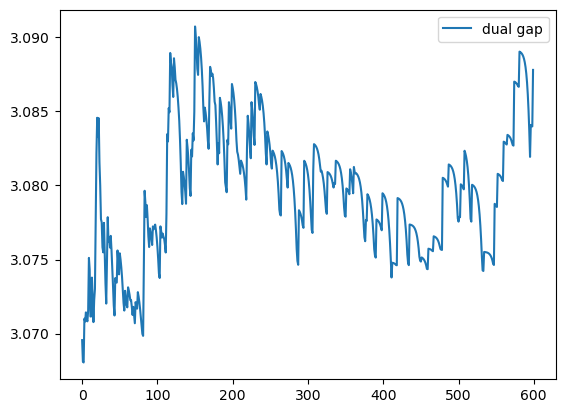

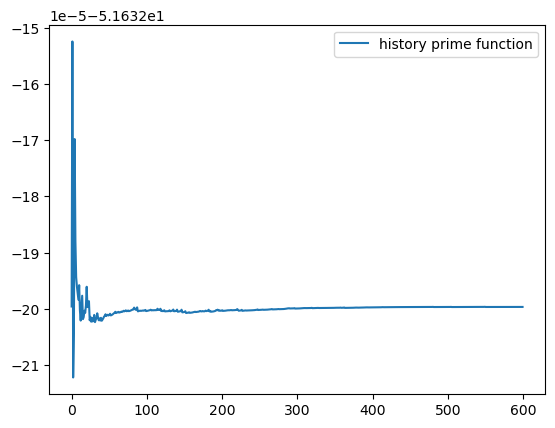

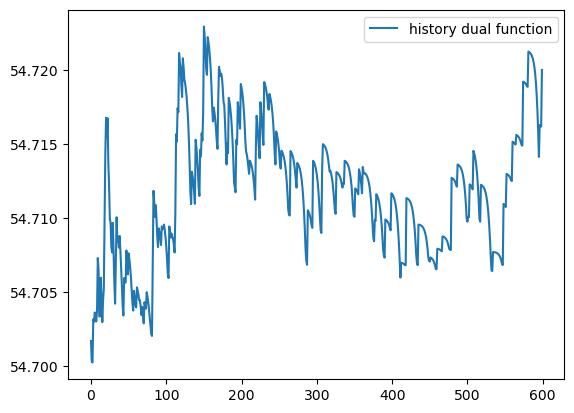

In [136]:
plt.plot(dgap_log, label="dual gap")
plt.legend()
plt.show()

plt.plot(history_prime_values, label="history prime function")
plt.legend()
plt.show()

plt.plot(history_dual_values, label="history dual function")
plt.legend()
plt.show()

In [10]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())

vars block grad:  0.0
t in optim params grad:  0.0 0.0
la in optim params grad:  26.219936940859927
mu in optim params grad:  26.261383907437413
norm T:  0.0
grad dF dla:  0.12239030463886905
grad dF dmu:  0.1221871790671455
prime function value:  19.05361456152633


In [ ]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())